### Load packages

In [1]:
import os
import fnmatch
import json
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
# !pip install -q adjustText
# from adjustText import adjust_text # not quite useful
import random


def find_dirs(target_name, root_path):
    match_files = []
    for root, dirs, files in os.walk(root_path):
        for dir_name in dirs:
            if target_name == dir_name:
                match_files.append(os.path.join(root, dir_name))
    return match_files

def find_files(pattern, root_path, recursive=False):
    match_files = []
    if recursive:
        for root, dirs, files in os.walk(root_path):
            for file_name in files:
                if fnmatch.fnmatch(file_name, pattern):
                    match_files.append(os.path.join(root, file_name))
    else:
        # list all subfiles
        for file_name in os.listdir(root_path):
            if fnmatch.fnmatch(file_name, pattern):
                match_files.append(os.path.join(root_path, file_name))

    return match_files

def load_eval_results(eval_file_dict, previous_eval_dict_list=[]):
    '''
    Load eval results from json files and return a dict with averaged scores.
    input eval_file_dict is a dict in which key is a dir path and value is a list of eval files.
    '''
    eval_dict_list = previous_eval_dict_list
    loaded_evals_set = set(eval_dict['path'] for eval_dict in previous_eval_dict_list)
    new_evals_set = set()
    
    exp_set =set()
    for eval_dir_name, eval_file_list in tqdm.tqdm(eval_file_dict.items(), desc='Processing eval dir'):
        for eval_file in tqdm.tqdm(eval_file_list, desc='Processing eval dir %s' % eval_dir_name, miniters=100):
#             print('*' * 50)
#             print(eval_dir_name)
#             print(eval_file)
            new_evals_set.add(eval_file)
            if eval_file in loaded_evals_set:
                continue
                
            name_fields = eval_file.split('/')

            eval_dict = {}
            

            eval_dict['path'] = eval_file
            eval_dict['exp_group'] = name_fields[-6]

            exp_name = name_fields[-2]
            exp_fields = exp_name.split('-')
            step = int(exp_fields[-1][exp_fields[-1].rfind('_')+1:])
            exp_name = exp_name[: exp_name.rfind('_step')]
            eval_dict['exp_name'] = exp_name
            
#             if eval_dict['exp_name'] in exp_set:
#                 continue
#             exp_set.add(eval_dict['exp_name'])
#             for i, k in enumerate(name_fields):
#                 print('%d: %s' % (i, k))
#             for i, k in enumerate(exp_fields):
#                 print('%d: %s' % (i, k))

            if '-v3' in eval_file:
                eval_dict['test_name'] = name_fields[-1][: name_fields[-1].rfind('.')]
                eval_dict['tokenization'], eval_dict['train_mode'], _ = name_fields[-5].split('-')

                eval_dict['model_base'] = exp_fields[4]
                eval_dict['order'] = exp_fields[3]
                eval_dict['train_dataset'] = exp_fields[2]
                eval_dict['step'] = step

                eval_dict['test_dataset'] = name_fields[-1][:name_fields[-1].find('.')]
                eval_dict['decoding_method'] = 'exhaustive'
                eval_dict['decoding_terminate'] = name_fields[-5].split('-')[-1]
                eval_dict['beam_width'] = name_fields[-4].split('-')[-2][4:]
                eval_dict['max_length'] = name_fields[-4].split('-')[-1][6:]
            else:
                eval_dict['test_name'] = name_fields[-1][: name_fields[-1].rfind('.')]
                eval_dict['tokenization'], eval_dict['train_mode'], _ = name_fields[-5].split('-')

                eval_dict['model_base'] = exp_fields[3]
                eval_dict['order'] = exp_fields[2]
                eval_dict['train_dataset'] = exp_fields[0]
                eval_dict['step'] = step

                eval_dict['test_dataset'] = name_fields[-1][:name_fields[-1].find('.')]
                eval_dict['decoding_method'] = 'exhaustive'
                eval_dict['decoding_terminate'] = name_fields[-5].split('-')[-1]
                eval_dict['beam_width'] = name_fields[-4].split('-')[-2][4:]
                eval_dict['max_length'] = name_fields[-4].split('-')[-1][6:]
        
            try:
                eval_full_dict = json.load(open(eval_file, 'r'))
            except:
                print('Error when loading %s' % eval_file)
                continue
            
            eval_avg_dict = {k: np.average(v) for k,v in eval_full_dict.items()}

            
#             for k,v in eval_dict.items():
#                 print('\t%s : %s' % (k,v))
#             for k, v in eval_avg_dict.items():
#                 if k.endswith('_num'):
#                     eval_dict[k] = v
                    
            eval_dict.update(eval_avg_dict)
            eval_dict_list.append(eval_dict)

#             break
#         continue
    
    # some results are actually removed from disk.
    eval_dict_list = [eval_dict for eval_dict in eval_dict_list if eval_dict['path'] in new_evals_set]
            
    return eval_dict_list



def peak_index(group, x_index, y_index):
    max_x, max_y = 0, -1

    for id_label, _ in group.iterrows():
        if group.at[id_label , y_index] > max_y:
            max_y = group.at[id_label , y_index]
            max_x = group.at[id_label , x_index]
            
    return max_x, max_y


def get_max_change(group, y_index, skip_first=5):
    max_change = 0.0
    max_change_rate = 0.0

    for idx, (id_label, _) in enumerate(group.iterrows()):
        if idx < skip_first:
            continue
        if idx == skip_first:
            prev_id_label = id_label
            continue
        if abs(group.at[id_label, y_index] - group.at[prev_id_label, y_index]) > max_change:
            max_change = abs(group.at[id_label, y_index] - group.at[prev_id_label, y_index])
            max_change_rate = max_change / group.at[prev_id_label, y_index]
            
    return max_change, max_change_rate


def plot_testing_curve(df, y_index, title='', plot_valid_peak=True):
    fig, ax = plt.subplots(figsize=(16,5))

    if plot_valid_peak:
        valid_peak_x, valid_peak_y = peak_index(df[df.test_dataset.str.endswith('kp20k_valid2k')], x_index='step', y_index=y_index)
    #     print(valid_peak_x, valid_peak_y)
        valid_box_props = dict(facecolor='w', alpha=0.5)
    
    peak_box_props = dict(boxstyle="round", fc="w", ec="0.5", alpha=0.8)
    
    for key, grp in df.groupby(['test_dataset']):
#         print(key)
#         print(grp.shape)
#         display(grp)
        if key.endswith('kp20k_valid2k'):
            ax = grp.plot(ax=ax, title=title, kind='line', x='step', y=y_index, label=key, style='-o', linestyle='dashed', markersize=8.0, linewidth=4)
        else:
            ax = grp.plot(ax=ax, title=title, kind='line', x='step', y=y_index, label=key, style='-o', markersize=8.0, linewidth=4)

        peak_x, peak_y = peak_index(grp, x_index='step', y_index=y_index)
        variance = grp[y_index].var()
        max_change, max_change_rate = get_max_change(grp, y_index=y_index)

        if not plot_valid_peak or peak_x == valid_peak_x:
            ax.annotate('%s peak=%.3f (@step=%d)' % (key, peak_y, peak_x), xy=(peak_x, peak_y), textcoords='data', size=8, bbox=peak_box_props)
#             ax.annotate('peak=%.3f (@step=%d), var=%.3f, ckpt\u2195=%.3f(%.1f%%)' % (peak_y, peak_x, variance, max_change, max_change_rate * 100), xy=(peak_x, peak_y), textcoords='data', size=8, bbox=peak_box_props)
        else:
            valid_peak_y = grp[grp.step == valid_peak_x][y_index].item()
            ax.annotate('%s peak=%.3f (@step=%d), valid\u2193=%.3f(%.1f%%), ' % (key, peak_y, peak_x, valid_peak_y, (peak_y-valid_peak_y)/valid_peak_y * 100), xy=(peak_x, peak_y), textcoords='data', size=8, bbox=peak_box_props)
#             ax.annotate('peak=%.3f (@step=%d), var=%.3f, ckpt\u2195=%.3f(%.1f%%), valid\u2193=%.3f(%.1f%%), ' % (peak_y, peak_x, variance, max_change, max_change_rate * 100, valid_peak_y, (peak_y-valid_peak_y)/valid_peak_y * 100), xy=(peak_x, peak_y), textcoords='data', size=8, bbox=peak_box_props)

    if plot_valid_peak:
        plt.axvline(x=valid_peak_x, color='k', linestyle='--')
    plt.legend(loc='best')
    plt.show()

    
def brief_eval_results(df, base_metric, metrics='all', ignore_valid=False):
    '''
    Given complete results of a set of training experiments (performance of all ckpts on each dataset),
    return best-test/best-valid/last-ckpt score of each dataset
    '''
    assert base_metric is not None, "base metric must be given!"
    if isinstance(metrics, str):
        if metrics == 'present':
            metrics = ['present_exact_precision@5', 'present_exact_recall@5', 'present_exact_f_score@5', 'present_exact_precision_hard@5', 'present_exact_f_score_hard@5', 'present_exact_precision@10', 'present_exact_recall@10', 'present_exact_f_score@10', 'present_exact_precision_hard@10', 'present_exact_f_score_hard@10', 'present_exact_precision@k', 'present_exact_recall@k', 'present_exact_f_score@k', 'present_exact_precision_hard@k', 'present_exact_f_score_hard@k', 'present_exact_precision@M', 'present_exact_recall@M', 'present_exact_f_score@M', 'present_exact_precision_hard@M', 'present_exact_f_score_hard@M', 'present_exact_advanced_auc', 'present_exact_advanced_ap', 'present_exact_advanced_mrr', 'present_exact_advanced_sadr', 'present_exact_advanced_ndcg', 'present_exact_advanced_alpha_ndcg@5', 'present_exact_advanced_alpha_ndcg@10']
        elif metrics == 'absent':
            metrics = ['absent_exact_precision@10', 'absent_exact_recall@10', 'absent_exact_f_score@10', 'absent_exact_precision_hard@10', 'absent_exact_f_score_hard@10', 'absent_exact_precision@50', 'absent_exact_recall@50', 'absent_exact_f_score@50', 'absent_exact_precision_hard@50', 'absent_exact_f_score_hard@50', 'absent_exact_precision@M', 'absent_exact_recall@M', 'absent_exact_f_score@M', 'absent_exact_precision_hard@M', 'absent_exact_f_score_hard@M', 'absent_exact_advanced_auc', 'absent_exact_advanced_ap', 'absent_exact_advanced_mrr', 'absent_exact_advanced_sadr', 'absent_exact_advanced_ndcg', 'absent_exact_advanced_alpha_ndcg@5', 'absent_exact_advanced_alpha_ndcg@10']
        else:
            metrics = ['present_exact_precision@5', 'present_exact_recall@5', 'present_exact_f_score@5', 'present_exact_precision_hard@5', 'present_exact_f_score_hard@5', 'present_exact_precision@10', 'present_exact_recall@10', 'present_exact_f_score@10', 'present_exact_precision_hard@10', 'present_exact_f_score_hard@10', 'present_exact_precision@k', 'present_exact_recall@k', 'present_exact_f_score@k', 'present_exact_precision_hard@k', 'present_exact_f_score_hard@k', 'present_exact_precision@M', 'present_exact_recall@M', 'present_exact_f_score@M', 'present_exact_precision_hard@M', 'present_exact_f_score_hard@M', 'present_exact_advanced_auc', 'present_exact_advanced_ap', 'present_exact_advanced_mrr', 'present_exact_advanced_sadr', 'present_exact_advanced_ndcg', 'present_exact_advanced_alpha_ndcg@5', 'present_exact_advanced_alpha_ndcg@10', 'absent_exact_precision@10', 'absent_exact_recall@10', 'absent_exact_f_score@10', 'absent_exact_precision_hard@10', 'absent_exact_f_score_hard@10', 'absent_exact_precision@50', 'absent_exact_recall@50', 'absent_exact_f_score@50', 'absent_exact_precision_hard@50', 'absent_exact_f_score_hard@50', 'absent_exact_precision@M', 'absent_exact_recall@M', 'absent_exact_f_score@M', 'absent_exact_precision_hard@M', 'absent_exact_f_score_hard@M', 'absent_exact_advanced_auc', 'absent_exact_advanced_ap', 'absent_exact_advanced_mrr', 'absent_exact_advanced_sadr', 'absent_exact_advanced_ndcg', 'absent_exact_advanced_alpha_ndcg@5', 'absent_exact_advanced_alpha_ndcg@10']
    else:
        assert isinstance(metrics, list)

    str_rows = []
    self_peak_df = pd.DataFrame()
    valid_peak_df = pd.DataFrame()
    last_ckpt_df = pd.DataFrame()
    
    # group rows by those values and return the ones with best valid scores
    for exp_name, exp_grp in df.groupby(['exp_name', 'beam_width', 'decoding_method', 'decoding_terminate']):
#         print(exp_name)
        exp_grp = exp_grp.sort_values(by='test_dataset', ascending=True)
        
        if not ignore_valid:
            valid_peak_step, _ = peak_index(exp_grp[exp_grp.test_dataset.str.endswith('kp20k_valid2k')], x_index='step', y_index=base_metric)

        for testset, testset_grp in exp_grp.groupby(['test_dataset']):            
            self_peak_step, _ = peak_index(testset_grp, x_index='step', y_index=base_metric)
            last_step = testset_grp['step'].max()
            
            try:
                train_mode = testset_grp.loc[testset_grp.step == self_peak_step, 'train_mode'].values[0]
            except Exception as e:
                print('Error while locating best test score!')
                print('self_peak_step=%s' % self_peak_step)
                print(testset_grp.iloc[0]['path'])
                print(testset_grp.shape)
                display(testset_grp)
                raise e

            order = testset_grp[testset_grp.step==self_peak_step].order.values[0]
            decoding_terminate = testset_grp[testset_grp.step==self_peak_step].decoding_terminate.values[0]
            str_row = {'exp_name': exp_name, 'train_mode': train_mode, 'test_dataset': testset, 'order': order, 'decoding_terminate': decoding_terminate, 'self_peak_step': self_peak_step}
#             self_peak_row = {'exp_name': exp_name, 'train_mode': train_mode, 'test_dataset': testset, 'order': order, 'decoding_terminate': decoding_terminate, 'self_peak_step': self_peak_step, 'valid_peak_step': valid_peak_step}
#             valid_peak_row = {'exp_name': exp_name, 'train_mode': train_mode, 'test_dataset': testset, 'order': order, 'decoding_terminate': decoding_terminate, 'self_peak_step': self_peak_step, 'valid_peak_step': valid_peak_step}
            if not ignore_valid:
                str_row['valid_peak_step'] = valid_peak_step

            for metric in metrics:
                self_peak_value = testset_grp[testset_grp.step==self_peak_step][metric].values[0]

                if not ignore_valid:
                    try:
                        valid_peak_value = testset_grp[testset_grp.step==valid_peak_step][metric].values[0]
                    except Exception:
                        print('Error while locating best valid score!')
                        print('metric=', metric)
                        print('valid_peak_step=', valid_peak_step)
                        print('len(testset_grp)=', len(testset_grp))
                        print(next(iter(testset_grp.path), 'no match'))
                        display(testset_grp)
                        display(testset_grp[testset_grp.step==valid_peak_step])
                        display(testset_grp[testset_grp.step==valid_peak_step][metric])
                        return
                else: 
                    valid_peak_value = 0.0

                str_row[metric] = '%.4f (%.4f)' % (self_peak_value, valid_peak_value)
#                 print('%s@%s - %s = %.4f' % (testset, self_peak_step, metric, testset_grp[testset_grp.step==self_peak_step][metric].item()))
#                 display(testset_grp[testset_grp.step==self_peak_step][metric])
            self_peak_row = testset_grp[testset_grp.step==self_peak_step]
            valid_peak_row = testset_grp[testset_grp.step==valid_peak_step] if not ignore_valid else self_peak_row
            last_step_row = testset_grp[testset_grp.step==last_step]
            
            str_rows.append(str_row)
            self_peak_df = self_peak_df.append(self_peak_row)
            last_ckpt_df = last_ckpt_df.append(last_step_row)
            if not ignore_valid:
                valid_peak_df = valid_peak_df.append(valid_peak_row)
    
    str_summary_df = pd.DataFrame(str_rows).sort_values(by=['test_dataset', 'exp_name'])
    self_peak_df = self_peak_df.sort_values(by=['test_dataset', 'exp_name'])
    last_ckpt_df = last_ckpt_df.sort_values(by=['test_dataset', 'exp_name'])
    
    if not ignore_valid:
        valid_peak_df = valid_peak_df.sort_values(by=['test_dataset', 'exp_name'])
  
    return str_summary_df, self_peak_df, valid_peak_df, last_ckpt_df
    

## Load data

In [2]:
import pickle
# load from pickle
with open('empirical_analysis_v2_splitnopunk_eval.pkl', 'rb') as tmp_pkl:
    eval_dirs, eval_file_dict, pred_file_dict, kp20k_eval_file_dict, all_splitnopunk_eval_result_dicts, one2one_eval_df, one2seq_eval_df, all_eval_df = pickle.load(tmp_pkl)

print(len(eval_dirs))
print(len(eval_file_dict))
print(len(pred_file_dict))
print(len(kp20k_eval_file_dict))
print(len(all_splitnopunk_eval_result_dicts))
print(one2one_eval_df.shape)
print(one2seq_eval_df.shape)
print(all_eval_df.shape)


28
28
28
28
43718
(15443, 236)
(28275, 236)
(43718, 236)


## #1 Plot the testing curve
Models to plot:
 - One2one: kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1
 - One2seq: 
     - kp20k-meng17-random-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1
     - kp20k-meng17-length-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1
     - kp20k-meng17-no_sort-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1
     - kp20k-meng17-alphabetical-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1
     - kp20k-meng17-verbatim_prepend-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1
     - kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1
     
Messages:
 - One2one converges much faster than One2seq
 - If we check the testing curve close
     - The optimal time-step on transfered datasets is very different from train/valid dataset, which can lead to huge gap between valid-peak with real-peak (up to 16.6% for one2one, 7.2% for one2seq).
     - One2seq is less rough than one2one. Which means for the top 10 results, the one2seq is more stable with respect to ranking, partly because it takes into account the correlation between phrases in a sequence.
     - The more distance between the training and testing dataset, the larger the performance gap between real/valid peak. A few-shot learning might be useful for this domain adaptation.
     
TODO:
 - Run pred&eval of step=5000 for seq2seq

### Summary (used in paper Table 1)

#### Present  

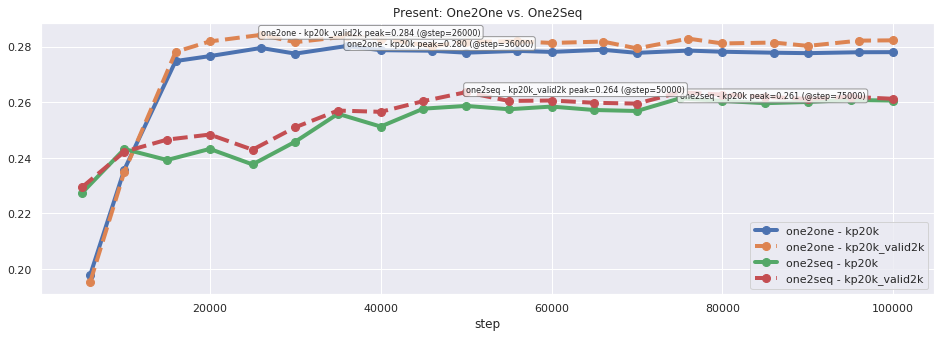

In [5]:
y_index='present_exact_f_score@10'


# prepare for one2one data
# BaseRNN-one2one
one2one_df = all_eval_df.loc[all_eval_df['exp_name'] == 'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1']
# Transformer-one2one
# one2one_df = all_eval_df.loc[all_eval_df['exp_name'] == 'kpgen-meng17-kp20k-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue']
# Transformer-one2one, MagKP20k
# one2one_df = all_eval_df.loc[all_eval_df['exp_name'] == 'kpgen-meng17-magkp-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue']
# BigRNN-one2one
# one2one_df = all_eval_df.loc[all_eval_df['exp_name'] == 'kp20k-meng17-one2one-BS128-LR0.05-L1-H8-D512-E128-DO0.1-Copytrue']

# prepare one2seq data
# BaseRNN-one2seq
one2seq_df = all_eval_df.loc[all_eval_df['exp_name'] == 'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1']
# Transformer-one2seq
# one2seq_df = all_eval_df.loc[all_eval_df['exp_name'] == 'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue']
# Transformer-one2seq, MagKP20k
# one2seq_df = all_eval_df.loc[all_eval_df['exp_name'] == 'kpgen-meng17-magkp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue']
# BigRNN-one2seq
# one2seq_df = all_eval_df.loc[all_eval_df['exp_name'] == 'kp20k-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim512-Emb128-Dropout0.1-Copytrue']


one2one_df = one2one_df.sort_values(by='step', ascending=True)
one2one_df = one2one_df.loc[(one2one_df.step % 10000 == 6000) | (one2one_df.step % 5000 == 0)] # keep % 10000 and 5000
one2one_df = one2one_df.loc[one2one_df.beam_width == '200']
one2seq_df = one2seq_df.loc[one2seq_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam
one2seq_df = one2seq_df.loc[one2seq_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating
kp20k_one2one_df = one2one_df[one2one_df.test_dataset.str.startswith('kp20k')]

for index_label, row_series in kp20k_one2one_df.iterrows():
     kp20k_one2one_df.at[index_label, 'test_dataset'] = 'one2one - ' + kp20k_one2one_df.at[index_label, 'test_dataset']
    

one2seq_df = one2seq_df.sort_values(by='step', ascending=True)
one2seq_df = one2seq_df.loc[one2seq_df.step % 5000 == 0] # keep % 10000 and 5000
one2seq_df = one2seq_df.sort_values(by='step', ascending=True)
one2seq_df = one2seq_df.loc[one2seq_df.beam_width == '50']
one2seq_df = one2seq_df.loc[one2seq_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam
one2seq_df = one2seq_df.loc[one2seq_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating
kp20k_one2seq_df = one2seq_df[one2seq_df.test_dataset.str.startswith('kp20k')]

for index_label, row_series in kp20k_one2seq_df.iterrows():
     kp20k_one2seq_df.at[index_label, 'test_dataset'] = 'one2seq - ' + kp20k_one2seq_df.at[index_label, 'test_dataset']

# combine both and plot
combined_kp20k_df = kp20k_one2one_df.append(kp20k_one2seq_df, ignore_index=True)
combined_df = one2one_df.append(one2seq_df, ignore_index=True)

plot_testing_curve(combined_kp20k_df, y_index=y_index, plot_valid_peak=False, title='Present: One2One vs. One2Seq')


#### Absent

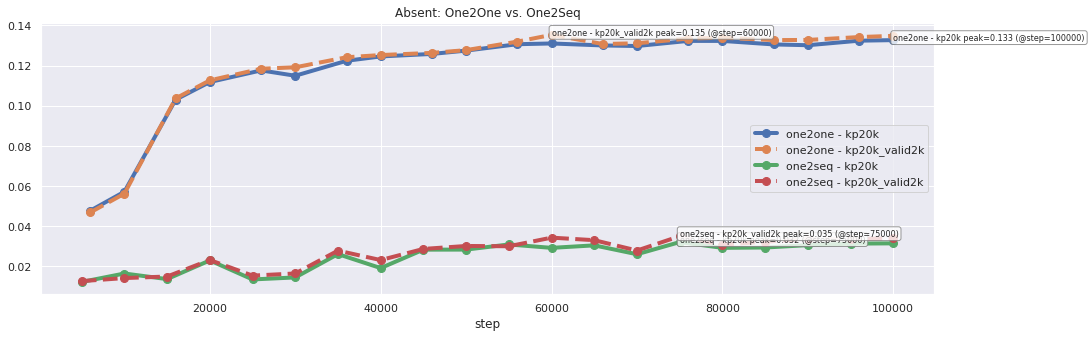

In [6]:
y_index='absent_exact_recall@50'

plot_testing_curve(combined_kp20k_df, y_index=y_index, plot_valid_peak=False, title='Absent: One2One vs. One2Seq')


#### Valid-peak

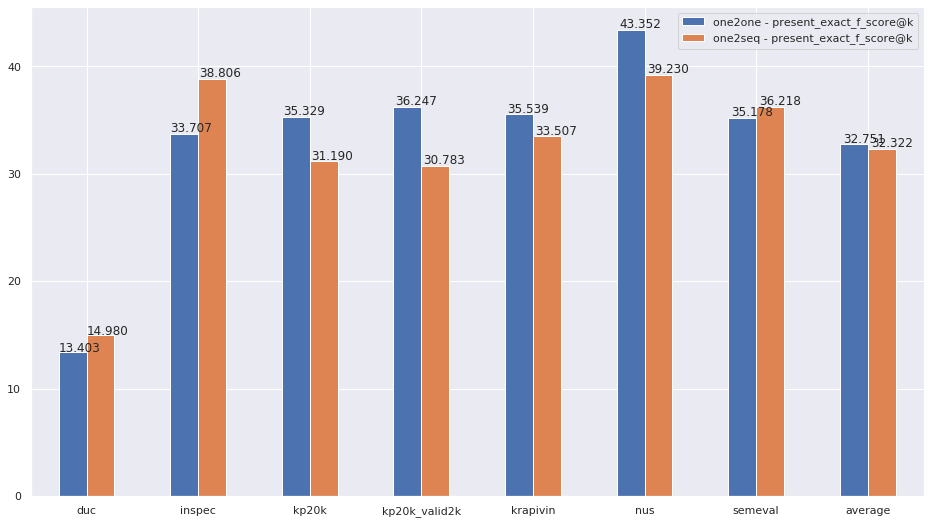

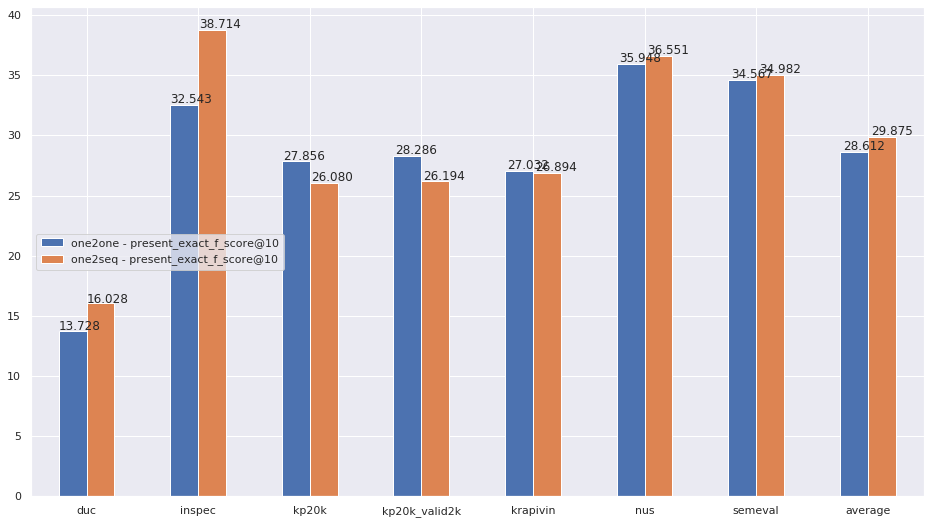

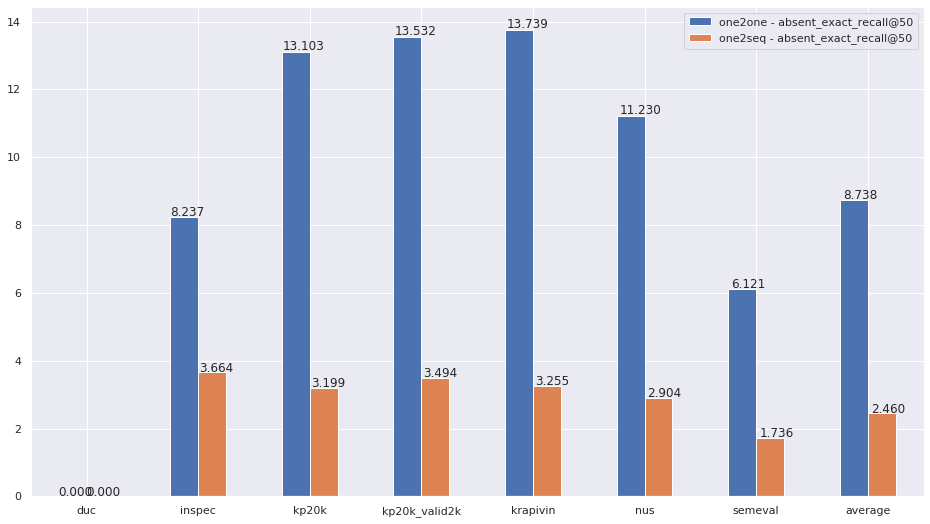

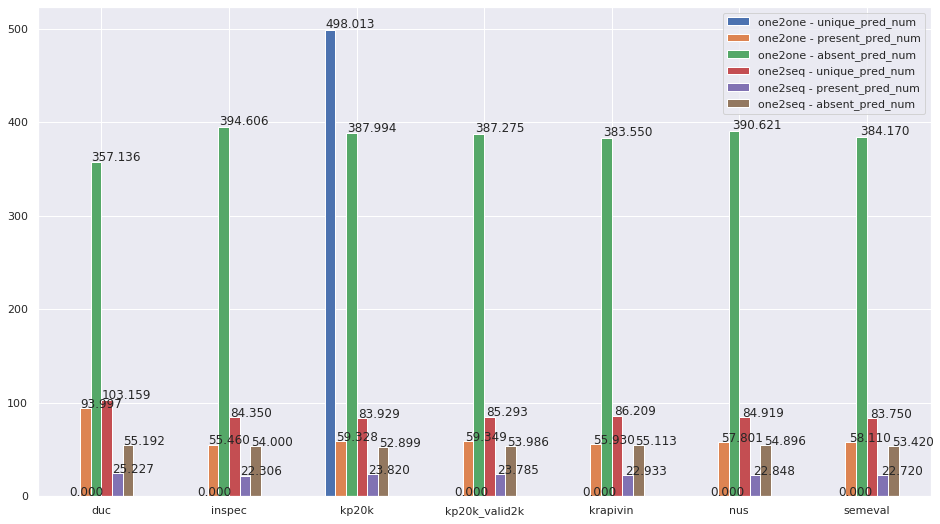

In [7]:
# Present F-score@O
metric_name = 'present_exact_f_score@k'
_, _, valid_peak_summary_df, _ = brief_eval_results(combined_df, base_metric=metric_name)
metric_names = [metric_name]

datasets = valid_peak_summary_df.test_dataset.unique()
modes = valid_peak_summary_df.train_mode.unique()
bar_values = {'%s - %s' % (mode, metric_name): [] for mode in modes for metric_name in metric_names}

for index_label, row_series in valid_peak_summary_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.train_mode, metric_name)].append(float(bar_value))

        kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'average')

df = pd.DataFrame(bar_values, index=datasets) * 100.0
ax = df.plot.bar(figsize=(16,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
    
    


# Present F-score@10
# change to use F@O as anchor metric for present KPG
_, _, valid_peak_summary_df, _ = brief_eval_results(combined_df, base_metric='present_exact_f_score@k')
# metric_names = ['present_exact_f_score@5', 'present_exact_f_score@10', 'present_exact_f_score@k', 'present_exact_f_score@M']
metric_names = ['present_exact_f_score@10']

datasets = valid_peak_summary_df.test_dataset.unique()
modes = valid_peak_summary_df.train_mode.unique()
bar_values = {'%s - %s' % (mode, metric_name): [] for mode in modes for metric_name in metric_names}

for index_label, row_series in valid_peak_summary_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.train_mode, metric_name)].append(float(bar_value))

        kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'average')

df = pd.DataFrame(bar_values, index=datasets) * 100.0
ax = df.plot.bar(figsize=(16,9), rot=0)
ax.legend(loc='center left')

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
    
    
    
     
    

# Absent results
metric_name = 'absent_exact_recall@50'
_, _, valid_peak_summary_df, _ = brief_eval_results(combined_df, base_metric=metric_name)
metric_names = [metric_name]

datasets = valid_peak_summary_df.test_dataset.unique()
modes = valid_peak_summary_df.train_mode.unique()
bar_values = {'%s - %s' % (mode, metric_name): [] for mode in modes for metric_name in metric_names}

for index_label, row_series in valid_peak_summary_df.iterrows():
    train_mode = row_series.train_mode
    
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (train_mode, metric_name)].append(float(bar_value))

        kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'average')

df = pd.DataFrame(bar_values, index=datasets) * 100.0
ax = df.plot.bar(figsize=(16,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
    
    
    
    
    
    
    
    
# Phrase number

_, _, valid_peak_summary_df, _ = brief_eval_results(combined_df, base_metric='present_exact_f_score_hard@10')
metric_names = ['unique_pred_num', 'present_pred_num', 'absent_pred_num']

datasets = valid_peak_summary_df.test_dataset.unique()
modes = valid_peak_summary_df.train_mode.unique()
bar_values = {'%s - %s' % (mode, metric_name): [] for mode in modes for metric_name in metric_names}

# metric_name = 'present_exact_f_score_hard@10'

for index_label, row_series in valid_peak_summary_df.iterrows():
    train_mode = row_series.train_mode
    
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (train_mode, metric_name)].append(float(bar_value))

df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(16,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   


## Effect of Copy

### Sum up (used in paper)

/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


All data
(700, 236)
absent valid_kp_df
(28, 236)


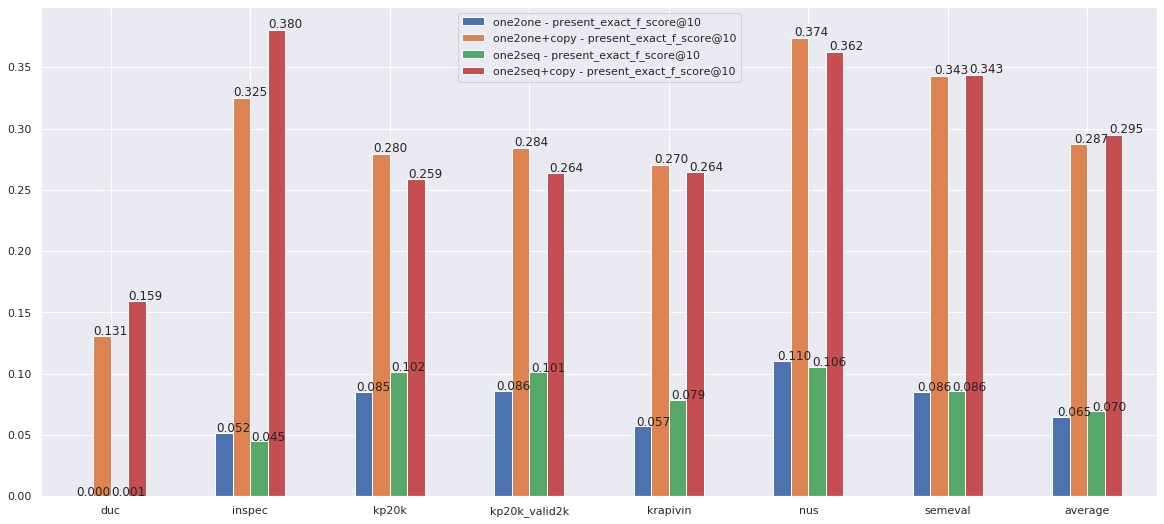

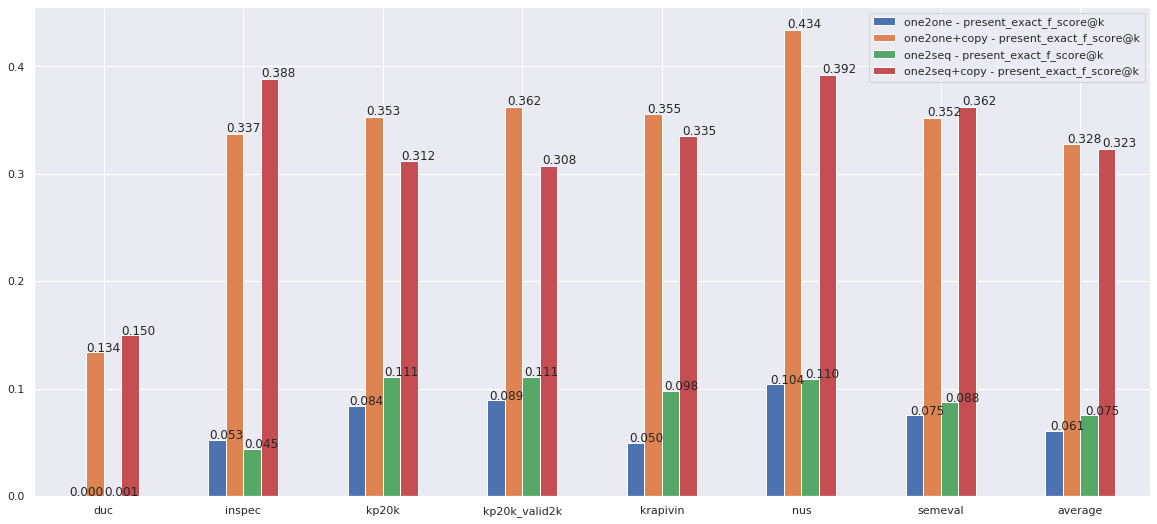

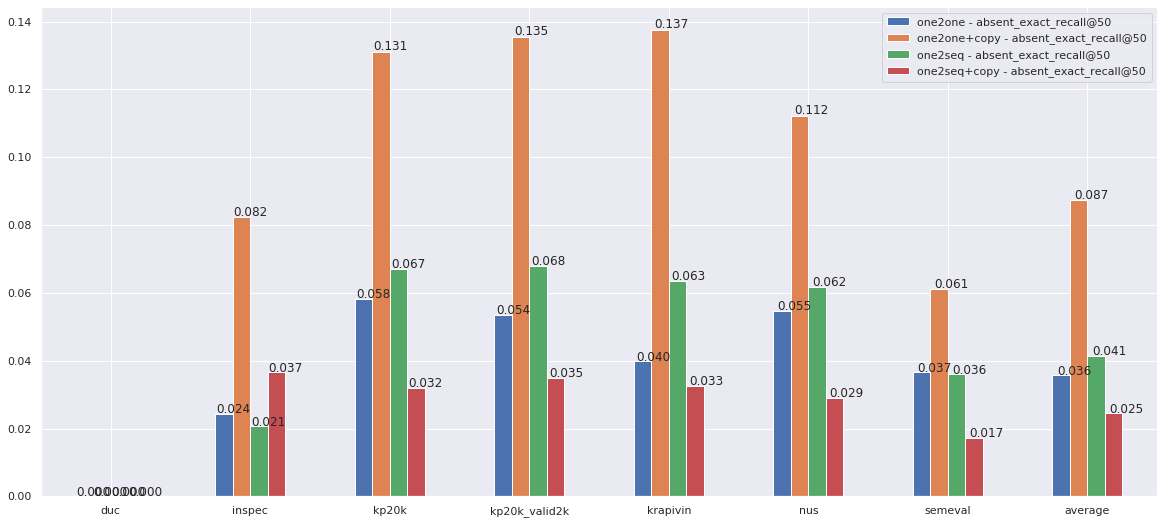

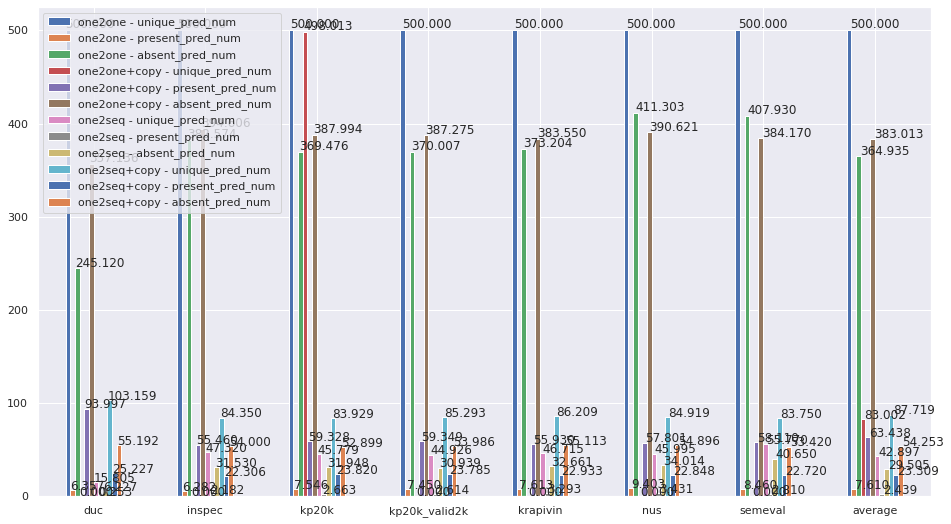

In [8]:
# 2. Compare different architecture variants
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

ordered_datasets = ['kp20k', 'inspec', 'krapivin', 'nus', 'semeval', 'duc', 'average']

kp_exps = {
        'one2one': 'kp20k-meng17-one2one-BS128-LR0.05-L1-D150-E100-DO0.0-Copyfalse-Covfalse',
        'one2one+copy': 'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1',
        'one2seq': 'kp20k-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copyfalse',
        'one2seq+copy': 'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1',
}

# kp_exps = {
#         'one2one': 'kpgen-meng17-kp20k-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copyfalse-Covfalse',
#         'one2one+copy': 'kpgen-meng17-kp20k-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
#         'one2seq': 'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copyfalse-Covfalse',
#         'one2seq+copy': 'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# }
long2short = {long: short for short, long in kp_exps.items()}

# prepare data
kp_df = all_eval_df.loc[all_eval_df['exp_name'].isin(kp_exps.values())]
kp_df = kp_df.loc[(kp_df.step % 10000 == 6000) | (kp_df.step % 5000 == 0)] # keep % 10000
kp_df = kp_df.sort_values(by='step', ascending=True)
kp_df = kp_df.loc[(kp_df.beam_width == '50') | (kp_df.beam_width == '200')]
kp_df = kp_df.loc[kp_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam
kp_df = kp_df.loc[kp_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating


for index_label, row_series in kp_df.iterrows():
    expname = kp_df.at[index_label, 'exp_name']
    kp_df.at[index_label, 'exp_name'] = long2short[expname]

############## present F@10
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='present_exact_f_score@10')
metric_names = ['present_exact_f_score@5', 'present_exact_f_score@10', 'present_exact_f_score@k']
metric_names = ['present_exact_advanced_sadr']
metric_names = ['present_exact_f_score@10']

datasets = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'average')

df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))    
    

    
    
############## present F@O
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='present_exact_f_score@k')
metric_names = ['present_exact_f_score@5', 'present_exact_f_score@10', 'present_exact_f_score@k']
metric_names = ['present_exact_f_score@k']

datasets = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'average')

df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))    
  
    
    
    

############## absent
print('All data')
print(kp_df.shape)
print('absent valid_kp_df')
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='absent_exact_recall@50')

# ensure the dataframe is sorted first
print(valid_kp_df.shape)
# display(valid_kp_df)

# metric_names = ['absent_exact_recall@10', 'absent_exact_recall@50', 'absent_exact_advanced_sadr']
metric_names = ['absent_exact_recall@50']


datasets = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}

for index_label, row_series in valid_kp_df.iterrows():
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'average')

df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))  
# display(df.transpose())


    
    
    
# Phrase number
_, _, valid_peak_summary_df, _ = brief_eval_results(kp_df, base_metric='present_exact_f_score@10')
metric_names = ['unique_pred_num', 'present_pred_num', 'absent_pred_num']

datasets = valid_peak_summary_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()
bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}

# metric_name = 'present_exact_f_score_hard@10'

for index_label, row_series in valid_peak_summary_df.iterrows():
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'average')

df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(16,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   


#### Plot average scores (Appendix C1, Fig 7)

In [9]:
# 2. Compare different architecture variants
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

ordered_datasets = ['kp20k', 'inspec', 'krapivin', 'nus', 'semeval', 'duc', 'average']

kp_exps = {
        'RNN-O2O': 'kp20k-meng17-one2one-BS128-LR0.05-L1-D150-E100-DO0.0-Copyfalse-Covfalse',
        'RNN-O2O+copy': 'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1',
        'RNN-O2S': 'kp20k-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copyfalse',
        'RNN-O2S+copy': 'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1',
        'TF-O2O': 'kpgen-meng17-kp20k-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copyfalse-Covfalse',
        'TF-O2O+copy': 'kpgen-meng17-kp20k-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
        'TF-O2S': 'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copyfalse-Covfalse',
        'TF-O2S+copy': 'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
}
long2short = {long: short for short, long in kp_exps.items()}

# prepare data
kp_df = all_eval_df.loc[all_eval_df['exp_name'].isin(kp_exps.values())]
kp_df = kp_df.loc[(kp_df.step % 10000 == 6000) | (kp_df.step % 5000 == 0)] # keep % 10000
kp_df = kp_df.sort_values(by='step', ascending=True)
kp_df = kp_df.loc[(kp_df.beam_width == '50') | (kp_df.beam_width == '200')]
kp_df = kp_df.loc[kp_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam
kp_df = kp_df.loc[kp_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating


for index_label, row_series in kp_df.iterrows():
    expname = kp_df.at[index_label, 'exp_name']
    kp_df.at[index_label, 'exp_name'] = long2short[expname]

############## present F@10
# change to use F@O as anchor metric for present KPG
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='present_exact_f_score@k')
metric_names = ['present_exact_f_score@10']

datasets = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {exp_name: [] for exp_name in exp_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values[row_series.exp_name].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')

datamodel_names = bar_values.keys()
model_names = ['RNN-O2O', 'TF-O2O', 'RNN-O2S', 'TF-O2S']
avg_bar_values = {'w/o copy': [0.0] * 4, 'w/ copy': [0.0] * 4}

for shortmodel_name, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    if '+' in shortmodel_name:
        copy_mode = 'w/ copy'
        model_name = shortmodel_name.split('+')[0]
    else:
        copy_mode = 'w/o copy'
        model_name = shortmodel_name
    avg_bar_values[copy_mode][model_names.index(model_name)] = np.mean(_v)
#     print(shortmodel_name, _v)
#     print(copy_mode, model_name, np.mean(_v))
# print(avg_bar_values)
    
f10_df = pd.DataFrame(avg_bar_values, index=model_names)
# display(f10_df)

    
    
############## present F@O
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='present_exact_f_score@k')
metric_names = ['present_exact_f_score@k']

datasets = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {exp_name: [] for exp_name in exp_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values[row_series.exp_name].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')

datamodel_names = bar_values.keys()
model_names = ['RNN-O2O', 'TF-O2O', 'RNN-O2S', 'TF-O2S']
avg_bar_values = {'w/o copy': [0.0] * 4, 'w/ copy': [0.0] * 4}

for shortmodel_name, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    if '+' in shortmodel_name:
        copy_mode = 'w/ copy'
        model_name = shortmodel_name.split('+')[0]
    else:
        copy_mode = 'w/o copy'
        model_name = shortmodel_name
    avg_bar_values[copy_mode][model_names.index(model_name)] = np.mean(_v)
#     print(shortmodel_name, _v)
#     print(copy_mode, model_name, np.mean(_v))
# print(avg_bar_values)
    
fo_df = pd.DataFrame(avg_bar_values, index=model_names)
# display(fo_df)

    
    
    

############## absent
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='absent_exact_recall@50')
metric_names = ['absent_exact_recall@50']

datasets = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {exp_name: [] for exp_name in exp_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values[row_series.exp_name].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')

datamodel_names = bar_values.keys()
model_names = ['RNN-O2O', 'TF-O2O', 'RNN-O2S', 'TF-O2S']
avg_bar_values = {'w/o copy': [0.0] * 4, 'w/ copy': [0.0] * 4}

for shortmodel_name, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    if '+' in shortmodel_name:
        copy_mode = 'w/ copy'
        model_name = shortmodel_name.split('+')[0]
    else:
        copy_mode = 'w/o copy'
        model_name = shortmodel_name
    avg_bar_values[copy_mode][model_names.index(model_name)] = np.mean(_v)
#     print(shortmodel_name, _v)
#     print(copy_mode, model_name, np.mean(_v))
# print(avg_bar_values)
    
r50_df = pd.DataFrame(avg_bar_values, index=model_names)
display(r50_df)

f10_df = f10_df * 100.0
fo_df = fo_df * 100.0
r50_df = r50_df * 100.0


/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


w/o copy   w/ copy
RNN-O2O  0.035713  0.087383
TF-O2O   0.154474  0.140182
RNN-O2S  0.041472  0.024597
TF-O2S   0.110343  0.098487

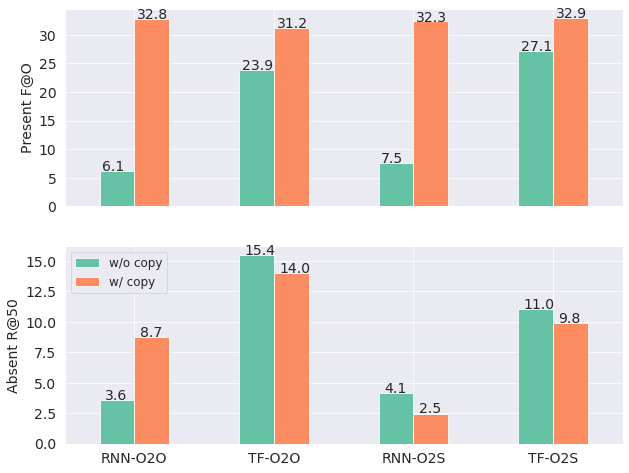

In [10]:

sns.set_palette("Set2")
sns.set_context("paper", rc={"font.size": 14,
                             "axes.titlesize": 14,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

f, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
# f10_df.plot.bar(ax=axes[0], legend=False, rot=0)
# for p in axes[0].patches:
#     axes[0].annotate('%.3f' % (p.get_height()), (p.get_x() + 0.02, p.get_height() + 0.05))  
# axes[0].set_ylabel("Present F@10")

fo_df.plot.bar(ax=axes[0], legend=False, rot=0)
for p in axes[0].patches:
    axes[0].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.02, p.get_height() + 0.05))    
axes[0].set_ylabel("Present F@O") 


r50_df.plot.bar(ax=axes[1], legend=True, rot=0)
for p in axes[1].patches:
    axes[1].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.04, p.get_height() + 0.05))    
axes[1].set_ylabel("Absent R@50") 
axes[1].legend(loc='upper left')



## Effect of Phrase Order on One2Seq Learning

#### Figures in paper are generated by onmt/keyphrase/order_heatmaps.py

### One2Seq - Present Phrase Prediction

Terminology:
 - present_pred_num means valid phrases (no <unk>, doesn't contain ,/.) that can be found in the source text.
 - verbatim_prepend means (absent_phrases+present_phrases)
 - verbatim_append means (present_phrases+absent_phrases)
    
**verbatim_prepend** outputs significantly more present_phrases and **verbatim_append/alphabetic** outputs significantly more absent_phrases, which means the more noisy hidden state lead to more diverse following predictions.
    
    
    
    

/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  after removing the cwd from sys.path.


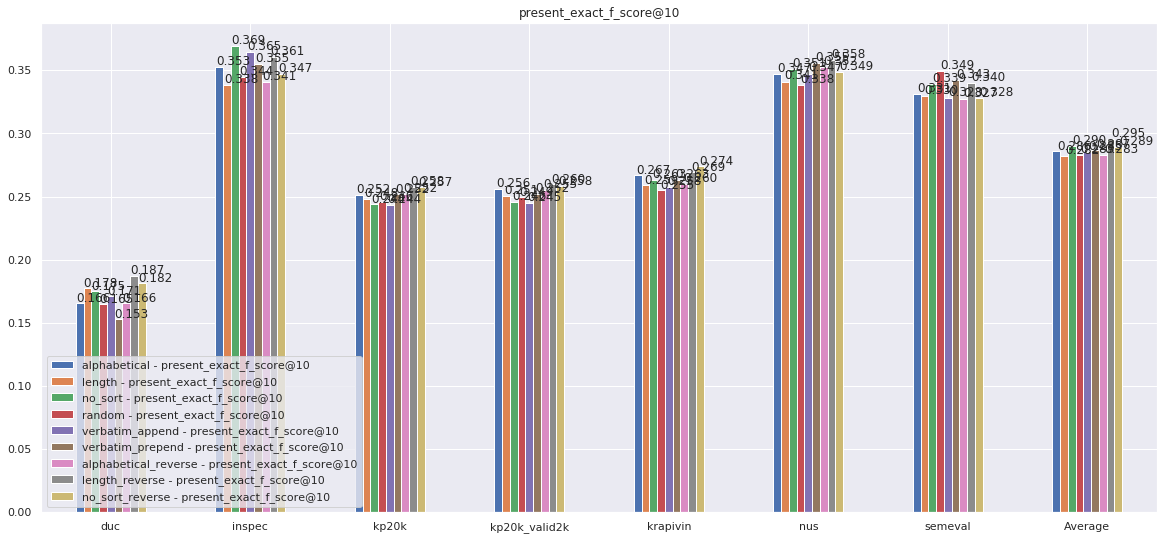

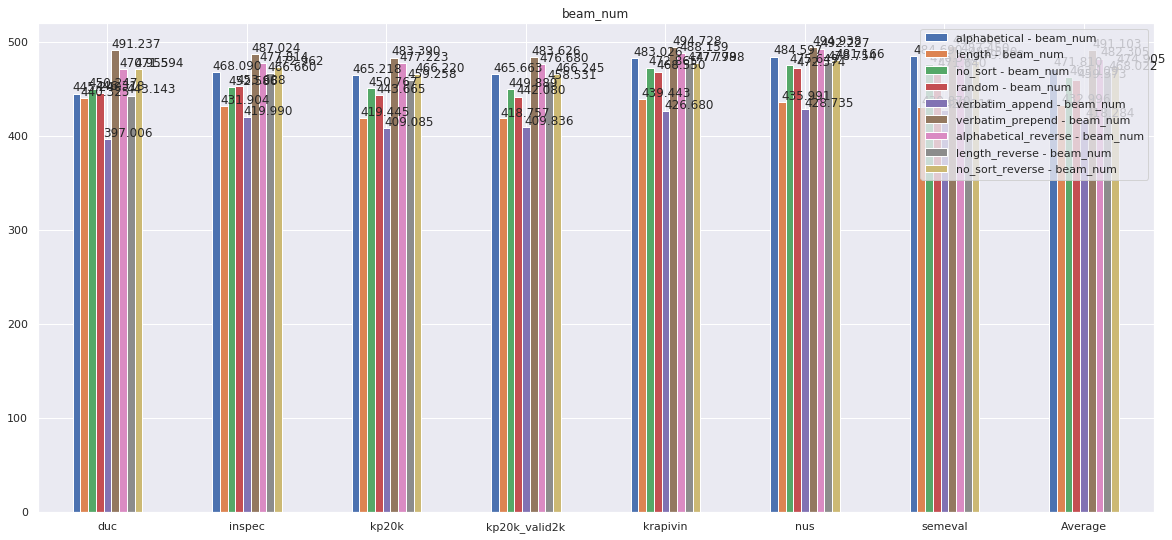

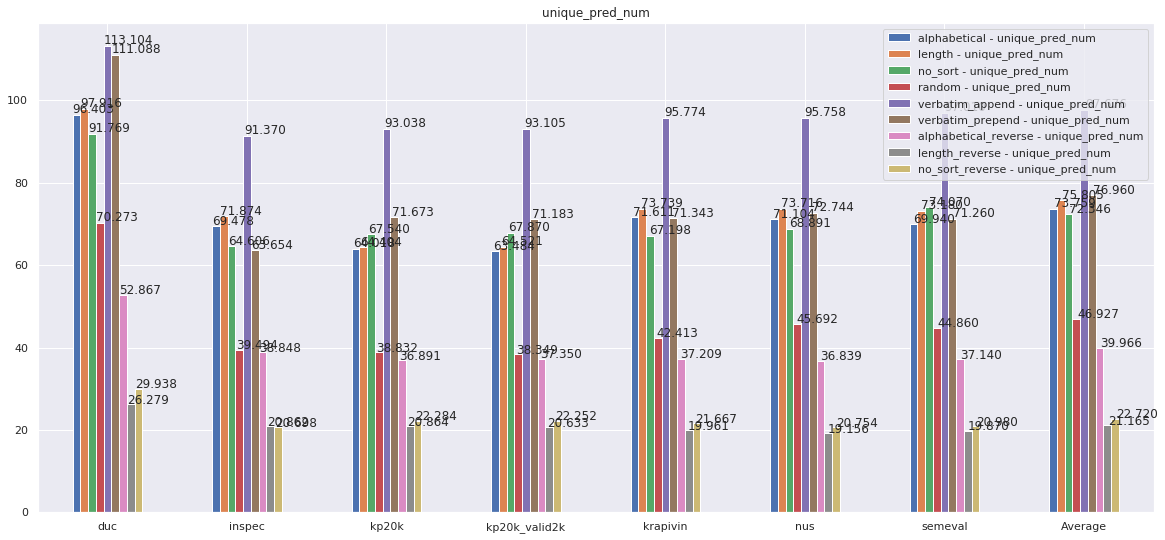

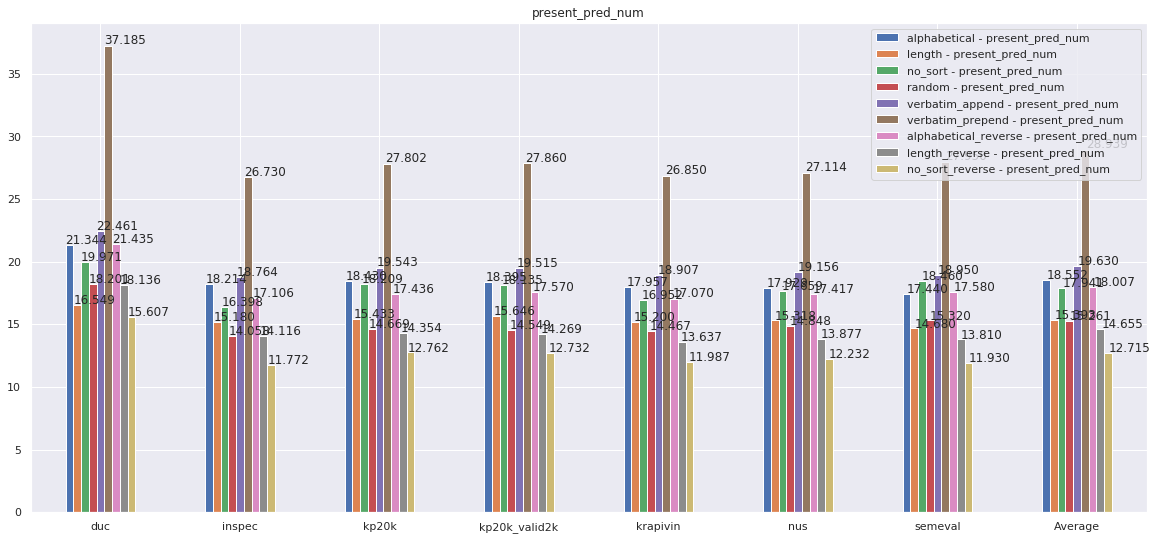

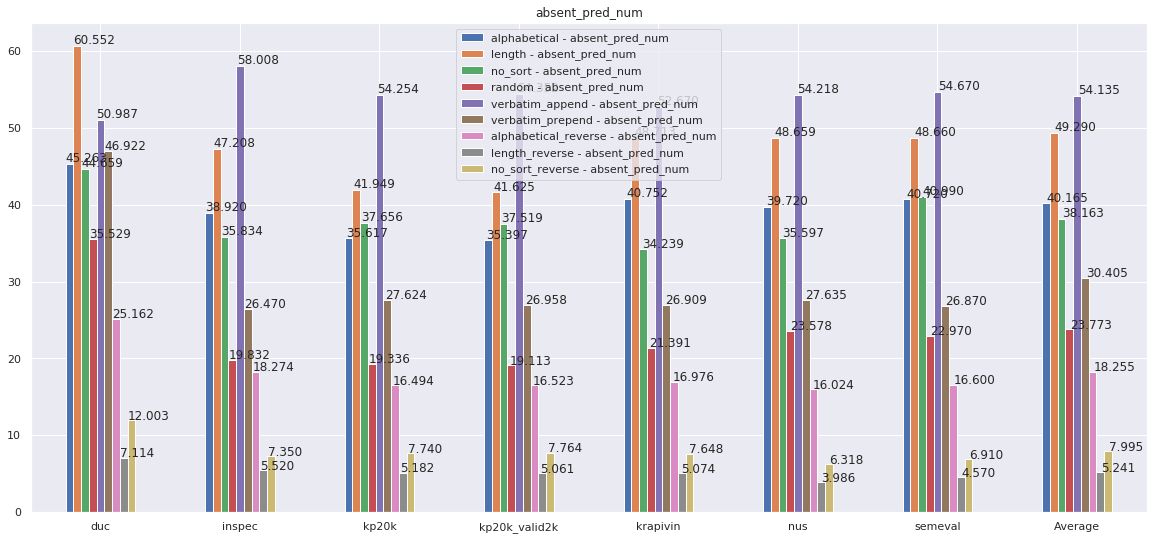

In [15]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

one2seq_exps = ['kp20k-meng17-random-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1', 
                'kp20k-meng17-length-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1', 
                'kpgen-meng17-kp20k-length_reverse-rnn-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue',
                'kp20k-meng17-no_sort-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1', 
                'kpgen-meng17-kp20k-no_sort_reverse-rnn-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue',
                'kp20k-meng17-alphabetical-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1', 
                'kpgen-meng17-kp20k-alphabetical_reverse-rnn-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue',
                'kp20k-meng17-verbatim_prepend-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1', 
                'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1']

# prepare one2seq data
one2seq_df = all_eval_df.loc[all_eval_df['exp_name'].isin(one2seq_exps)]
one2seq_df = one2seq_df.sort_values(by=['exp_name', 'step'], ascending=True)
one2seq_df = one2seq_df.loc[one2seq_df.step % 5000 == 0] # keep % 10000 and 5000
one2seq_df = one2seq_df.sort_values(by='step', ascending=True)
one2seq_df = one2seq_df.loc[one2seq_df.beam_width == '50']
one2seq_df = one2seq_df.loc[one2seq_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam
one2seq_df = one2seq_df.loc[one2seq_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating

_, _, valid_one2seq_df, _ = brief_eval_results(one2seq_df, base_metric='present_exact_f_score@10')

# ensure the dataframe is sorted first
# display(one2seq_df)
# display(valid_one2seq_df)

# metric_names = ['present_exact_f_score_hard@5', 'present_exact_f_score_hard@10', 'present_exact_f_score_hard@k', 'present_exact_f_score_hard@M']
metric_names = ['present_exact_f_score@10']

datasets = valid_one2seq_df.test_dataset.unique()
orders = valid_one2seq_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
    
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0, title='present_exact_f_score@10')
ax.legend(loc='lower left')

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
    
    
    
'''
# SADR
_, peak_one2seq_df, valid_one2seq_df = brief_eval_results(one2seq_df, base_metric='present_exact_advanced_sadr')
metric_names = ['present_exact_advanced_sadr']
datasets = valid_one2seq_df.test_dataset.unique()
orders = valid_one2seq_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')

for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0, title='present_exact_advanced_sadr')
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
    
# AUC
_, peak_one2seq_df, valid_one2seq_df = brief_eval_results(one2seq_df, base_metric='present_exact_advanced_auc')
metric_names = ['present_exact_advanced_auc']

datasets = valid_one2seq_df.test_dataset.unique()
orders = valid_one2seq_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0, title='present_exact_advanced_auc')
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
'''    


    
    
metric_names = ['beam_num']
datasets = valid_one2seq_df.test_dataset.unique()
orders = valid_one2seq_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0, title='beam_num')
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
    
    

metric_names = ['unique_pred_num']
datasets = valid_one2seq_df.test_dataset.unique()
orders = valid_one2seq_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0, title='unique_pred_num')
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
    
    

metric_names = ['present_pred_num']
datasets = valid_one2seq_df.test_dataset.unique()
orders = valid_one2seq_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0, title='present_pred_num')
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
    
    

metric_names = ['absent_pred_num']
datasets = valid_one2seq_df.test_dataset.unique()
orders = valid_one2seq_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0, title='absent_pred_num')
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
    

## Effect of Beam Width

Beam       F@O model
0  8     0.318714  RNN 
1  16    0.323840  RNN 
2  32    0.323963  RNN 
3  64    0.324130  RNN 
4  200   0.327513  RNN

/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'Beam': [1, 10, 25, 50], 'F@O': [0.26681409223739766, 0.3129089058965166, 0.3187650134663627, 0.32321889951660443], 'model': ['RNN', 'RNN', 'RNN', 'RNN']}


Beam       F@O model
0  1     0.266814  RNN 
1  10    0.312909  RNN 
2  25    0.318765  RNN 
3  50    0.323219  RNN

Text(0, 0.5, '')

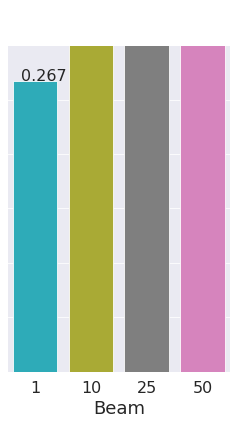

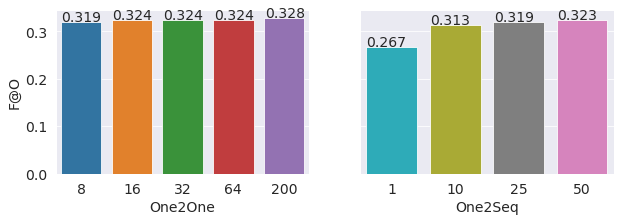

In [12]:
# plot One2One 
one2one_df = all_eval_df.loc[all_eval_df['exp_name'] == 'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1']
one2one_df = one2one_df.loc[(one2one_df.step % 10000 == 6000) | (one2one_df.step % 5000 == 0)] # keep % 10000 and 5000
one2one_df['beam_width'] = one2one_df['beam_width'].astype(int)
one2one_df = one2one_df.sort_values(by=['beam_width', 'step'], ascending=True)

for index_label, row_series in one2one_df.iterrows():
    one2one_df.at[index_label , 'exp_name'] = 'One2One-beam%s' % one2one_df.at[index_label , 'beam_width']

_, _, valid_one2one_df, _ = brief_eval_results(one2one_df, base_metric='present_exact_f_score@k') 

metric_names = ['present_exact_f_score@k']

datasets = valid_one2one_df.test_dataset.unique()
beam_widths = one2one_df.beam_width.unique()

bar_values = {beam_width: [] for beam_width in beam_widths for metric_name in metric_names}

for index_label, row_series in valid_one2one_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values[row_series.beam_width].append(float(bar_value))

avg_bar_values = {'Beam': [], 'F@O': [], 'model': []}
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    avg_bar_values['Beam'].append(int(k))
    avg_bar_values['F@O'].append(np.mean(_v))
    avg_bar_values['model'].append('RNN')

df = pd.DataFrame.from_dict(avg_bar_values)
display(df)
'''
plt.figure(figsize=(5,6))
sns.set_palette("tab10", n_colors=10)
ax = sns.barplot(x="Beam", y="F@10", data=df)
ax.set_ylim(0, 0.3)
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() + 0.15, p.get_height() * 1.005))   
'''
import copy
rnn_one2one_present_df = copy.copy(df)






# plot One2Seq
one2seq_df = all_eval_df.loc[all_eval_df['exp_name'] == 'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1']
one2seq_df['beam_width'] = one2seq_df['beam_width'].astype(int)
one2seq_df = one2seq_df.sort_values(by=['beam_width', 'step'], ascending=True)
one2seq_df = one2seq_df.loc[one2seq_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating
one2seq_df = one2seq_df.loc[one2seq_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam

for index_label, row_series in one2seq_df.iterrows():
    one2seq_df.at[index_label , 'exp_name'] = 'One2Seq-beam%s' % one2seq_df.at[index_label , 'beam_width']

_, _, valid_one2seq_df, _ = brief_eval_results(one2seq_df, base_metric='present_exact_f_score@k') 

# display(valid_one2seq_df)
metric_name = 'present_exact_f_score@k'

datasets = valid_one2seq_df.test_dataset.unique()
beam_widths = one2seq_df.beam_width.unique()

bar_values = {'%s' % (beam_width): [] for beam_width in beam_widths for metric_name in metric_names}

for index_label, row_series in valid_one2seq_df.iterrows():   
    bar_value = row_series[metric_name]
    bar_values['%s' % (row_series.beam_width)].append(float(bar_value))

# print(bar_values)
avg_bar_values = {'Beam': [], 'F@O': [], 'model': []}
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    avg_bar_values['Beam'].append(int(k))
    avg_bar_values['F@O'].append(np.mean(_v))
    avg_bar_values['model'].append('RNN')

# '''
print(avg_bar_values)

df = pd.DataFrame.from_dict(avg_bar_values)
display(df)
rnn_one2seq_present_df = copy.copy(df)

plt.figure(figsize=(4,6))
sns.set_palette("tab10_r", n_colors=10)

ax = sns.barplot(x="Beam", y="F@O", data=df)
ax.set_ylim(0, 0.3)
ax.set_yticklabels([])
ax.set_ylabel('')

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() + 0.15, p.get_height() * 1.005))   
# '''

sns.set_context("paper", rc={"font.size": 14,
                             "axes.titlesize": 14,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

f, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
sns.set_palette("tab10", n_colors=10)
sns.barplot(x="Beam", y="F@O", data=rnn_one2one_present_df, ax=axes[0])
# df1.plot.bar(ax=axes[0], legend=False, rot=0)
for p in axes[0].patches:
    axes[0].annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
axes[0].set_xlabel("One2One")

# df2.plot.bar(ax=axes[1], rot=0)
sns.set_palette("tab10_r", n_colors=10)
sns.barplot(x="Beam", y="F@O", data=rnn_one2seq_present_df, ax=axes[1])
for p in axes[1].patches:
    axes[1].annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))    
axes[1].set_xlabel("One2Seq") 
axes[1].set_ylabel("")




/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'Beam': [1, 10, 25, 50], 'R@50': [0.002497695838612458, 0.01140273249601975, 0.019286495093150988, 0.02459737124635035], 'model': ['RNN', 'RNN', 'RNN', 'RNN']}


Text(0, 0.5, '')

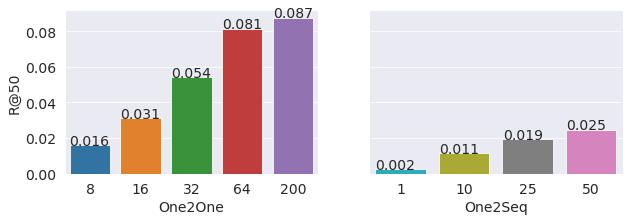

In [17]:
# plot One2One 
one2one_df = all_eval_df.loc[all_eval_df['exp_name'] == 'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1']
one2one_df = one2one_df.loc[(one2one_df.step % 10000 == 6000) | (one2one_df.step % 5000 == 0)] # keep % 10000 and 5000
one2one_df['beam_width'] = one2one_df['beam_width'].astype(int)
one2one_df = one2one_df.sort_values(by=['beam_width', 'step'], ascending=True)

for index_label, row_series in one2one_df.iterrows():
    one2one_df.at[index_label , 'exp_name'] = 'One2One-beam%s' % one2one_df.at[index_label , 'beam_width']

_, _, valid_one2one_df, _ = brief_eval_results(one2one_df, base_metric='absent_exact_recall@50') 

metric_names = ['absent_exact_recall@50']

datasets = valid_one2one_df.test_dataset.unique()
beam_widths = one2one_df.beam_width.unique()

bar_values = {beam_width: [] for beam_width in beam_widths for metric_name in metric_names}

for index_label, row_series in valid_one2one_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values[row_series.beam_width].append(float(bar_value))

avg_bar_values = {'Beam': [], 'R@50': [], 'model': []}
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    avg_bar_values['Beam'].append(int(k))
    avg_bar_values['R@50'].append(np.mean(_v))
    avg_bar_values['model'].append('RNN')
    

df = pd.DataFrame.from_dict(avg_bar_values)
# display(df)
'''
plt.figure(figsize=(5,6))
sns.set_palette("tab10", n_colors=10)
ax = sns.barplot(x="Beam", y="F@10", data=df)
ax.set_ylim(0, 0.3)
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() + 0.15, p.get_height() * 1.005))   
'''
import copy
rnn_one2one_absent_df = copy.copy(df)






# plot One2Seq
one2seq_df = all_eval_df.loc[all_eval_df['exp_name'] == 'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1']
one2seq_df['beam_width'] = one2seq_df['beam_width'].astype(int)
one2seq_df = one2seq_df.sort_values(by=['beam_width', 'step'], ascending=True)
one2seq_df = one2seq_df.loc[one2seq_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating
one2seq_df = one2seq_df.loc[one2seq_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam

for index_label, row_series in one2seq_df.iterrows():
    one2seq_df.at[index_label , 'exp_name'] = 'One2Seq-beam%s' % one2seq_df.at[index_label , 'beam_width']

_, _, valid_one2seq_df, _ = brief_eval_results(one2seq_df, base_metric='absent_exact_recall@50') 

# display(valid_one2seq_df)
metric_name = 'absent_exact_recall@50'

datasets = valid_one2seq_df.test_dataset.unique()
beam_widths = one2seq_df.beam_width.unique()

bar_values = {'%s' % (beam_width): [] for beam_width in beam_widths for metric_name in metric_names}

for index_label, row_series in valid_one2seq_df.iterrows():   
    bar_value = row_series[metric_name]
    bar_values['%s' % (row_series.beam_width)].append(float(bar_value))

# print(bar_values)
avg_bar_values = {'Beam': [], 'R@50': [], 'model': []}
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    avg_bar_values['Beam'].append(int(k))
    avg_bar_values['R@50'].append(np.mean(_v))
    avg_bar_values['model'].append('RNN')

print(avg_bar_values)

df = pd.DataFrame.from_dict(avg_bar_values)
# display(df)
rnn_one2seq_absent_df = copy.copy(df)

'''
plt.figure(figsize=(4,6))
sns.set_palette("tab10_r", n_colors=10)

ax = sns.barplot(x="Beam", y="F@10", data=df)
ax.set_ylim(0, 0.3)
ax.set_yticklabels([])
ax.set_ylabel('')

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() + 0.15, p.get_height() * 1.005))   
# '''

sns.set_context("paper", rc={"font.size": 14,
                             "axes.titlesize": 14,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

f, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
sns.set_palette("tab10", n_colors=10)
sns.barplot(x="Beam", y="R@50", data=rnn_one2one_absent_df, ax=axes[0])
# df1.plot.bar(ax=axes[0], legend=False, rot=0)
for p in axes[0].patches:
    axes[0].annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
axes[0].set_xlabel("One2One")

# df2.plot.bar(ax=axes[1], rot=0)
sns.set_palette("tab10_r", n_colors=10)
sns.barplot(x="Beam", y="R@50", data=rnn_one2seq_absent_df, ax=axes[1])
for p in axes[1].patches:
    axes[1].annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))    
axes[1].set_xlabel("One2Seq") 
axes[1].set_ylabel("")




Beam       F@O model
0  8     0.303891  TF  
1  16    0.311420  TF  
2  32    0.311312  TF  
3  64    0.311648  TF  
4  200   0.311682  TF

/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(1295, 236)
{'Beam': [1, 10, 25, 50], 'F@O': [0.2740236653246884, 0.3060720943414134, 0.3280425324930268, 0.3292538448836406], 'model': ['TF', 'TF', 'TF', 'TF']}


Beam       F@O model
0  1     0.274024  TF  
1  10    0.306072  TF  
2  25    0.328043  TF  
3  50    0.329254  TF

Text(0, 0.5, '')

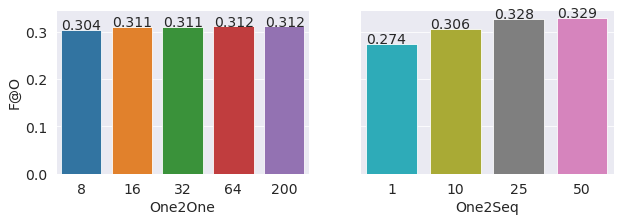

In [14]:
# plot One2One 
one2one_df = all_eval_df.loc[all_eval_df['exp_name'] == 'kpgen-meng17-kp20k-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue']
one2one_df = one2one_df.loc[(one2one_df.step % 10000 == 6000) | (one2one_df.step % 5000 == 0)] # keep % 10000 and 5000
one2one_df['beam_width'] = one2one_df['beam_width'].astype(int)
one2one_df = one2one_df.sort_values(by=['beam_width', 'step'], ascending=True)

for index_label, row_series in one2one_df.iterrows():
    one2one_df.at[index_label , 'exp_name'] = 'One2One-beam%s' % one2one_df.at[index_label , 'beam_width']

_, _, valid_one2one_df, _ = brief_eval_results(one2one_df, base_metric='present_exact_f_score@k') 

metric_names = ['present_exact_f_score@k']

datasets = valid_one2one_df.test_dataset.unique()
beam_widths = one2one_df.beam_width.unique()

bar_values = {beam_width: [] for beam_width in beam_widths for metric_name in metric_names}

for index_label, row_series in valid_one2one_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values[row_series.beam_width].append(float(bar_value))

avg_bar_values = {'Beam': [], 'F@O': [], 'model': []}
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    avg_bar_values['Beam'].append(int(k))
    avg_bar_values['F@O'].append(np.mean(_v))
    avg_bar_values['model'].append('TF')

df = pd.DataFrame.from_dict(avg_bar_values)
display(df)
'''
plt.figure(figsize=(5,6))
sns.set_palette("tab10", n_colors=10)
ax = sns.barplot(x="Beam", y="F@10", data=df)
ax.set_ylim(0, 0.3)
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() + 0.15, p.get_height() * 1.005))   
'''
import copy
tf_one2one_present_df = copy.copy(df)





# plot One2Seq
one2seq_df = all_eval_df.loc[all_eval_df['exp_name'] == 'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue']
one2seq_df['beam_width'] = one2seq_df['beam_width'].astype(int)
one2seq_df = one2seq_df.sort_values(by=['beam_width', 'step'], ascending=True)
one2seq_df = one2seq_df.loc[one2seq_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating
one2seq_df = one2seq_df.loc[one2seq_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam
# one2seq_df = one2seq_df.loc[(one2seq_df.step >= 100000) | (one2seq_df.beam_width == 50) | (one2seq_df.beam_width == 1)] # a workaround, some kp20k results are missing

print(one2seq_df.shape)
# a workaround, some kp20k results are missing
# beam_step_TBR = []
# for beam_width in one2seq_df['beam_width'].unique():
# #     print('beam_width=', beam_width)
#     beam_df = one2seq_df.loc[one2seq_df.beam_width == beam_width]
#     for step in one2seq_df['step'].unique():
#         step_df = one2seq_df.loc[one2seq_df.step == step]
#         print('beam=%d, step=%d, #(dataset)=%d, step_df.shape=%s'
#               % (beam_width, step, len(step_df.test_dataset.unique()), step_df.shape))
        
#         if len(step_df.test_dataset.unique()) < 7:
#             print('remove! ', (beam_width, step, step_df.shape[0]))
#             beam_step_TBR.append((beam_width, step, step_df.shape[0]))

# # some rows cannot be detected by df_TBR, don't know why!
# for beam_width, step, num_dp in beam_step_TBR:
#     df_TBR = one2seq_df.loc[(one2seq_df['beam_width'] == beam_width) & (one2seq_df['step'] == step)]
#     print('Removing: ', (beam_width, step, step_df.shape[0]), ' \t Found:', df_TBR.shape[0])
#     one2seq_df.drop(df_TBR.index, inplace = True) 
#     print(one2seq_df.shape)

for index_label, row_series in one2seq_df.iterrows():
    one2seq_df.at[index_label , 'exp_name'] = 'One2Seq-beam%s' % one2seq_df.at[index_label , 'beam_width']

_, _, valid_one2seq_df, _ = brief_eval_results(one2seq_df, base_metric='present_exact_f_score@k') 

# display(valid_one2seq_df)
metric_name = 'present_exact_f_score@k'

datasets = valid_one2seq_df.test_dataset.unique()
beam_widths = one2seq_df.beam_width.unique()

bar_values = {'%s' % (beam_width): [] for beam_width in beam_widths for metric_name in metric_names}

for index_label, row_series in valid_one2seq_df.iterrows():   
    bar_value = row_series[metric_name]
    bar_values['%s' % (row_series.beam_width)].append(float(bar_value))

# print(bar_values)
avg_bar_values = {'Beam': [], 'F@O': [], 'model': []}
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    avg_bar_values['Beam'].append(int(k))
    avg_bar_values['F@O'].append(np.mean(_v))
    avg_bar_values['model'].append('TF')

print(avg_bar_values)

df = pd.DataFrame.from_dict(avg_bar_values)
display(df)
tf_one2seq_present_df = copy.copy(df)

'''
plt.figure(figsize=(4,6))
sns.set_palette("tab10_r", n_colors=10)

ax = sns.barplot(x="Beam", y="F@10", data=df)
ax.set_ylim(0, 0.3)
ax.set_yticklabels([])
ax.set_ylabel('')

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() + 0.15, p.get_height() * 1.005))   
'''



sns.set_context("paper", rc={"font.size": 14,
                             "axes.titlesize": 14,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

f, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
sns.set_palette("tab10", n_colors=10)
sns.barplot(x="Beam", y="F@O", data=tf_one2one_present_df, ax=axes[0])
# df1.plot.bar(ax=axes[0], legend=False, rot=0)
for p in axes[0].patches:
    axes[0].annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
axes[0].set_xlabel("One2One")

# df2.plot.bar(ax=axes[1], rot=0)
sns.set_palette("tab10_r", n_colors=10)
sns.barplot(x="Beam", y="F@O", data=tf_one2seq_present_df, ax=axes[1])
for p in axes[1].patches:
    axes[1].annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))    
axes[1].set_xlabel("One2Seq") 
axes[1].set_ylabel("")




/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


{'Beam': [1, 10, 25, 50], 'R@50': [0.013290150897522368, 0.05982099588811556, 0.07951483220487852, 0.09848689000693868], 'model': ['TF', 'TF', 'TF', 'TF']}


Text(0, 0.5, '')

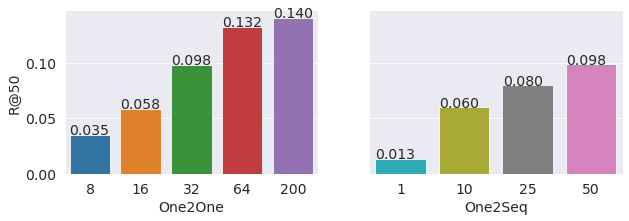

In [16]:
# plot One2One 
one2one_df = all_eval_df.loc[all_eval_df['exp_name'] == 'kpgen-meng17-kp20k-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue']
one2one_df = one2one_df.loc[(one2one_df.step % 10000 == 6000) | (one2one_df.step % 5000 == 0)] # keep % 10000 and 5000
one2one_df['beam_width'] = one2one_df['beam_width'].astype(int)
one2one_df = one2one_df.sort_values(by=['beam_width', 'step'], ascending=True)

for index_label, row_series in one2one_df.iterrows():
    one2one_df.at[index_label , 'exp_name'] = 'One2One-beam%s' % one2one_df.at[index_label , 'beam_width']

_, _, valid_one2one_df, _ = brief_eval_results(one2one_df, base_metric='absent_exact_recall@50') 

metric_names = ['absent_exact_recall@50']

datasets = valid_one2one_df.test_dataset.unique()
beam_widths = one2one_df.beam_width.unique()

bar_values = {beam_width: [] for beam_width in beam_widths for metric_name in metric_names}

for index_label, row_series in valid_one2one_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values[row_series.beam_width].append(float(bar_value))

avg_bar_values = {'Beam': [], 'R@50': [], 'model': []}
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    avg_bar_values['Beam'].append(int(k))
    avg_bar_values['R@50'].append(np.mean(_v))
    avg_bar_values['model'].append('TF')

df = pd.DataFrame.from_dict(avg_bar_values)
# display(df)
'''
plt.figure(figsize=(5,6))
sns.set_palette("tab10", n_colors=10)
ax = sns.barplot(x="Beam", y="F@10", data=df)
ax.set_ylim(0, 0.3)
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() + 0.15, p.get_height() * 1.005))   
'''
import copy
tf_one2one_absent_df = copy.copy(df)






# plot One2Seq
one2seq_df = all_eval_df.loc[all_eval_df['exp_name'] == 'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue']
one2seq_df['beam_width'] = one2seq_df['beam_width'].astype(int)
one2seq_df = one2seq_df.sort_values(by=['beam_width', 'step'], ascending=True)
one2seq_df = one2seq_df.loc[one2seq_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating
one2seq_df = one2seq_df.loc[one2seq_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam

for index_label, row_series in one2seq_df.iterrows():
    one2seq_df.at[index_label , 'exp_name'] = 'One2Seq-beam%s' % one2seq_df.at[index_label , 'beam_width']

_, _, valid_one2seq_df, _ = brief_eval_results(one2seq_df, base_metric='absent_exact_recall@50') 

# display(valid_one2seq_df)
metric_name = 'absent_exact_recall@50'

datasets = valid_one2seq_df.test_dataset.unique()
beam_widths = one2seq_df.beam_width.unique()

bar_values = {'%s' % (beam_width): [] for beam_width in beam_widths for metric_name in metric_names}

for index_label, row_series in valid_one2seq_df.iterrows():   
    bar_value = row_series[metric_name]
    bar_values['%s' % (row_series.beam_width)].append(float(bar_value))

# print(bar_values)
avg_bar_values = {'Beam': [], 'R@50': [], 'model': []}
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    avg_bar_values['Beam'].append(int(k))
    avg_bar_values['R@50'].append(np.mean(_v))
    avg_bar_values['model'].append('TF')

print(avg_bar_values)

df = pd.DataFrame.from_dict(avg_bar_values)
# display(df)
tf_one2seq_absent_df = copy.copy(df)

'''
plt.figure(figsize=(4,6))
sns.set_palette("tab10_r", n_colors=10)

ax = sns.barplot(x="Beam", y="F@10", data=df)
ax.set_ylim(0, 0.3)
ax.set_yticklabels([])
ax.set_ylabel('')

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() + 0.15, p.get_height() * 1.005))   
# '''

sns.set_context("paper", rc={"font.size": 14,
                             "axes.titlesize": 14,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

f, axes = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
sns.set_palette("tab10", n_colors=10)
sns.barplot(x="Beam", y="R@50", data=tf_one2one_absent_df, ax=axes[0])
# df1.plot.bar(ax=axes[0], legend=False, rot=0)
for p in axes[0].patches:
    axes[0].annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
axes[0].set_xlabel("One2One")

# df2.plot.bar(ax=axes[1], rot=0)
sns.set_palette("tab10_r", n_colors=10)
sns.barplot(x="Beam", y="R@50", data=tf_one2seq_absent_df, ax=axes[1])
for p in axes[1].patches:
    axes[1].annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))    
axes[1].set_xlabel("One2Seq") 
axes[1].set_ylabel("")




### Combine all (Appendix C2, Figure 8)

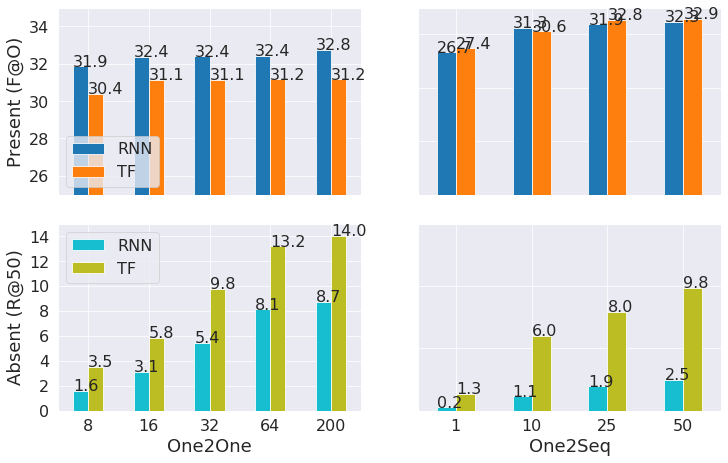

In [18]:
sns.set_context("paper", rc={"font.size": 16,
                             "axes.titlesize": 18,
                             "axes.labelsize": 18,
                             "xtick.labelsize": 16,
                             "ytick.labelsize": 16,
                             "legend.fontsize": 16})

sns.set_palette("tab10", n_colors=10)

f, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=False, sharey=False)
f.tight_layout(pad=0.0)
model_names = ['RNN', 'TF']
one2one_beams = [8, 16, 32, 64, 200]
one2seq_beams = [1, 10, 25, 50]

# one2one_present
concat_df = pd.concat([rnn_one2one_present_df, tf_one2one_present_df], ignore_index=True, sort=False)
# display(one2one_present_df)
avg_bar_values = {model_name: [0.0]*len(one2one_beams) for model_name in model_names}
for index_label, row_series in concat_df.iterrows():   
    avg_bar_values[row_series.model][one2one_beams.index(row_series.Beam)] = float(row_series['F@O'])
concat_df = pd.DataFrame(avg_bar_values, index=one2one_beams)
concat_df = concat_df * 100.0
# display(one2one_present_df)
g = concat_df.plot.bar(ax=axes[0][0], legend=True, rot=0)

for p in axes[0][0].patches:
    axes[0][0].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.001, p.get_height() + 0.005), rotation=0)   
axes[0][0].set_ylabel("Present (F@O)")
axes[0][0].legend(loc='lower left')
g.set_ylim(25, 35)
g.set(xticklabels=[])




# one2seq_present
concat_df = pd.concat([rnn_one2seq_present_df, tf_one2seq_present_df], ignore_index=True, sort=False)
avg_bar_values = {model_name: [0.0]*len(one2seq_beams) for model_name in model_names}
for index_label, row_series in concat_df.iterrows():   
    avg_bar_values[row_series.model][one2seq_beams.index(row_series.Beam)] = float(row_series['F@O'])
concat_df = pd.DataFrame(avg_bar_values, index=one2seq_beams)
concat_df = concat_df * 100.0
g = concat_df.plot.bar(ax=axes[0][1], legend=False, rot=0)

for p in axes[0][1].patches:
    axes[0][1].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.001, p.get_height() + 0.01), rotation=0)   
g.set_ylim(0, 35)
g.set(yticklabels=[])
# g.set(yticks=[])
g.set(xticklabels=[])
g.set(ylabel=None)




sns.set_palette("tab10_r", n_colors=10)
# one2one_absent
concat_df = pd.concat([rnn_one2one_absent_df, tf_one2one_absent_df], ignore_index=True, sort=False)
avg_bar_values = {model_name: [0.0]*len(one2one_beams) for model_name in model_names}
for index_label, row_series in concat_df.iterrows():   
    avg_bar_values[row_series.model][one2one_beams.index(row_series.Beam)] = float(row_series['R@50'])
concat_df = pd.DataFrame(avg_bar_values, index=one2one_beams)
concat_df = concat_df * 100.0
g = concat_df.plot.bar(ax=axes[1][0], legend=False, rot=0)

for p in axes[1][0].patches:
    axes[1][0].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.001, p.get_height() + 0.005), rotation=0)   
axes[1][0].set_ylabel("Absent (R@50)")
axes[1][0].set_xlabel("One2One")
axes[1][0].legend(loc='upper left')
g.set_ylim(0, 15)





# one2seq_absent
concat_df = pd.concat([rnn_one2seq_absent_df, tf_one2seq_absent_df], ignore_index=True, sort=False)
avg_bar_values = {model_name: [0.0]*len(one2seq_beams) for model_name in model_names}
for index_label, row_series in concat_df.iterrows():   
    avg_bar_values[row_series.model][one2seq_beams.index(row_series.Beam)] = float(row_series['R@50'])
concat_df = pd.DataFrame(avg_bar_values, index=one2seq_beams)
concat_df = concat_df * 100.0
g = concat_df.plot.bar(ax=axes[1][1], legend=False, rot=0)

for p in axes[1][1].patches:
    axes[1][1].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.001, p.get_height() + 0.01), rotation=0)   
# axes[1][1].set_ylabel("One2Seq Absent (R@50)")
axes[1][1].set_xlabel("One2Seq")
g.set(yticklabels=[])
# g.set(yticks=[])
# g.set(ylabel=None)
g.set_ylim(0, 15)


from matplotlib.ticker import MaxNLocator
axes[1][0].yaxis.set_major_locator(MaxNLocator(integer=True))

## Effect of Architecture

#### One2One

kp20k-meng17-one2one-BS128-LR0.05-L1-D150-E100-DO0.0-Copyfalse-Covfalse - [7]['kp20k_valid2k' 'nus' 'semeval' 'kp20k' 'inspec' 'duc' 'krapivin']
(280, 121)
kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1 - [7]['semeval' 'kp20k_valid2k' 'krapivin' 'inspec' 'duc' 'nus' 'kp20k']
(911, 121)
kp20k-meng17-one2one-BS128-LR0.05-L1-D150-E100-DO0.0-Copyfalse-Covfalse - present_exact_f_score_hard@10 = 7
kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1 - present_exact_f_score_hard@10 = 7
['duc' 'inspec' 'kp20k' 'kp20k_valid2k' 'krapivin' 'nus' 'semeval'
 'Average']
{'kp20k-meng17-one2one-BS128-LR0.05-L1-D150-E100-DO0.0-Copyfalse-Covfalse - present_exact_f_score_hard@10': [0.00032467532467532473, 0.04039430353823858, 0.06842784980073414, 0.06873645721741518, 0.04685716433495115, 0.10031317913118709, 0.07364274609978945, 0.05695662506385585], 'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb

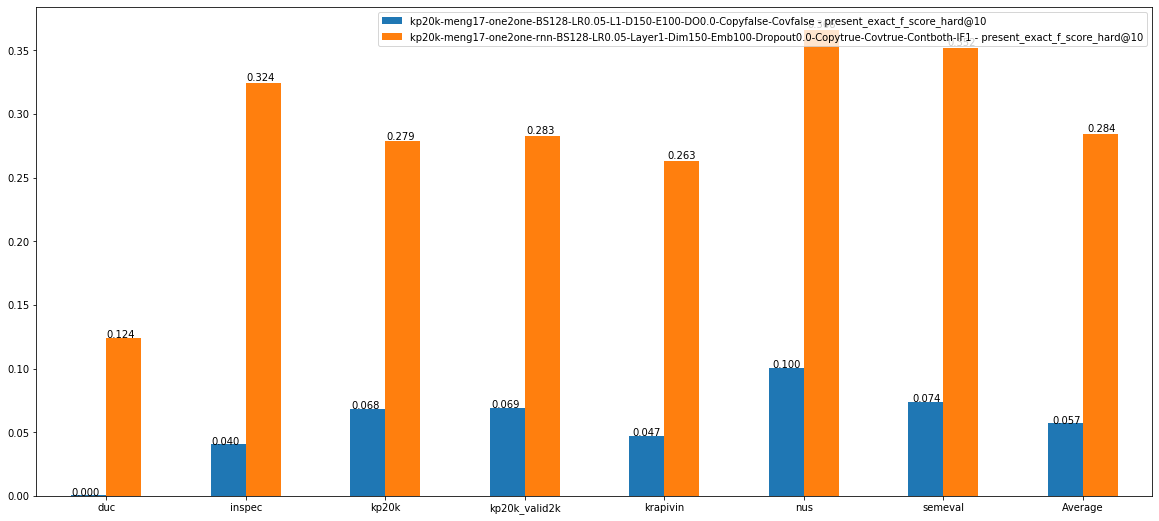

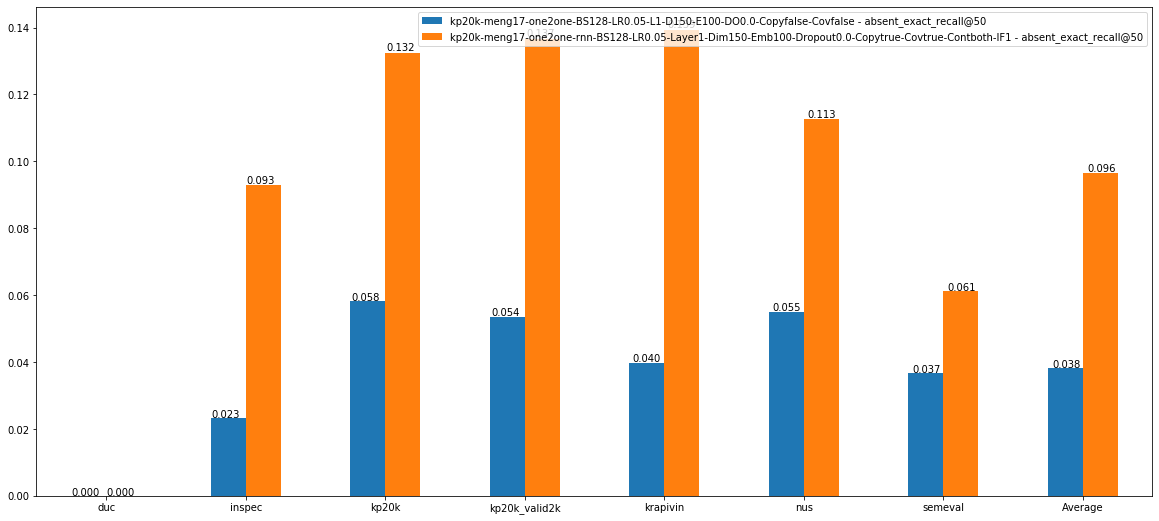

In [46]:
one2one_exps = [
#                 'kp20k-meng17-one2one-rnn-BS128-Layer1-Dim100-Emb100-Dropout0.0-Copytrue-Covfalse-Contboth-IF1',
#                 'kp20k-meng17-one2one-rnn-BS128-Layer1-Dim100-Emb100-Dropout0.25-Copytrue-Covtrue-Contboth-IF1',
#                 'kp20k-meng17-one2one-rnn-BS128-Layer1-Dim100-Emb100-Dropout0.5-Copytrue-Covtrue-Contboth-IF1',

#                 'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1',
# #                 'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covfalse-Contboth-IF1',
#                 'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.25-Copytrue-Covtrue-Contboth-IF1',
    
# This is baseline
# 'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1'
    
'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1',
'kp20k-meng17-one2one-BS128-LR0.05-L1-D150-E100-DO0.0-Copyfalse-Covfalse',
    
'kp20k-meng17-one2one-rnn-BS128-Layer1-Dim100-Emb100-Dropout0.0-Copytrue-Covfalse-Contboth-IF1',
'kp20k-meng17-one2one-rnn-BS128-Layer1-Dim100-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1',
# 'kp20k-meng17-one2one-rnn-BS128-Layer1-Dim100-Emb100-Dropout0.25-Copytrue-Covtrue-Contboth-IF1',
# 'kp20k-meng17-one2one-rnn-BS128-Layer1-Dim100-Emb100-Dropout0.5-Copytrue-Covtrue-Contboth-IF1',

# 'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copyfalse-Covfalse-Contboth-IF1', # does not exist
'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covfalse-Contboth-IF1',
# 'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.25-Copytrue-Covtrue-Contboth-IF1',
'kp20k-meng17-one2one-BS128-LR0.05-L1-H8-D512-E128-DO0.1-Copytrue',

'kp20k-meng17-one2one-transformer-BS4096-LR0.05-L2-H4-D128-E128-DO0.1-Copytrue',
# 'kp20k-meng17-one2one-transformer-BS4096-LR0.05-L4-H8-D128-E128-DO0.1-Copytrue',
'kp20k-meng17-one2one-transformer-BS4096-LR0.05-L4-H8-D512-E512-DO0.1-Copytrue',
'kp20k-meng17-one2one-transformer-BS4096-LR0.05-L6-H8-D512-E512-DO0.1-Copytrue'
               ]

one2one_df = all_eval_df.loc[all_eval_df['exp_name'].isin(one2one_exps)]


for exp_name, exp_group in one2one_df.groupby('exp_name'):
    datasets = exp_group.test_dataset.unique()
    print('%s - [%d]%s' % (exp_name, len(datasets), datasets))
    print(exp_group.shape)


one2one_df = one2one_df.sort_values(by='step', ascending=True)
one2one_df = one2one_df.loc[one2one_df.step % 10000 == 0] # keep % 10000
one2one_df = one2one_df.loc[one2one_df.beam_width == '200']
# remove kp20k because we didn't run it for other exps
# one2one_df = one2one_df.loc[one2one_df.test_dataset != 'kp20k']

for index_label, row_series in one2one_df.iterrows():
    one2one_df.at[index_label , 'exp_name'] = '%s' % (one2one_df.at[index_label , 'exp_name'])

_, peak_one2one_df, valid_one2one_df = brief_eval_results(one2one_df, base_metric='present_exact_f_score_hard@10')

# ensure the dataframe is sorted first
# display(peak_one2one_df)
# print(peak_one2one_df.shape)

# metric_names = ['present_exact_f_score_hard@5', 'present_exact_f_score_hard@10', 'present_exact_f_score_hard@k', 'present_exact_f_score_hard@M']
metric_names = ['present_exact_f_score_hard@5', 'present_exact_f_score_hard@10']
metric_names = ['present_exact_f_score_hard@10']

datasets = valid_one2one_df.test_dataset.unique()
exp_names = valid_one2one_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}

for index_label, row_series in valid_one2one_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

for k,v in bar_values.items():
    print('%s = %d' % (k, len(v)))
    
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')


print(datasets)
print(bar_values)
for k,v in bar_values.items():
    print('%s = %d' % (k, len(v)))
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   

    
    
###### Absent 
_, peak_one2one_df, valid_one2one_df = brief_eval_results(one2one_df, base_metric='absent_exact_recall@50')

# ensure the dataframe is sorted first
# display(peak_one2one_df)
# print(peak_one2one_df.shape)

metric_names = ['absent_exact_recall@50']

datasets = valid_one2one_df.test_dataset.unique()
exp_names = valid_one2one_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}

for index_label, row_series in valid_one2one_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

for k,v in bar_values.items():
    print('%s = %d' % (k, len(v)))
    
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')


print(datasets)
print(bar_values)
for k,v in bar_values.items():
    print('%s = %d' % (k, len(v)))
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   


#### One2Seq

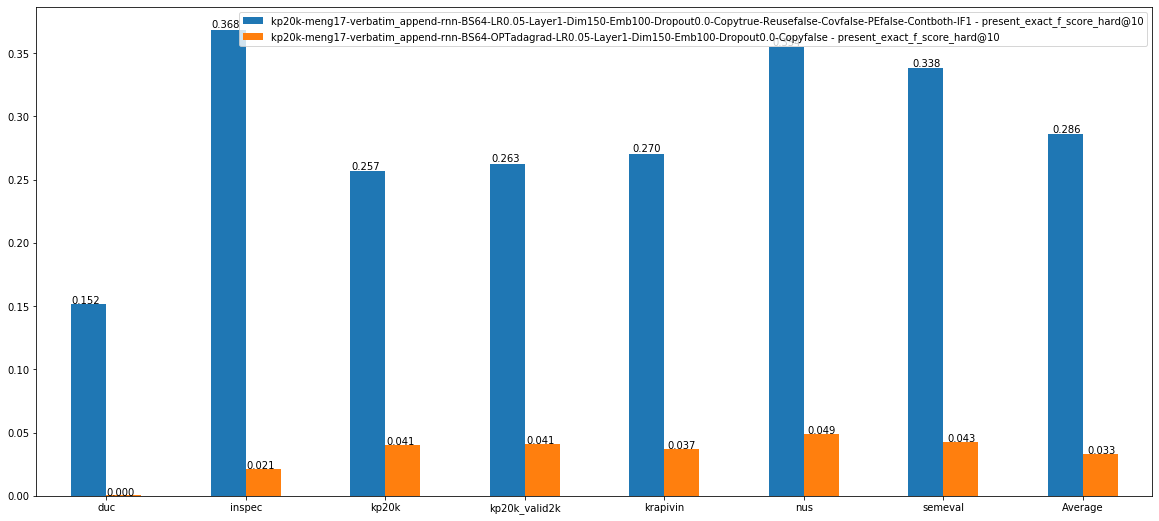

In [48]:
one2seq_exps = [
# this is baseline setting
# 'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1'
    
'kp20k-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copyfalse',
'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusefalse-Covfalse-PEfalse-Contboth-IF1',
   
'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1',

'kp20k-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim512-Emb128-Dropout0.1-Copytrue',
'kp20k-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim150-Emb100-Dropout0.1-Copytrue',
'kp20k-meng17-verbatim_append-rnn-BS64-LR0.002-Layer1-Dim512-Emb128-Dropout0.1-Copytrue',

'kp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L2-H4-Dim128-Emb128-Dropout0.1-Copytrue',
'kp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L4-H8-Dim512-Emb512-Dropout0.1-Copytrue',
'kp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue',

]

# prepare one2seq data
one2seq_df = all_eval_df.loc[all_eval_df['exp_name'].isin(one2seq_exps)]
one2seq_df = one2seq_df.loc[one2seq_df.step % 10000 == 0] # keep % 10000
one2seq_df = one2seq_df.sort_values(by='step', ascending=True)
one2seq_df = one2seq_df.loc[one2seq_df.beam_width == '50']
one2seq_df = one2seq_df.loc[one2seq_df.decoding_terminate == 'topbeamends'] # topbeamends/fullbeam
one2seq_df = one2seq_df.loc[one2seq_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating


# for exp_name, exp_group in one2seq_df.groupby('exp_name'):
#     datasets = exp_group.test_dataset.unique()
#     print('%s - [%d]%s' % (exp_name, len(datasets), datasets))
#     print(exp_group.shape)


_, peak_one2seq_df, valid_one2seq_df = brief_eval_results(one2seq_df, base_metric='present_exact_f_score_hard@10')

# ensure the dataframe is sorted first
# print(peak_one2seq_df.shape)
# display(peak_one2seq_df)

# metric_names = ['present_exact_f_score_hard@5', 'present_exact_f_score_hard@10', 'present_exact_f_score_hard@k', 'present_exact_f_score_hard@M']
# metric_names = ['present_exact_f_score_hard@5', 'present_exact_f_score_hard@10']
metric_names = ['present_exact_f_score_hard@10']


datasets = valid_one2seq_df.test_dataset.unique()
exp_names = valid_one2seq_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}

for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')

df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
    

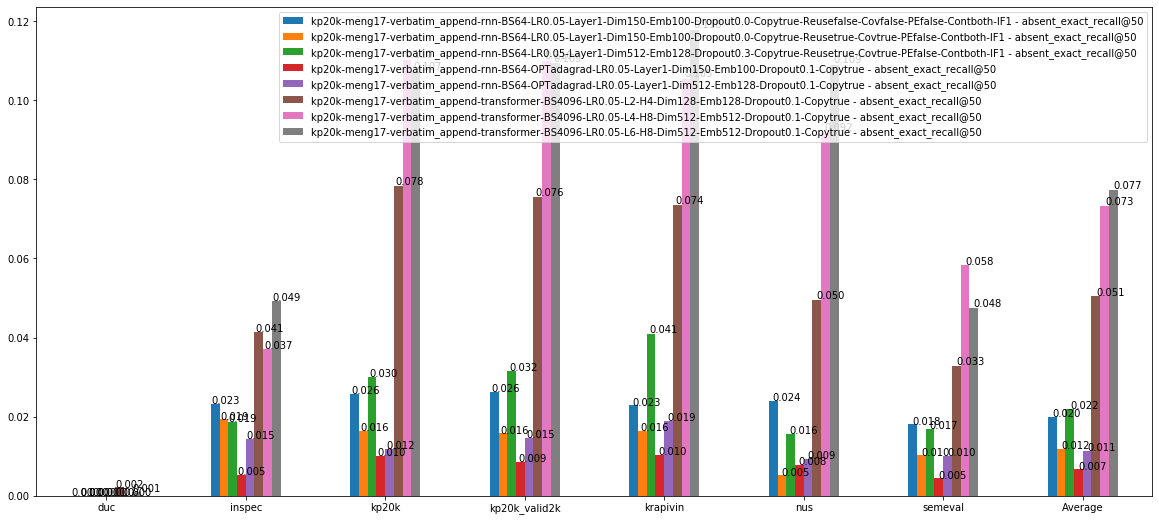

In [46]:
###### absent

one2seq_exps = [
'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusefalse-Covfalse-PEfalse-Contboth-IF1',
'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1',
'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim512-Emb128-Dropout0.3-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1',

# 'kp20k-meng17-verbatim_append-rnn-BS64-LR0.002-Layer1-Dim150-Emb100-Dropout0.1-Copytrue',
'kp20k-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim512-Emb128-Dropout0.1-Copytrue',
'kp20k-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim150-Emb100-Dropout0.1-Copytrue',
# 'kp20k-meng17-verbatim_append-rnn-BS64-LR0.002-Layer1-Dim512-Emb128-Dropout0.1-Copytrue',

'kp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L2-H4-Dim128-Emb128-Dropout0.1-Copytrue',
'kp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L4-H8-Dim512-Emb512-Dropout0.1-Copytrue',
# 'kp20k-meng17-verbatim_append-transformer-BS4096-LR0.5-Layer4-Heads8-Dim512-Emb512-Dropout0.2-Copytrue-Reusetrue-Covtrue-PEtrue-Contextboth-IF1',
'kp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue',

]

# prepare one2seq data
one2seq_df = all_eval_df.loc[all_eval_df['exp_name'].isin(one2seq_exps)]
one2seq_df = one2seq_df.loc[one2seq_df.step % 10000 == 0] # keep % 10000
one2seq_df = one2seq_df.sort_values(by='step', ascending=True)
one2seq_df = one2seq_df.loc[one2seq_df.beam_width == '50']
one2seq_df = one2seq_df.loc[one2seq_df.decoding_terminate == 'topbeamends'] # topbeamends/fullbeam
one2seq_df = one2seq_df.loc[one2seq_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating

_, peak_one2seq_df, valid_one2seq_df = brief_eval_results(one2seq_df, base_metric='absent_exact_recall@50')

# ensure the dataframe is sorted first
# print(valid_one2seq_df.shape)
# display(valid_one2seq_df)

# metric_names = ['present_exact_f_score_hard@5', 'present_exact_f_score_hard@10', 'present_exact_f_score_hard@k', 'present_exact_f_score_hard@M']
# metric_names = ['present_exact_f_score_hard@5', 'present_exact_f_score_hard@10']
metric_names = ['absent_exact_recall@50']


datasets = valid_one2seq_df.test_dataset.unique()
exp_names = valid_one2seq_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}

for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')

df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
    

## Effect of More Data

### For One2One

kp20k-meng17-one2one-BS128-LR0.05-L1-H8-D512-E128-DO0.1-Copytrue - shape=(7, 121) - testset: [7]['duc' 'inspec' 'kp20k' 'kp20k_valid2k' 'krapivin' 'nus' 'semeval']
kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1 - shape=(7, 121) - testset: [7]['duc' 'inspec' 'kp20k' 'kp20k_valid2k' 'krapivin' 'nus' 'semeval']
kp20k-meng17-one2one-transformer-BS4096-LR0.05-L6-H8-D512-E512-DO0.1-Copytrue - shape=(7, 121) - testset: [7]['duc' 'inspec' 'kp20k' 'kp20k_valid2k' 'krapivin' 'nus' 'semeval']
magkp20k-meng17-one2one-BS128-LR0.05-L1-D512-E128-DO0.1-Copytrue - shape=(7, 121) - testset: [7]['duc' 'inspec' 'kp20k' 'kp20k_valid2k' 'krapivin' 'nus' 'semeval']
magkp20k-meng17-one2one-BS128-LR0.05-L1-H-D150-E100-DO0.0-Copytrue - shape=(7, 121) - testset: [7]['duc' 'inspec' 'kp20k' 'kp20k_valid2k' 'krapivin' 'nus' 'semeval']
magkp20k-meng17-one2one-transformer-BS4096-LR0.05-L6-H8-D512-E512-DO0.1-Copytrue - shape=(7, 121) - testset: [7]['duc' 'inspec' 'k

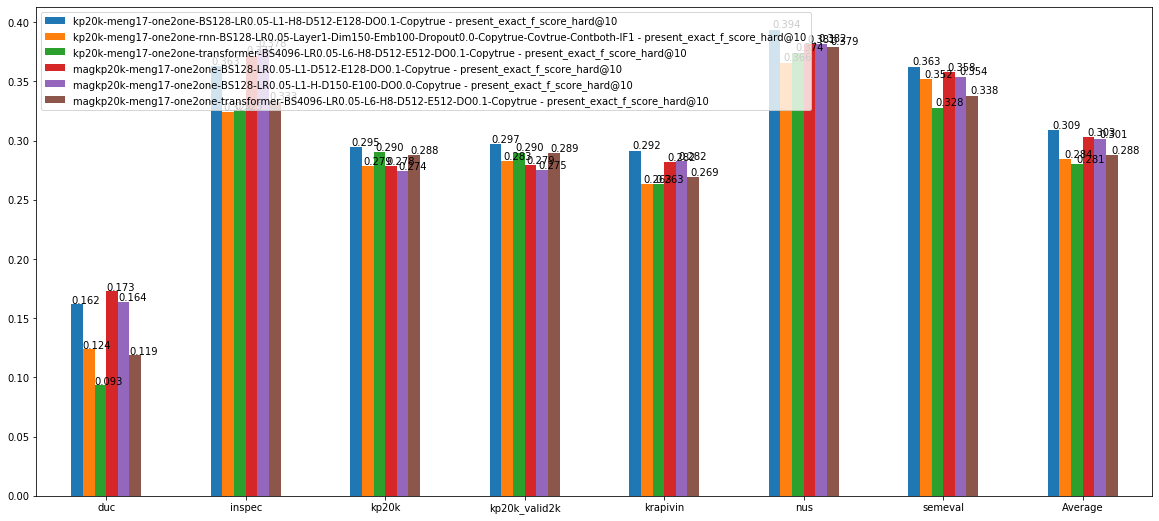

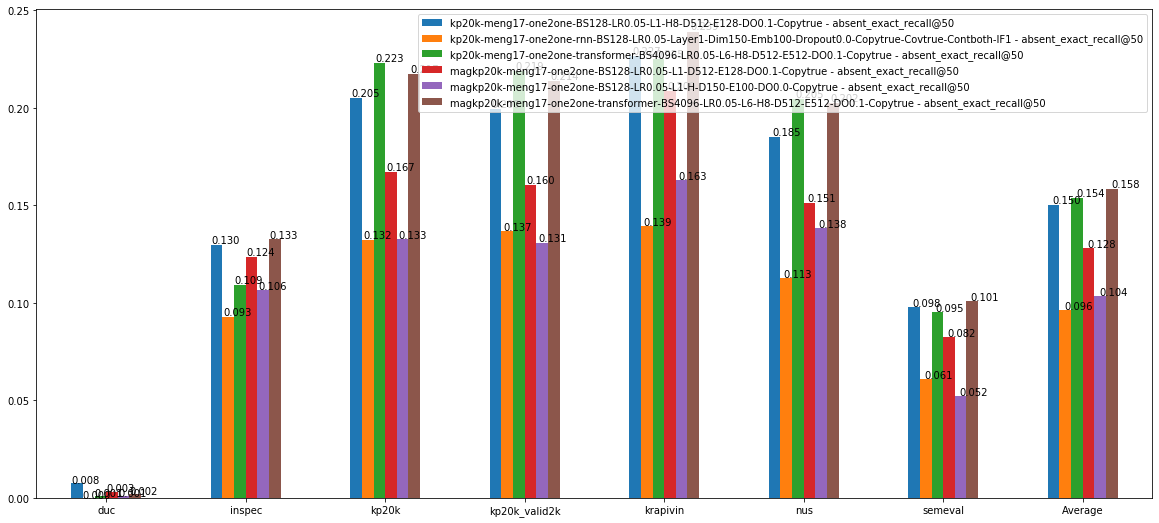

In [9]:
one2one_exps = [
# This is baseline
# 'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1'

# 'kp20k-meng17-one2one-rnn-BS128-Layer1-Dim100-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1',
# 'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1',
'kp20k-meng17-one2one-BS128-LR0.05-L1-H8-D512-E128-DO0.1-Copytrue',

# 'kp20k-meng17-one2one-transformer-BS4096-LR0.05-L2-H4-D128-E128-DO0.1-Copytrue',
# 'kp20k-meng17-one2one-transformer-BS4096-LR0.05-L4-H8-D512-E512-DO0.1-Copytrue',
# 'kp20k-meng17-one2one-transformer-BS4096-LR0.05-L6-H8-D512-E512-DO0.1-Copytrue',
    

# 'magkp-meng17-one2one-BS128-LR0.002-L1-H-D150-E100-DO0.0-Copytrue',
# 'magkp-meng17-one2one-BS128-LR0.002-L1-H-D150-E100-DO0.1-Copytrue',
# 'magkp-meng17-one2one-BS128-OPTadagrad-LR0.05-L1-H-D150-E100-DO0.0-Copytrue',
# 'magkp-meng17-one2one-transformer-BS4096-Layer2-Heads4-Dim128-Emb128-Dropout0.1-Copyfalse-Covfalse-Contextboth-IF1',
# 'magkp-meng17-one2one-transformer-BS4096-Layer2-Heads4-Dim128-Emb128-Dropout0.1-Copytrue-Covfalse-Contextboth-IF1',
# 'magkp-meng17-one2one-transformer-BS4096-Layer2-Heads4-Dim128-Emb128-Dropout0.1-Copytrue-Covtrue-Contextboth-IF1',
# 'magkp-meng17-one2one-transformer-BS4096-Layer4-Heads8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue-Contextboth-IF1',
# still running'magkp-meng17-one2one-transformer-BS4096-Layer6-Heads8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue-Contextboth-IF1',

# 'magkp20k-meng17-one2one-BS128-LR0.05-L1-H-D150-E100-DO0.0-Copytrue',
'magkp20k-meng17-one2one-BS128-LR0.05-L1-D512-E128-DO0.1-Copytrue',
# 'magkp20k-meng17-one2one-transformer-BS4096-LR0.05-L6-H8-D512-E512-DO0.1-Copytrue',

# no kp20k
# 'magkp-meng17-one2one-transformer-BS4096-Layer2-Heads4-Dim128-Emb128-Dropout0.0-Copytrue-Covtrue-Contextboth-IF1',
# 'magkp-meng17-one2one-transformer-BS4096-Layer2-Heads4-Dim128-Emb128-Dropout0.5-Copytrue-Covtrue-Contextboth-IF1',
# 'magkp-meng17-one2one-transformer-BS4096-Layer4-Heads8-Dim128-Emb128-Dropout0.1-Copytrue-Covtrue-Contextboth-IF1',
]

one2one_df = all_eval_df.loc[all_eval_df['exp_name'].isin(one2one_exps)]
one2one_df = one2one_df.sort_values(by='step', ascending=True)
one2one_df = one2one_df.loc[one2one_df.step % 10000 == 0] # keep % 10000
one2one_df = one2one_df.loc[one2one_df.beam_width == '200']
# remove kp20k because we didn't run it for other exps
# one2one_df = one2one_df.loc[one2one_df.test_dataset != 'kp20k']

# we have previous .eval files that @M is NaN
# one2one_df.drop_duplicates(keep=False,inplace=True) 
one2one_df = one2one_df.loc[one2one_df['present_exact_f_score@M'].notna()]


# for exp_name, exp_group in one2one_df.groupby('exp_name'):
#     datasets = exp_group.test_dataset.unique()
#     print('%s - [%d]%s' % (exp_name, len(datasets), datasets))


for index_label, row_series in one2one_df.iterrows():
    one2one_df.at[index_label , 'exp_name'] = '%s' % (one2one_df.at[index_label , 'exp_name'])

_, peak_one2one_df, valid_one2one_df = brief_eval_results(one2one_df, base_metric='present_exact_f_score_hard@10')

for exp_name, exp_group in valid_one2one_df.groupby('exp_name'):
    datasets = exp_group.test_dataset.unique()
    print('%s - shape=%s - testset: [%d]%s' % (exp_name, exp_group.shape, len(datasets), datasets))

# ensure the dataframe is sorted first
# display(peak_one2one_df)
# print(peak_one2one_df.shape)

# metric_names = ['present_exact_f_score_hard@5', 'present_exact_f_score_hard@10', 'present_exact_f_score_hard@k', 'present_exact_f_score_hard@M']
metric_names = ['present_exact_f_score_hard@5', 'present_exact_f_score_hard@10']
metric_names = ['present_exact_f_score_hard@10']

datasets = valid_one2one_df.test_dataset.unique()
exp_names = valid_one2one_df.exp_name.unique()

# print(datasets)
# print(exp_names)
# display(peak_one2one_df.loc[peak_one2one_df['exp_name'] == 'magkp-meng17-one2one-transformer-BS4096-Layer2-Heads4-Dim128-Emb128-Dropout0.1-Copytrue-Covtrue-Contextboth-IF1'])

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}

for index_label, row_series in valid_one2one_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

for k,v in bar_values.items():
    print('%s = %d' % (k, len(v)))
    
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')


print(datasets)
print(bar_values)
for k,v in bar_values.items():
    print('%s = %d' % (k, len(v)))
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   

    
    
###### Absent 
_, peak_one2one_df, valid_one2one_df = brief_eval_results(one2one_df, base_metric='absent_exact_recall@50')

# ensure the dataframe is sorted first
# display(peak_one2one_df)
# print(peak_one2one_df.shape)

metric_names = ['absent_exact_recall@50']

datasets = valid_one2one_df.test_dataset.unique()
exp_names = valid_one2one_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}

for index_label, row_series in valid_one2one_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

for k,v in bar_values.items():
    print('%s = %d' % (k, len(v)))
    
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')


print(datasets)
print(bar_values)
for k,v in bar_values.items():
    print('%s = %d' % (k, len(v)))
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   


### For One2Seq

    - On MagKP, all performance drops by large margin.

kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1 - present_exact_f_score_hard@10 = 7
kp20k-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim512-Emb128-Dropout0.1-Copytrue - present_exact_f_score_hard@10 = 7
kp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue - present_exact_f_score_hard@10 = 7
magkp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue - present_exact_f_score_hard@10 = 7
magkp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim512-Emb128-Dropout0.1-Copytrue-Covtrue - present_exact_f_score_hard@10 = 7
magkp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue - present_exact_f_score_hard@10 = 7
['duc' 'inspec' 'kp20k' 'kp20k_valid2k' 'krapivin' 'nus' 'semeval'
 'Average']
{'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-

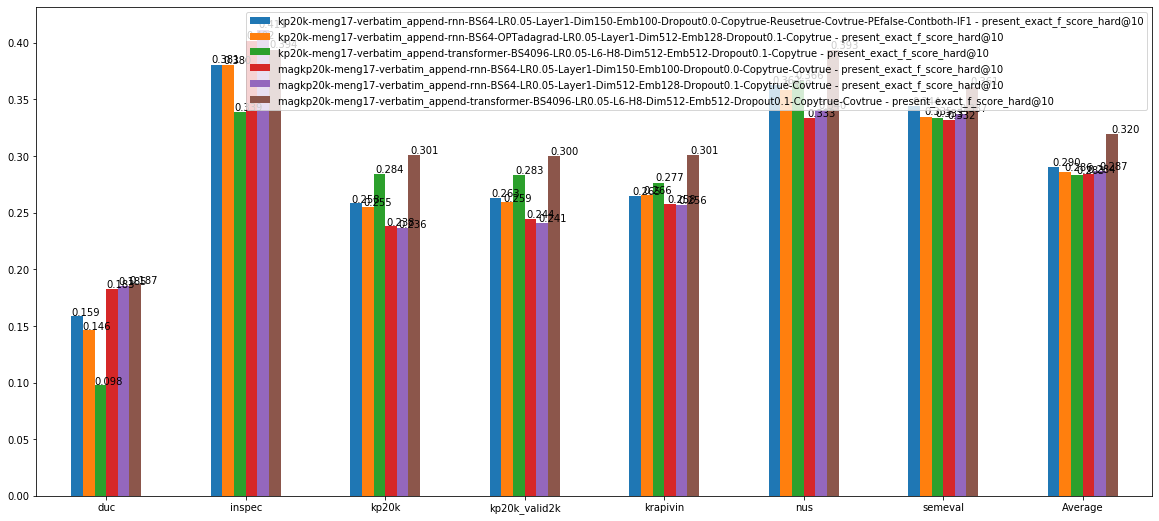

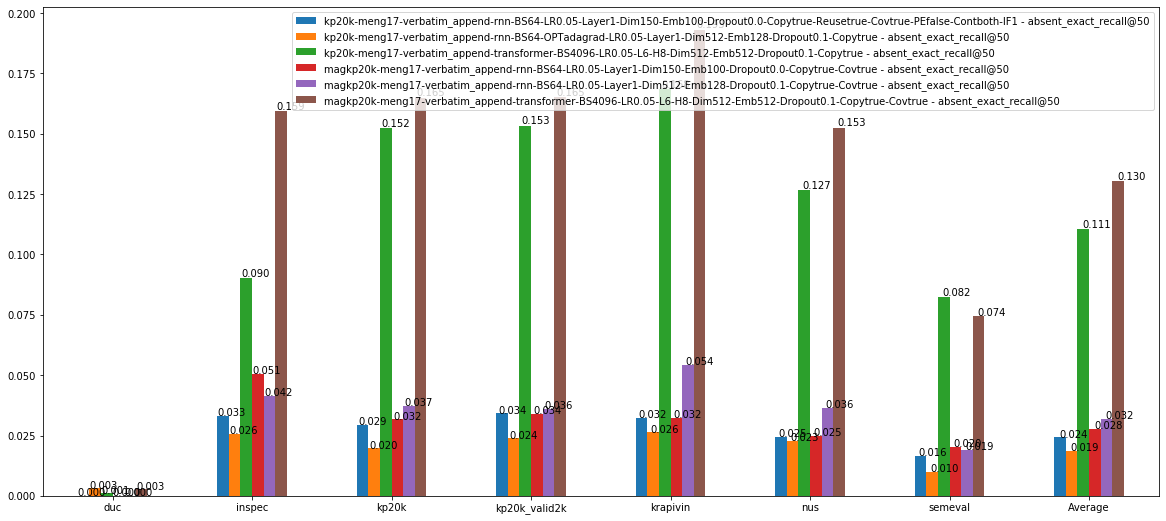

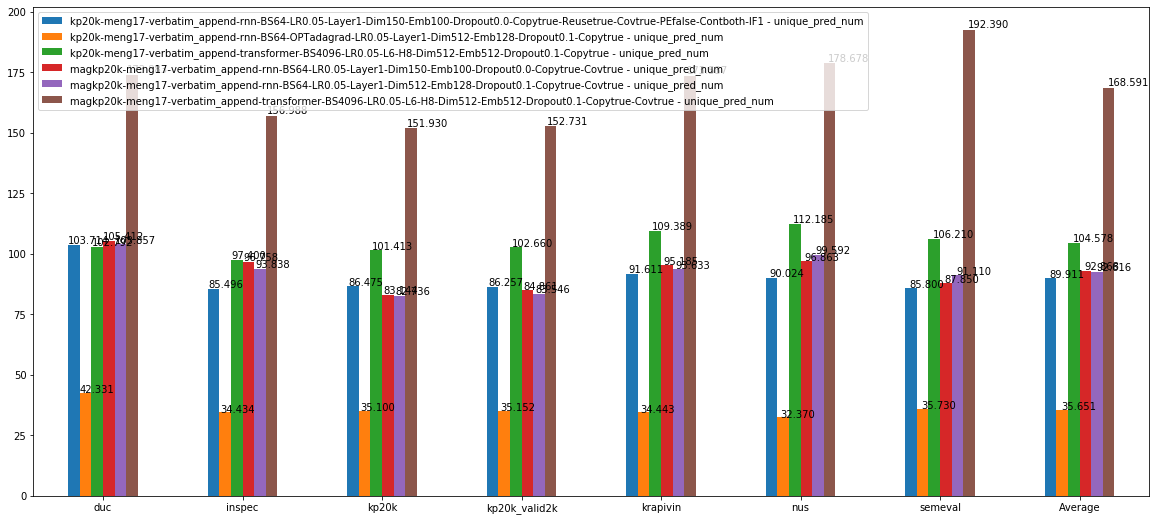

In [42]:
# Compare baseline One2Seq RNN model on different training data

one2seq_exps = [
                'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1', 
#                 'kp20k-meng17-verbatim_append-rnn-BS64-LR0.002-Layer1-Dim150-Emb100-Dropout0.1-Copytrue',
#                 'kp20k-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim150-Emb100-Dropout0.1-Copytrue',

                'kp20k-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim512-Emb128-Dropout0.1-Copytrue',
#                 'kp20k-meng17-verbatim_append-rnn-BS64-LR0.002-Layer1-Dim512-Emb128-Dropout0.1-Copytrue',
#                 'kp20k-meng17-verbatim_append-rnn-BS64-OPT-LR0.05-Layer1-Dim512-Emb128-Dropout0.1-Copytrue-Covtrue',
                
                'kp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue',

                'magkp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue',
                'magkp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim512-Emb128-Dropout0.1-Copytrue-Covtrue',
                'magkp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
               ]
'''
                # kp20k
                'kp20k-meng17-verbatim_append-rnn-BS64-LR0.002-Layer1-Dim150-Emb100-Dropout0.1-Copytrue',
                'kp20k-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim150-Emb100-Dropout0.1-Copytrue',

                'kp20k-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim512-Emb128-Dropout0.1-Copytrue',
                'kp20k-meng17-verbatim_append-rnn-BS64-LR0.002-Layer1-Dim512-Emb128-Dropout0.1-Copytrue',
                'kp20k-meng17-verbatim_append-rnn-BS64-OPT-LR0.05-Layer1-Dim512-Emb128-Dropout0.1-Copytrue-Covtrue',
                # N/A 'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim512-Emb128-Dropout0.3-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1',

                'kp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L2-H4-Dim128-Emb128-Dropout0.1-Copytrue',
                'kp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L4-H8-Dim512-Emb512-Dropout0.1-Copytrue',
                # 'kp20k-meng17-verbatim_append-transformer-BS4096-LR0.5-Layer4-Heads8-Dim512-Emb512-Dropout0.2-Copytrue-Reusetrue-Covtrue-PEtrue-Contextboth-IF1',
#                 'magkp-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim150-Emb100-Dropout0.1-Copytrue',
'''

# prepare one2seq data
one2seq_df = all_eval_df.loc[all_eval_df['exp_name'].isin(one2seq_exps)]
# one2seq_df = all_eval_df.loc[all_eval_df['exp_name'] == 'kp20k-meng17-verbatim_append-rnn-BS64-LR0.002-Layer1-Dim512-Emb128-Dropout0.1-Copytrue']
# one2seq_df = all_eval_df.loc[all_eval_df['exp_name'] == 'magkp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue']

one2seq_df = one2seq_df.sort_values(by=['exp_name', 'step'], ascending=True)
one2seq_df = one2seq_df.loc[one2seq_df.step % 10000 == 0] # keep % 10000
one2seq_df = one2seq_df.sort_values(by='step', ascending=True)
one2seq_df = one2seq_df.loc[one2seq_df.beam_width == '50']
one2seq_df = one2seq_df.loc[one2seq_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam
one2seq_df = one2seq_df.loc[one2seq_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating

# display(one2seq_df)
# print(one2seq_df.shape)
# for index_label, row_series in one2seq_df.iterrows():
#     one2seq_df.at[index_label , 'exp_name'] = '%s-%s' % (one2seq_df.at[index_label , 'decoding_terminate'], one2seq_df.at[index_label , 'exp_name'])

_, peak_one2seq_df, valid_one2seq_df = brief_eval_results(one2seq_df, base_metric='present_exact_f_score_hard@10')

# for exp_name, exp_group in valid_one2seq_df.groupby('exp_name'):
#     datasets = exp_group.test_dataset.unique()
#     print('%s - shape=%s - testset: [%d]%s' % (exp_name, exp_group.shape, len(datasets), datasets))

# ensure the dataframe is sorted first
# display(valid_one2seq_df)
# print(valid_one2seq_df.shape)

# metric_names = ['present_exact_f_score_hard@5', 'present_exact_f_score_hard@10', 'present_exact_f_score_hard@k', 'present_exact_f_score_hard@M']
metric_names = ['present_exact_f_score_hard@10']

exp_names = valid_one2seq_df.exp_name.unique()
datasets = valid_one2seq_df.test_dataset.unique()
train_datasets = valid_one2seq_df.train_dataset.unique()
bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}

for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

for k,v in bar_values.items():
    print('%s = %d' % (k, len(v)))
    
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')


print(datasets)
print(bar_values)
for k,v in bar_values.items():
    print('%s = %d' % (k, len(v)))
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   


######### Absent prediction
_, peak_one2seq_df, valid_one2seq_df = brief_eval_results(one2seq_df, base_metric='absent_exact_recall@50')

# ensure the dataframe is sorted first
# display(peak_one2seq_df)
# print(peak_one2seq_df.shape)
# display(peak_one2seq_df)

# metric_names = ['present_exact_f_score_hard@5', 'present_exact_f_score_hard@10', 'present_exact_f_score_hard@k', 'present_exact_f_score_hard@M']
metric_names = ['absent_exact_recall@50']

exp_names = valid_one2seq_df.exp_name.unique()
datasets = valid_one2seq_df.test_dataset.unique()
train_datasets = valid_one2seq_df.train_dataset.unique()
bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}

for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')

df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
    
    
    
    


######### pred numbers
_, peak_one2seq_df, valid_one2seq_df = brief_eval_results(one2seq_df, base_metric='absent_exact_recall@50')
metric_names = ['unique_pred_num', 'present_pred_num', 'absent_pred_num']
metric_names = ['unique_pred_num']

exp_names = valid_one2seq_df.exp_name.unique()
datasets = valid_one2seq_df.test_dataset.unique()
train_datasets = valid_one2seq_df.train_dataset.unique()
bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}

for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')

df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
    

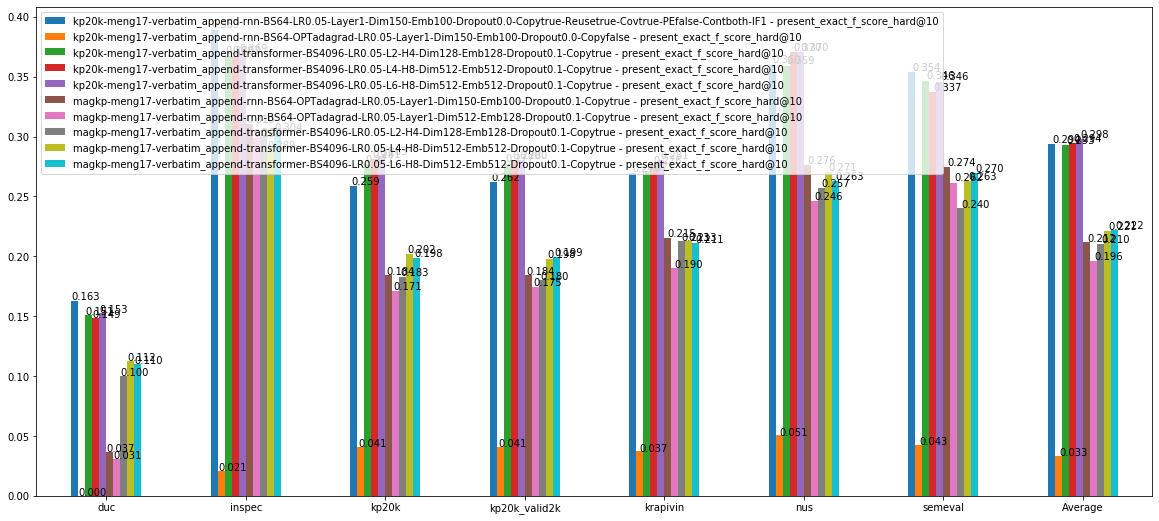

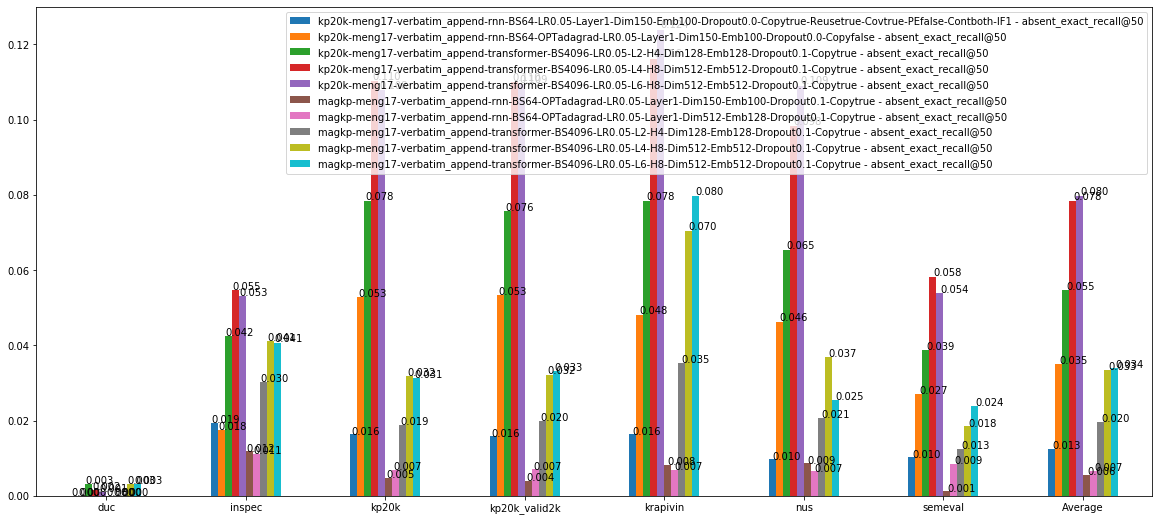

In [13]:
# 2. Compare different architecture variants

one2seq_exps = [
    
'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1', 
               
'kp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L2-H4-Dim128-Emb128-Dropout0.1-Copytrue',
'kp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L4-H8-Dim512-Emb512-Dropout0.1-Copytrue',
# 'kp20k-meng17-verbatim_append-transformer-BS4096-LR0.5-Layer4-Heads8-Dim512-Emb512-Dropout0.2-Copytrue-Reusetrue-Covtrue-PEtrue-Contextboth-IF1',
'kp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue',

'magkp-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim512-Emb128-Dropout0.1-Copytrue',
'magkp-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim150-Emb100-Dropout0.1-Copytrue',

# 'magkp-meng17-verbatim_append-transformer-BS4096-LR0.5-Layer2-Heads4-Dim128-Emb128-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEtrue-Contextboth-IF1',
'magkp-meng17-verbatim_append-transformer-BS4096-LR0.05-L2-H4-Dim128-Emb128-Dropout0.1-Copytrue',

'magkp-meng17-verbatim_append-transformer-BS4096-LR0.05-L4-H8-Dim512-Emb512-Dropout0.1-Copytrue',
'magkp-meng17-verbatim_append-transformer-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue',
]

# prepare one2seq data
one2seq_df = all_eval_df.loc[all_eval_df['exp_name'].isin(one2seq_exps)]
one2seq_df = one2seq_df.loc[one2seq_df.step % 10000 == 0] # keep % 10000
one2seq_df = one2seq_df.sort_values(by='step', ascending=True)
one2seq_df = one2seq_df.loc[one2seq_df.beam_width == '50']
one2seq_df = one2seq_df.loc[one2seq_df.decoding_terminate == 'topbeamends'] # topbeamends/fullbeam
one2seq_df = one2seq_df.loc[one2seq_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating

_, peak_one2seq_df, valid_one2seq_df = brief_eval_results(one2seq_df, base_metric='present_exact_f_score_hard@10')

# ensure the dataframe is sorted first
# print(peak_one2seq_df.shape)
# display(peak_one2seq_df)

# metric_names = ['present_exact_f_score_hard@5', 'present_exact_f_score_hard@10', 'present_exact_f_score_hard@k', 'present_exact_f_score_hard@M']
# metric_names = ['present_exact_f_score_hard@5', 'present_exact_f_score_hard@10']
metric_names = ['present_exact_f_score_hard@10']


datasets = valid_one2seq_df.test_dataset.unique()
exp_names = valid_one2seq_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}

for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')

df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))    
    
    
    
############## absent
_, peak_one2seq_df, valid_one2seq_df = brief_eval_results(one2seq_df, base_metric='absent_exact_recall@50', ignore_valid=True)

# ensure the dataframe is sorted first
# print(peak_one2seq_df.shape)
# display(peak_one2seq_df)

# metric_names = ['present_exact_f_score_hard@5', 'present_exact_f_score_hard@10', 'present_exact_f_score_hard@k', 'present_exact_f_score_hard@M']
# metric_names = ['present_exact_f_score_hard@5', 'present_exact_f_score_hard@10']
metric_names = ['absent_exact_recall@50']


datasets = valid_one2seq_df.test_dataset.unique()
exp_names = valid_one2seq_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}

for index_label, row_series in valid_one2seq_df.iterrows():
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')

df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))  

## V3: more Transformers+MagKP exps

In [151]:
[name for name in all_eval_df['exp_name'].unique() if name.startswith('kpgen-')]

['kpgen-meng17-kp20k-no_sort_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
 'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
 'kpgen-meng17-kp20k-length_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
 'kpgen-meng17-kp20k-length_reverse-rnn-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue',
 'kpgen-meng17-kp20k-alphabetical_reverse-rnn-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue',
 'kpgen-meng17-kp20k-no_sort_reverse-rnn-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue',
 'kpgen-meng17-kp20k-alphabetical_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
 'kpgen-meng17-MagKP_LN-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
 'kpgen-meng17-MagKP_LN+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
 'kpgen-meng17-

In [14]:
one2one_eval_df = all_eval_df.loc[all_eval_df['train_mode'] == 'one2one']
print(one2one_eval_df.shape)
print(one2one_eval_df.exp_name.value_counts())
print(one2one_eval_df.exp_group.value_counts())

(7634, 121)
kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1                  911
kpgen-meng17-kp20k-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copyfalse-Covfalse          420
kpgen-meng17-kp20k-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue            420
kpgen-meng17-magkp20k-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue         420
kpgen-meng17-magkp-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue            420
kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.25-Copytrue-Covtrue-Contboth-IF1                 351
kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covfalse-Contboth-IF1                 313
kp20k-meng17-one2one-rnn-BS128-Layer1-Dim100-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1                         312
kp20k-meng17-one2one

### One2One

All data
(420, 121)
present valid_kp_df
(21, 121)
All data
(420, 121)
absent valid_kp_df


/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:61: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(21, 121)


/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


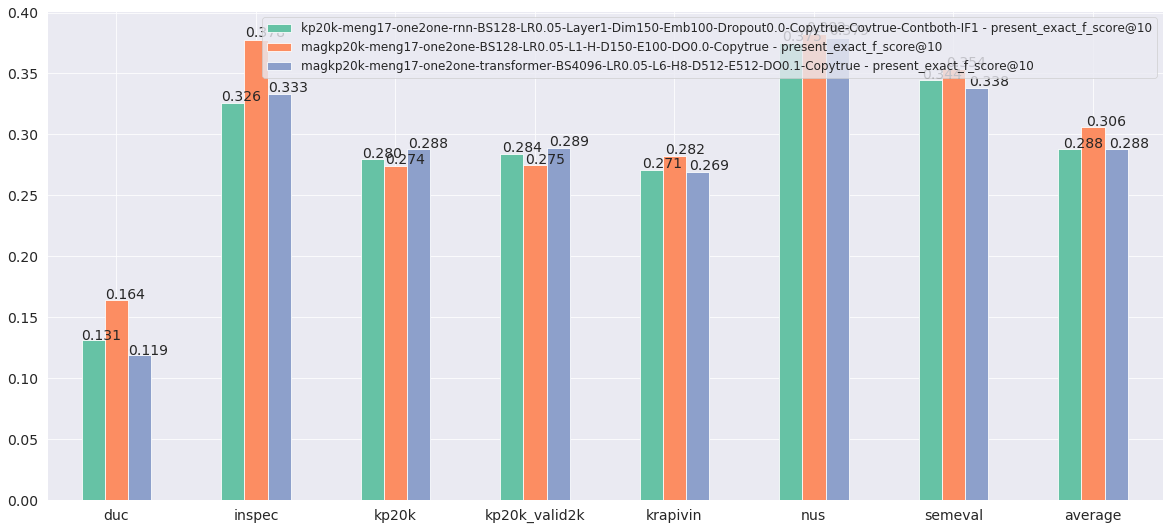

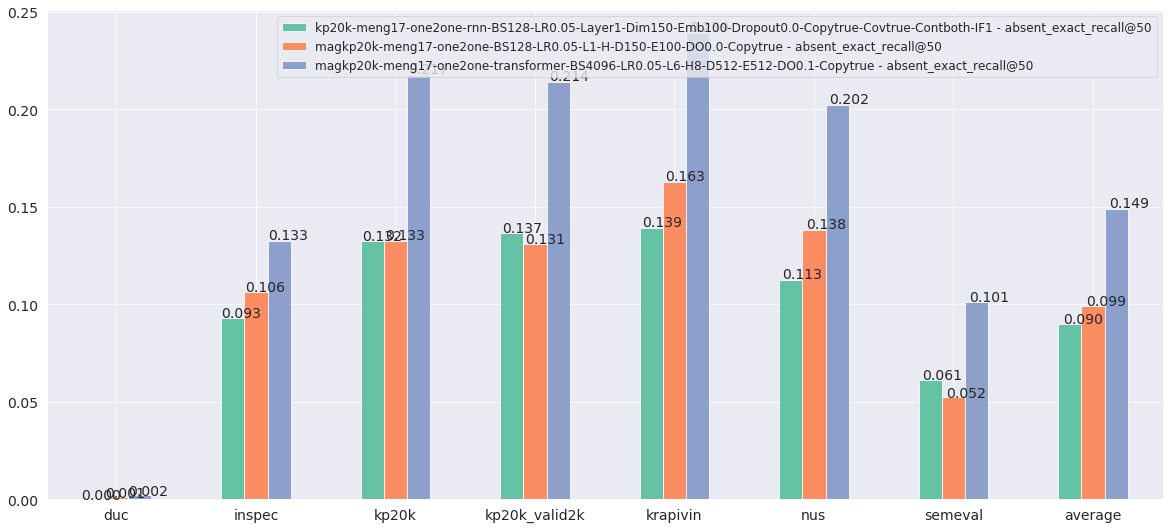

In [131]:
# 2. Compare different architecture variants


kp_exps = [
    'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1',
    'magkp20k-meng17-one2one-BS128-LR0.05-L1-H-D150-E100-DO0.0-Copytrue',
    'magkp20k-meng17-one2one-transformer-BS4096-LR0.05-L6-H8-D512-E512-DO0.1-Copytrue',
    
#     'kpgen-meng17-kp20k-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copyfalse-Covfalse',
#     'kpgen-meng17-kp20k-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
#     'kpgen-meng17-magkp-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
#     'kpgen-meng17-magkp20k-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue'
]


# prepare one2one data
kp_df = all_eval_df.loc[all_eval_df['exp_name'].isin(kp_exps)]
kp_df = kp_df.loc[(kp_df.step % 10000 == 6000) | (kp_df.step % 5000 == 0)]
kp_df = kp_df.sort_values(by='step', ascending=True)
kp_df = kp_df.loc[kp_df.beam_width == '200']
kp_df = kp_df.loc[kp_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam
kp_df = kp_df.loc[kp_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating

print('All data')
print(kp_df.shape)

print('present valid_kp_df')
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='present_exact_f_score@10')
print(valid_kp_df.shape)
# display(valid_kp_df)


metric_names = ['present_exact_f_score@5', 'present_exact_f_score@10', 'present_exact_f_score@k']
metric_names = ['present_exact_f_score@10']
datasets = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'average')

df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))    
    

pd.options.display.float_format = '{:,.1f}'.format
with pd.option_context('display.max_colwidth', 100, 'display.max_rows', None):
    value_cols = ['present_exact_f_score@5', 'present_exact_f_score@10', 'present_exact_f_score@k']
    tmp_df = valid_kp_df[['exp_name', 'model_base', 'test_dataset'] + value_cols]
    for col in value_cols:
        tmp_df[col] = tmp_df[col].map(lambda v: v * 100.0)

#     tmp_df.columns = [' '.join(c.split('_')) for c in tmp_df.columns]
#     display(tmp_df)
    df_list = []
    for exp in kp_exps:
        for i in ordered_datasets:
            df_list.append(tmp_df[(tmp_df['exp_name']==exp) & (tmp_df['test_dataset']==i)])
    ordered_df = pd.concat(df_list)
    tmp_df = ordered_df[value_cols]
#     display(ordered_df)
#     print(tmp_df.to_latex(index=False))
    

############## absent
print('All data')
print(kp_df.shape)
print('absent valid_kp_df')
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='absent_exact_recall@50')

# ensure the dataframe is sorted first
print(valid_kp_df.shape)
# display(valid_kp_df)

# metric_names = ['absent_exact_recall@10', 'absent_exact_recall@50', 'absent_exact_advanced_sadr']
metric_names = ['absent_exact_recall@50']

datasets = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}

for index_label, row_series in valid_kp_df.iterrows():
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'average')

df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))  
# display(df.transpose())

    
pd.options.display.float_format = '{:,.1f}'.format
with pd.option_context('display.max_colwidth', 100, 'display.max_rows', None):
    value_cols = ['absent_exact_recall@10', 'absent_exact_recall@50']
    tmp_df = valid_kp_df[['exp_name', 'model_base', 'test_dataset'] + value_cols]
    for col in value_cols:
        tmp_df[col] = tmp_df[col].map(lambda v: v * 100.0)

#     tmp_df.columns = [' '.join(c.split('_')) for c in tmp_df.columns]
    df_list = []
    for exp in kp_exps:
        for i in ordered_datasets:
            df_list.append(tmp_df[(tmp_df['exp_name']==exp) & (tmp_df['test_dataset']==i)])
    ordered_df = pd.concat(df_list)
    tmp_df = ordered_df[value_cols]

#     display(ordered_df)
#     print(tmp_df.to_latex(index=False))


### One2Seq Transformer Order Matters?

In [12]:
one2seq_eval_df = all_eval_df.loc[all_eval_df['train_mode'] == 'one2seq']
print(one2seq_eval_df.shape)
print(one2seq_eval_df.exp_name.value_counts())
print(one2seq_eval_df.exp_group.value_counts())

(50277, 121)
kpgen-meng17-kp20k-alphabetical_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue              3187
kpgen-meng17-kp20k-length_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue                    3186
kpgen-meng17-kp20k-no_sort_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue                   3183
kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue                   2535
magkp-meng17-verbatim_append-transformer-BS4096-LR0.05-L4-H8-Dim512-Emb512-Dropout0.1-Copytrue                                      1680
magkp-meng17-verbatim_append-transformer-BS4096-LR0.05-L2-H4-Dim128-Emb128-Dropout0.1-Copytrue                                      1680
magkp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue                           1680
magkp-meng17-verbatim_append

/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


All data
(3254, 236)
present valid_kp_df
(63, 236)


path  \
15880  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2seq/meng17-one2seq-kp20k-v3/meng17-one2seq-fullbeam/meng17-one2seq-beam50-maxlen40/pred/kpgen-meng17-kp20k-alphabetical-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue_step_50000/duc.split_nopunc.eval                     
20240  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2seq/meng17-one2seq-kp20k-v3/meng17-one2seq-fullbeam/meng17-one2seq-beam50-maxlen40/pred/kpgen-meng17-kp20k-alphabetical_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue_step_25000/duc.split_nopunc.eval             
16579  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2seq/meng17-one2seq-kp20k-v3/meng17-one2seq-fullbeam/meng17-one2seq-beam50-maxlen40/pred/kpgen-meng17-kp20k-length-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue_step_115000/duc.split_nopunc.eval                          
15963  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2seq/meng17-one2seq-kp20k-v3/meng17-one2seq-fullbeam/meng17-one2seq-beam50-maxlen40/pred/kpgen-meng17-kp20k-length_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue_step_50000/duc.split_nopunc.eval                   
20419  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2seq/meng17-one2seq-kp20k-v3/meng17-one2seq-fullbeam/meng17-one2seq-beam50-maxlen40/pred/kpgen-meng17-kp20k-no_sort-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue_step_155000/duc.split_nopunc.eval                         
18552  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2seq/meng17-one2seq-kp20k-v3/meng17-one2seq-fullbeam/meng17-one2seq-beam50-maxlen40/pred/kpgen-meng17-kp20k-no_sort_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue_step_80000/duc.split_nopunc.eval                  
20748  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2seq/meng17-one2seq-kp20k-v3/meng17-one2seq-fullbeam/meng17-one2seq-beam50-maxlen40/pred/kpgen-meng17-kp20k-random-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue_step_115000/duc.split_nopunc.eval                          
19592  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2seq/meng17-one2seq-kp20k-v3/meng17-one2seq-fullbeam/meng17-one2seq-beam50-maxlen40/pred/kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue_step_80000/duc.split_nopunc.eval                  
19154  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2seq/meng17-one2seq-kp20k-v3/meng17-one2seq-fullbeam/meng17-one2seq-beam50-maxlen40/pred/kpgen-meng17-kp20k-verbatim_prepend-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue_step_50000/duc.split_nopunc.eval                 
15881  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2seq/meng17-one2seq-kp20k-v3/meng17-one2seq-fullbeam/meng17-one2seq-beam50-maxlen40/pred/kpgen-meng17-kp20k-alphabetical-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue_step_50000/inspec.split_nopunc.eval                  
20241  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2seq/meng17-one2seq-kp20k-v3/meng17-one2seq-fullbeam/meng17-one2seq-beam50-maxlen40/pred/kpgen-meng17-kp20k-alphabetical_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue_step_25000/inspec.split_nopunc.eval          
16573  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2seq/meng17-one2seq-kp20k-v3/meng17-one2seq-fullbeam/meng17-one2seq-beam50-maxlen40/pred/kpgen-meng17-kp20k-length-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue_step_115000/inspec.split_nopunc.eval                       
15964  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/ke

/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


All data
(3254, 236)
absent valid_kp_df
(63, 236)


/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:226: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


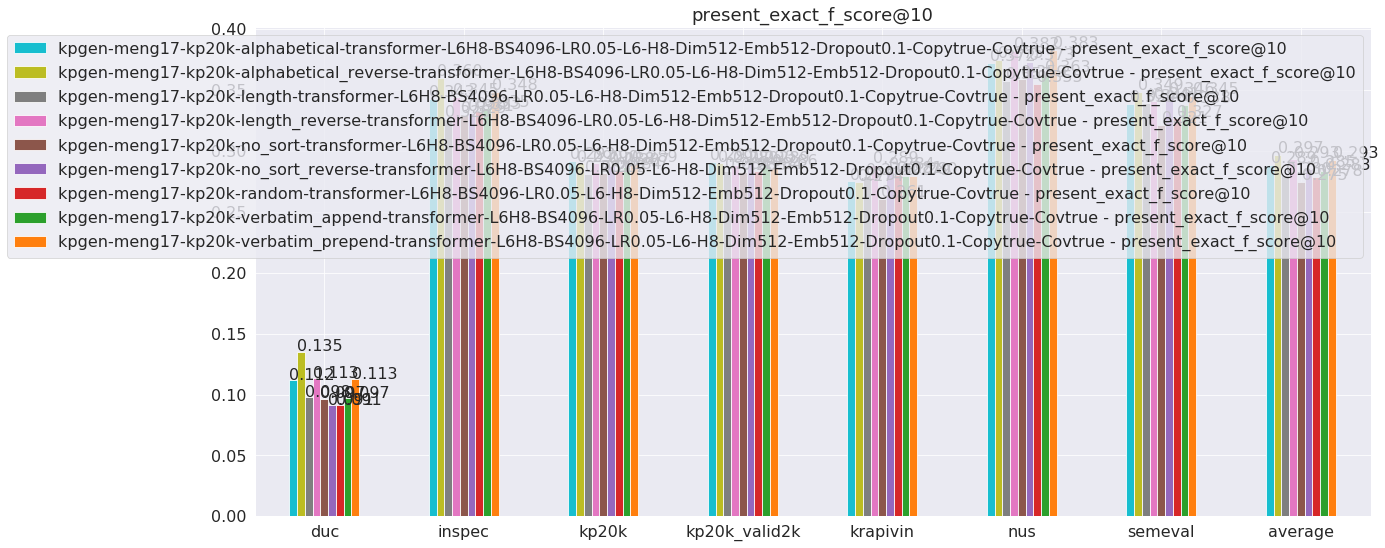

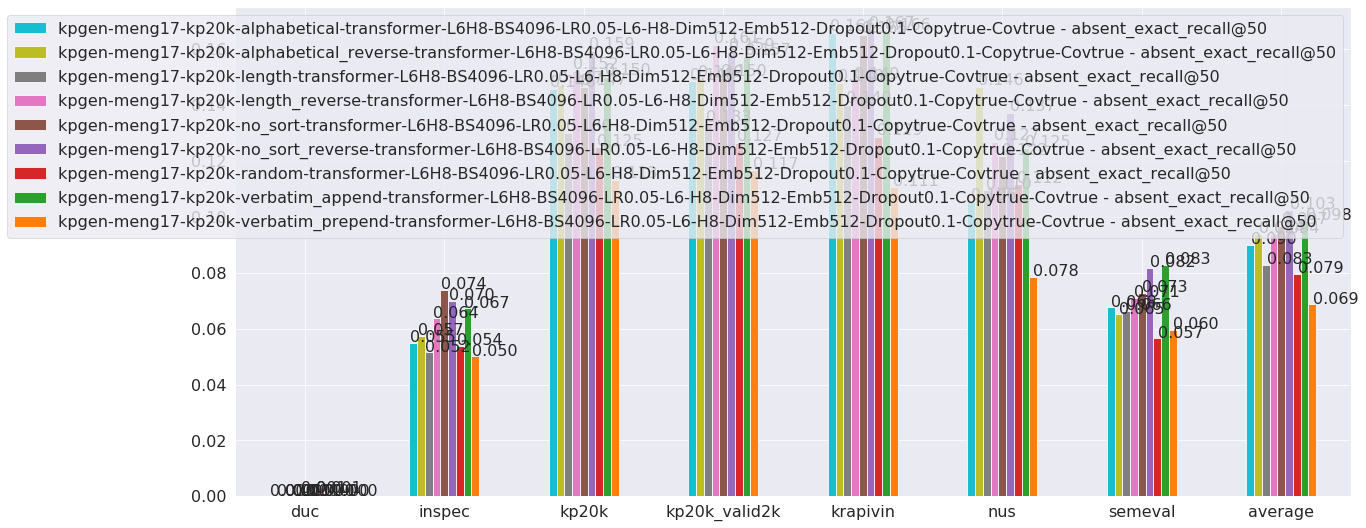

In [19]:
# 2. Compare different architecture variants
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.options.display.max_colwidth = -1

ordered_datasets = ['kp20k', 'inspec', 'krapivin', 'nus', 'semeval', 'duc', 'average']

kp_exps = [
    'kpgen-meng17-kp20k-random-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',    
    
    'kpgen-meng17-kp20k-alphabetical-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    'kpgen-meng17-kp20k-alphabetical_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    
    'kpgen-meng17-kp20k-length-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    'kpgen-meng17-kp20k-length_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

    'kpgen-meng17-kp20k-no_sort-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    'kpgen-meng17-kp20k-no_sort_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    
    'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',   
    'kpgen-meng17-kp20k-verbatim_prepend-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    
#     'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copyfalse-Covfalse',
]    


# prepare one2seq data
kp_df = all_eval_df.loc[all_eval_df['exp_name'].isin(kp_exps)]
kp_df = kp_df.loc[kp_df.step % 5000 == 0] # keep % 10000
kp_df = kp_df.sort_values(by='step', ascending=True)
kp_df = kp_df.loc[kp_df.beam_width == '50']
kp_df = kp_df.loc[kp_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam
kp_df = kp_df.loc[kp_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating

print('All data')
print(kp_df.shape)

print('present valid_kp_df')
_, _, valid_df_present, _ = brief_eval_results(kp_df, base_metric='present_exact_f_score@10')
print(valid_df_present.shape)
display(valid_df_present)


metric_names = ['present_exact_f_score@5', 'present_exact_f_score@10', 'present_exact_f_score@k']
metric_names = ['present_exact_f_score@10']
datasets = valid_df_present.test_dataset.unique()
exp_names = valid_df_present.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}
for index_label, row_series in valid_df_present.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'average')
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0, title='present_exact_f_score@10')
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))    
    
'''
# SADR
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='present_exact_advanced_sadr')
metric_names = ['present_exact_advanced_sadr']
datasets = valid_kp_df.test_dataset.unique()
orders = valid_kp_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0, title='present_exact_advanced_sadr')
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))  
    
# AUC
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='present_exact_advanced_auc')
metric_names = ['present_exact_advanced_auc']
datasets = valid_kp_df.test_dataset.unique()
orders = valid_kp_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0, title='present_exact_advanced_auc')
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))  
'''    
    
# export to Latex
pd.options.display.float_format = '{:,.1f}'.format
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', None):
    value_cols = ['present_exact_f_score@5', 'present_exact_f_score@10', 'present_exact_f_score@k']
    tmp_df = valid_df_present[['exp_name', 'model_base', 'test_dataset'] + value_cols]
    for col in value_cols:
        tmp_df[col] = tmp_df[col].map(lambda v: v * 100.0)

#     tmp_df.columns = [' '.join(c.split('_')) for c in tmp_df.columns]
#     display(tmp_df)
    df_list = []
    for exp in kp_exps:
        for i in ordered_datasets:
            df_list.append(tmp_df[(tmp_df['exp_name']==exp) & (tmp_df['test_dataset']==i)])
    ordered_df = pd.concat(df_list)
    tmp_df = ordered_df[value_cols]
#     display(ordered_df)
#     print(tmp_df.to_latex(index=False))
    
    
    
    
    

############## absent
print('All data')
print(kp_df.shape)
print('absent valid_kp_df')
_, _, valid_df_absent, _ = brief_eval_results(kp_df, base_metric='absent_exact_recall@50')

# ensure the dataframe is sorted first
print(valid_df_absent.shape)
# display(valid_df_absent)

# metric_names = ['absent_exact_recall@10', 'absent_exact_recall@50', 'absent_exact_advanced_sadr']
metric_names = ['absent_exact_recall@50']

datasets = valid_df_absent.test_dataset.unique()
exp_names = valid_df_absent.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}

for index_label, row_series in valid_df_absent.iterrows():
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'average')

df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))  
# display(df.transpose())





# SADR
'''
_, _, valid_kp_df = brief_eval_results(kp_df, base_metric='absent_exact_advanced_sadr')
metric_names = ['absent_exact_advanced_sadr']
datasets = valid_kp_df.test_dataset.unique()
orders = valid_kp_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0, title='absent_exact_advanced_sadr')
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))  
    
# AUC
_, _, valid_kp_df = brief_eval_results(kp_df, base_metric='absent_exact_advanced_auc')
metric_names = ['absent_exact_advanced_auc']
datasets = valid_kp_df.test_dataset.unique()
orders = valid_kp_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0, title='absent_exact_advanced_auc')
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))  
'''




pd.options.display.float_format = '{:,.1f}'.format
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', None):
    value_cols = ['absent_exact_recall@10', 'absent_exact_recall@50']
    tmp_df = valid_df_absent[['exp_name', 'model_base', 'test_dataset'] + value_cols]
    for col in value_cols:
        tmp_df[col] = tmp_df[col].map(lambda v: v * 100.0)

#     tmp_df.columns = [' '.join(c.split('_')) for c in tmp_df.columns]
    df_list = []
    for exp in kp_exps:
        for i in ordered_datasets:
            df_list.append(tmp_df[(tmp_df['exp_name']==exp) & (tmp_df['test_dataset']==i)])
    ordered_df = pd.concat(df_list)
    tmp_df = ordered_df[value_cols]

#     display(ordered_df)
#     print(tmp_df.to_latex(index=False))


#### beam_width=1 (greedy)

(7, 9)
Index(['alphabetical - present_exact_f_score@10',
       'alphabetical_reverse - present_exact_f_score@10',
       'length - present_exact_f_score@10',
       'length_reverse - present_exact_f_score@10',
       'no_sort - present_exact_f_score@10',
       'no_sort_reverse - present_exact_f_score@10',
       'random - present_exact_f_score@10',
       'verbatim_append - present_exact_f_score@10',
       'verbatim_prepend - present_exact_f_score@10'],
      dtype='object')
(7, 9)
Index(['alphabetical - absent_exact_recall@50',
       'alphabetical_reverse - absent_exact_recall@50',
       'length - absent_exact_recall@50',
       'length_reverse - absent_exact_recall@50',
       'no_sort - absent_exact_recall@50',
       'no_sort_reverse - absent_exact_recall@50',
       'random - absent_exact_recall@50',
       'verbatim_append - absent_exact_recall@50',
       'verbatim_prepend - absent_exact_recall@50'],
      dtype='object')


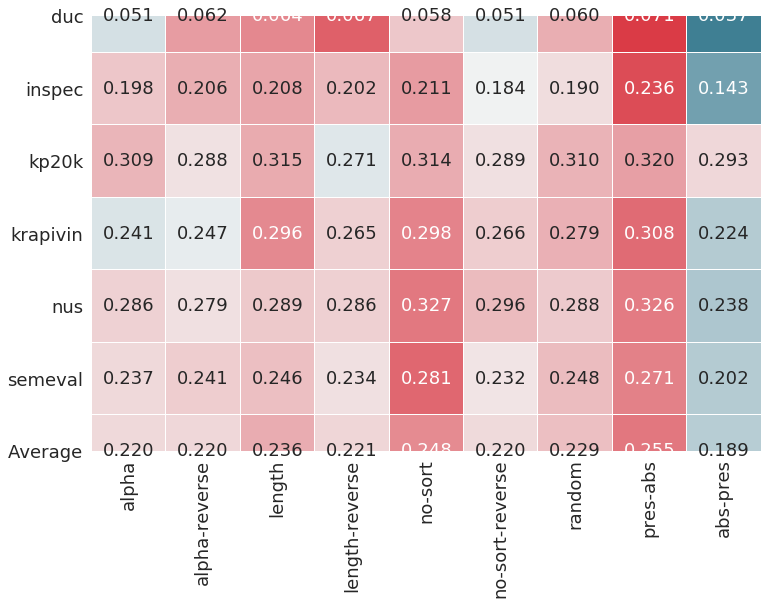

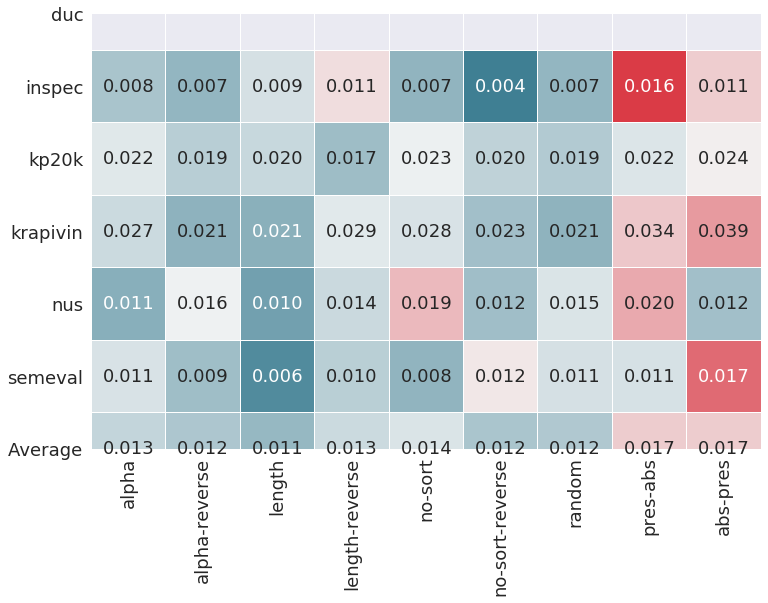

In [21]:
one2seq_exps = [
    'kpgen-meng17-kp20k-random-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',    
    
    'kpgen-meng17-kp20k-alphabetical-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    'kpgen-meng17-kp20k-alphabetical_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    
    'kpgen-meng17-kp20k-length-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    'kpgen-meng17-kp20k-length_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

    'kpgen-meng17-kp20k-no_sort-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    'kpgen-meng17-kp20k-no_sort_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    
    'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',   
    'kpgen-meng17-kp20k-verbatim_prepend-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
]

import seaborn as sns
sns.set()
import copy

########### Present #############
one2seq_df = all_eval_df.loc[all_eval_df['exp_name'].isin(one2seq_exps)]
one2seq_df = one2seq_df.sort_values(by=['exp_name', 'step'], ascending=True)
one2seq_df = one2seq_df.loc[one2seq_df.step % 5000 == 0] # keep % 10000 and 5000
one2seq_df = one2seq_df.sort_values(by='step', ascending=True)
one2seq_df = one2seq_df.loc[one2seq_df.beam_width == '1']
one2seq_df = one2seq_df.loc[one2seq_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam
one2seq_df = one2seq_df.loc[one2seq_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating

_, _, valid_one2seq_df, _ = brief_eval_results(one2seq_df, base_metric='present_exact_f_score@10')

metric_names = ['present_exact_f_score@10']

datasets = valid_one2seq_df.test_dataset.unique()
orders = valid_one2seq_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
    
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)

df_f1_50 = copy.copy(df)
df_f1_50 = df_f1_50.drop(['kp20k_valid2k'], axis=0)
print(df_f1_50.shape)
column_name_map = {
    'random - present_exact_f_score@10': "random",
    'alphabetical - present_exact_f_score@10': "alpha",
    'alphabetical_reverse - present_exact_f_score@10': "alpha-reverse",
    'length - present_exact_f_score@10': "length",
    'length_reverse - present_exact_f_score@10': "length-reverse",
    'no_sort - present_exact_f_score@10': "no-sort",
    'no_sort_reverse - present_exact_f_score@10': "no-sort-reverse",
    'verbatim_append - present_exact_f_score@10': "pres-abs",
    'verbatim_prepend - present_exact_f_score@10': "abs-pres"
}

normalized_df_f1_50 = df_f1_50.div(df_f1_50.sum(axis=1), axis=0)
print(normalized_df_f1_50.columns)
normalized_df_f1_50.columns = [column_name_map[item] for item in normalized_df_f1_50.columns]




sns.set_context("paper", rc={"font.size": 18,
                             "axes.titlesize": 18,
                             "axes.labelsize": 18,
                             "xtick.labelsize": 18,
                             "ytick.labelsize": 18,
                             "legend.fontsize": 12})


cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, axes = plt.subplots(figsize=(12, 8))
sns.heatmap(normalized_df_f1_50, annot=df_f1_50, linewidths=.2, ax=axes, cmap=cmap, fmt='.3f', cbar=False)




########### Absent #############
metric_names = ['absent_exact_recall@50']

datasets = valid_one2seq_df.test_dataset.unique()
orders = valid_one2seq_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
    
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)

df_f1_50 = copy.copy(df)
df_f1_50 = df_f1_50.drop(['kp20k_valid2k'], axis=0)
print(df_f1_50.shape)
column_name_map = {
    'random - absent_exact_recall@50': "random",
    'alphabetical - absent_exact_recall@50': "alpha",
    'alphabetical_reverse - absent_exact_recall@50': "alpha-reverse",
    'length - absent_exact_recall@50': "length",
    'length_reverse - absent_exact_recall@50': "length-reverse",
    'no_sort - absent_exact_recall@50': "no-sort",
    'no_sort_reverse - absent_exact_recall@50': "no-sort-reverse",
    'verbatim_append - absent_exact_recall@50': "pres-abs",
    'verbatim_prepend - absent_exact_recall@50': "abs-pres"
}

normalized_df_f1_50 = df_f1_50.div(df_f1_50.sum(axis=1), axis=0)
print(normalized_df_f1_50.columns)
normalized_df_f1_50.columns = [column_name_map[item] for item in normalized_df_f1_50.columns]


sns.set_context("paper", rc={"font.size": 18,
                             "axes.titlesize": 18,
                             "axes.labelsize": 18,
                             "xtick.labelsize": 18,
                             "ytick.labelsize": 18,
                             "legend.fontsize": 12})


cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, axes = plt.subplots(figsize=(12, 8))
sns.heatmap(normalized_df_f1_50, annot=df_f1_50, linewidths=.2, ax=axes, cmap=cmap, fmt='.3f', cbar=False)


#### beam_width=50

(7, 9)
Index(['alphabetical - present_exact_f_score@10',
       'alphabetical_reverse - present_exact_f_score@10',
       'length - present_exact_f_score@10',
       'length_reverse - present_exact_f_score@10',
       'no_sort - present_exact_f_score@10',
       'no_sort_reverse - present_exact_f_score@10',
       'random - present_exact_f_score@10',
       'verbatim_append - present_exact_f_score@10',
       'verbatim_prepend - present_exact_f_score@10'],
      dtype='object')
(7, 9)
Index(['alphabetical - absent_exact_recall@50',
       'alphabetical_reverse - absent_exact_recall@50',
       'length - absent_exact_recall@50',
       'length_reverse - absent_exact_recall@50',
       'no_sort - absent_exact_recall@50',
       'no_sort_reverse - absent_exact_recall@50',
       'random - absent_exact_recall@50',
       'verbatim_append - absent_exact_recall@50',
       'verbatim_prepend - absent_exact_recall@50'],
      dtype='object')


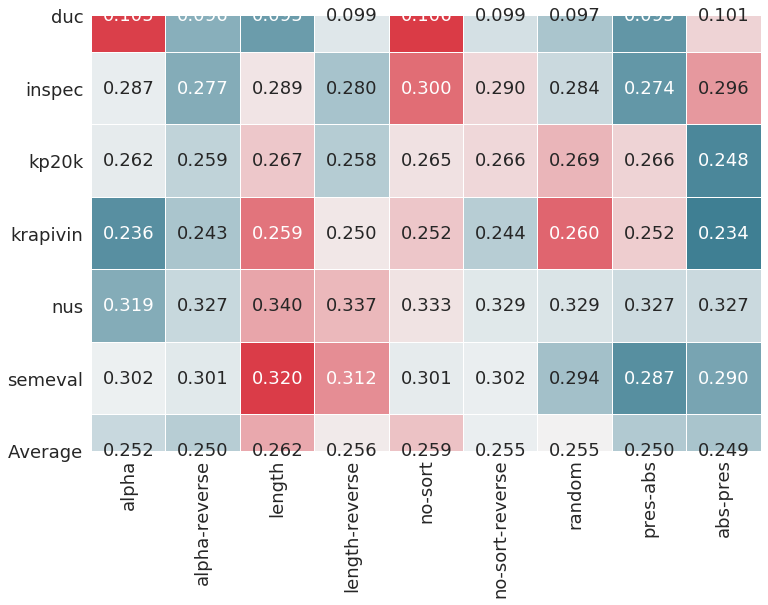

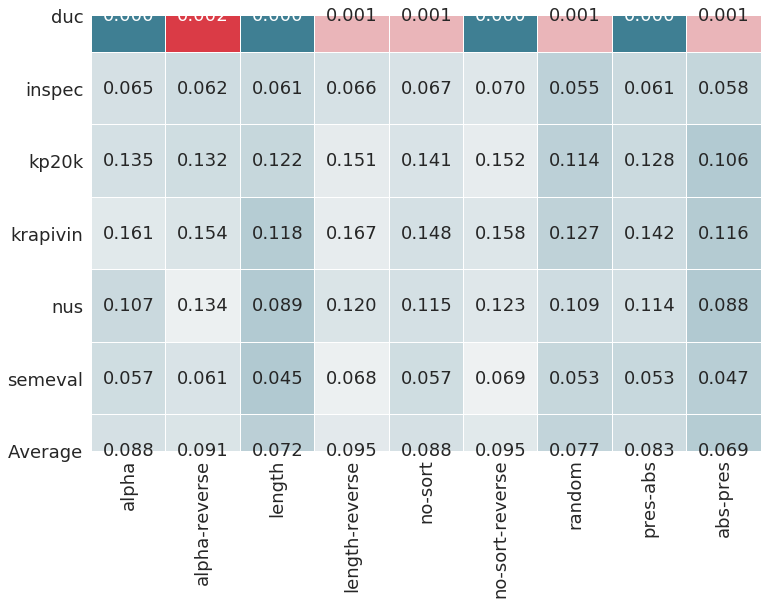

In [22]:
one2seq_exps = [
    'kpgen-meng17-kp20k-random-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',    
    
    'kpgen-meng17-kp20k-alphabetical-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    'kpgen-meng17-kp20k-alphabetical_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    
    'kpgen-meng17-kp20k-length-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    'kpgen-meng17-kp20k-length_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

    'kpgen-meng17-kp20k-no_sort-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    'kpgen-meng17-kp20k-no_sort_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    
    'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',   
    'kpgen-meng17-kp20k-verbatim_prepend-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
]

import seaborn as sns
sns.set()
import copy

########### Present #############
one2seq_df = all_eval_df.loc[all_eval_df['exp_name'].isin(one2seq_exps)]
one2seq_df = one2seq_df.sort_values(by=['exp_name', 'step'], ascending=True)
one2seq_df = one2seq_df.loc[one2seq_df.step % 5000 == 0] # keep % 10000 and 5000
one2seq_df = one2seq_df.sort_values(by='step', ascending=True)
one2seq_df = one2seq_df.loc[one2seq_df.beam_width == '50']
one2seq_df = one2seq_df.loc[one2seq_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam
one2seq_df = one2seq_df.loc[one2seq_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating

_, peak_one2seq_df, valid_one2seq_df, last_one2seq_df = brief_eval_results(one2seq_df, base_metric='present_exact_f_score@10')

metric_names = ['present_exact_f_score@10']

datasets = last_one2seq_df.test_dataset.unique()
orders = last_one2seq_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in last_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
    
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)

df_f1_50 = copy.copy(df)
df_f1_50 = df_f1_50.drop(['kp20k_valid2k'], axis=0)
print(df_f1_50.shape)
column_name_map = {
    'random - present_exact_f_score@10': "random",
    'alphabetical - present_exact_f_score@10': "alpha",
    'alphabetical_reverse - present_exact_f_score@10': "alpha-reverse",
    'length - present_exact_f_score@10': "length",
    'length_reverse - present_exact_f_score@10': "length-reverse",
    'no_sort - present_exact_f_score@10': "no-sort",
    'no_sort_reverse - present_exact_f_score@10': "no-sort-reverse",
    'verbatim_append - present_exact_f_score@10': "pres-abs",
    'verbatim_prepend - present_exact_f_score@10': "abs-pres"
}

normalized_df_f1_50 = df_f1_50.div(df_f1_50.sum(axis=1), axis=0)
print(normalized_df_f1_50.columns)
normalized_df_f1_50.columns = [column_name_map[item] for item in normalized_df_f1_50.columns]




sns.set_context("paper", rc={"font.size": 18,
                             "axes.titlesize": 18,
                             "axes.labelsize": 18,
                             "xtick.labelsize": 18,
                             "ytick.labelsize": 18,
                             "legend.fontsize": 12})


cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, axes = plt.subplots(figsize=(12, 8))
sns.heatmap(normalized_df_f1_50, annot=df_f1_50, linewidths=.2, ax=axes, cmap=cmap, fmt='.3f', cbar=False)




########### Absent #############
metric_names = ['absent_exact_recall@50']

datasets = last_one2seq_df.test_dataset.unique()
orders = last_one2seq_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in last_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
    
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)

df_f1_50 = copy.copy(df)
df_f1_50 = df_f1_50.drop(['kp20k_valid2k'], axis=0)
print(df_f1_50.shape)
column_name_map = {
    'random - absent_exact_recall@50': "random",
    'alphabetical - absent_exact_recall@50': "alpha",
    'alphabetical_reverse - absent_exact_recall@50': "alpha-reverse",
    'length - absent_exact_recall@50': "length",
    'length_reverse - absent_exact_recall@50': "length-reverse",
    'no_sort - absent_exact_recall@50': "no-sort",
    'no_sort_reverse - absent_exact_recall@50': "no-sort-reverse",
    'verbatim_append - absent_exact_recall@50': "pres-abs",
    'verbatim_prepend - absent_exact_recall@50': "abs-pres"
}

normalized_df_f1_50 = df_f1_50.div(df_f1_50.sum(axis=1), axis=0)
print(normalized_df_f1_50.columns)
normalized_df_f1_50.columns = [column_name_map[item] for item in normalized_df_f1_50.columns]


sns.set_context("paper", rc={"font.size": 18,
                             "axes.titlesize": 18,
                             "axes.labelsize": 18,
                             "xtick.labelsize": 18,
                             "ytick.labelsize": 18,
                             "legend.fontsize": 12})


cmap = sns.diverging_palette(220, 10, as_cmap=True)
f, axes = plt.subplots(figsize=(12, 8))
sns.heatmap(normalized_df_f1_50, annot=df_f1_50, linewidths=.2, ax=axes, cmap=cmap, fmt='.3f', cbar=False)


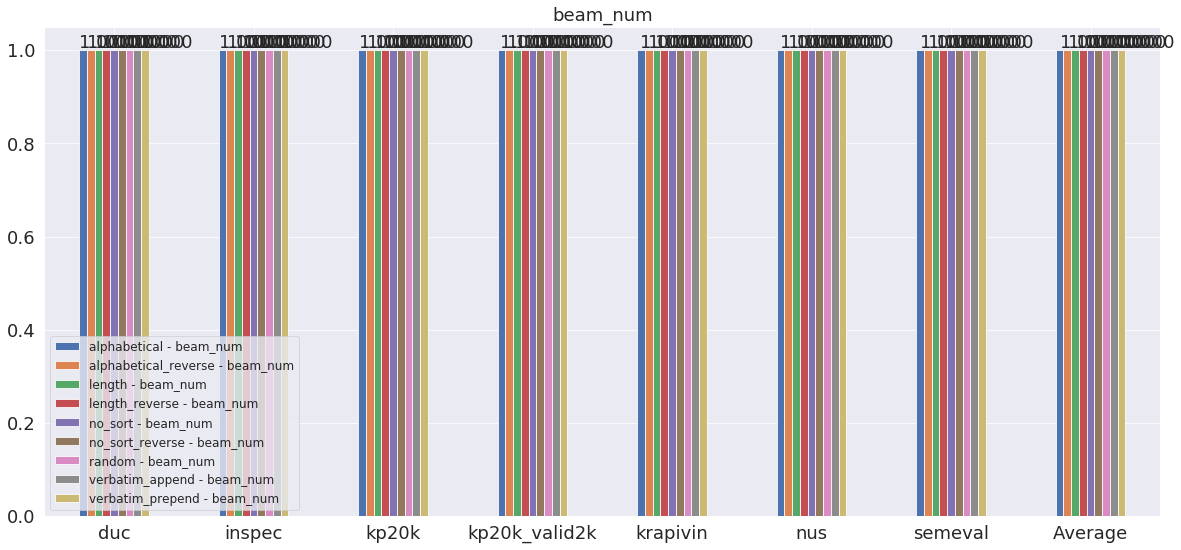

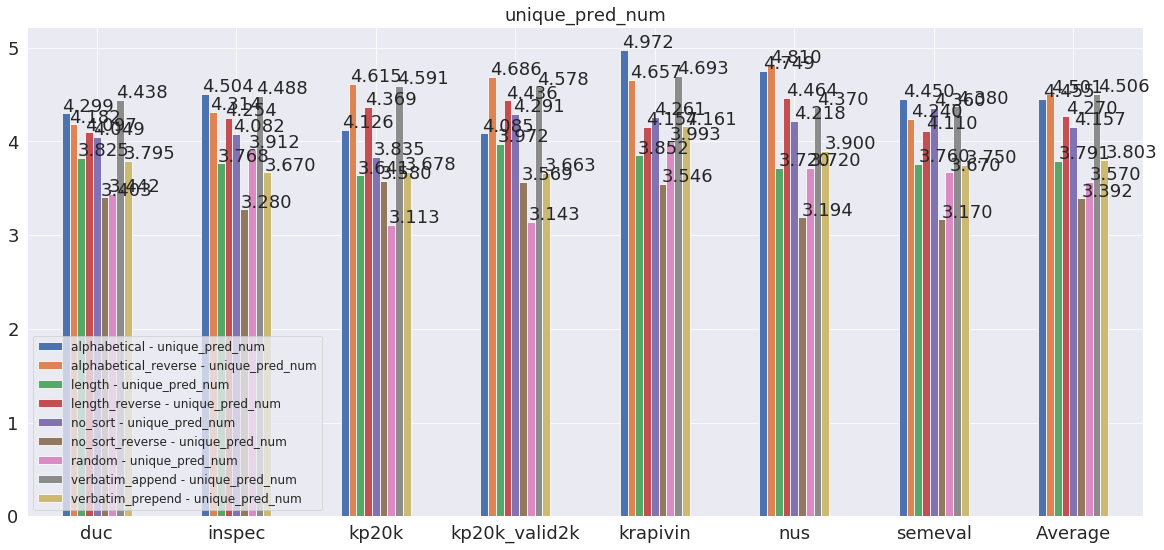

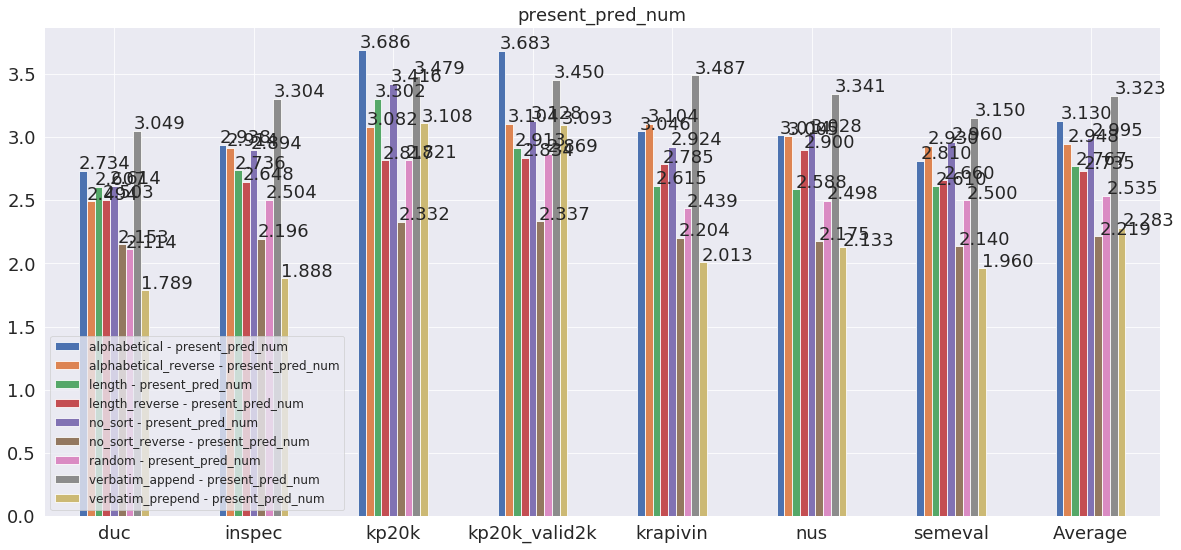

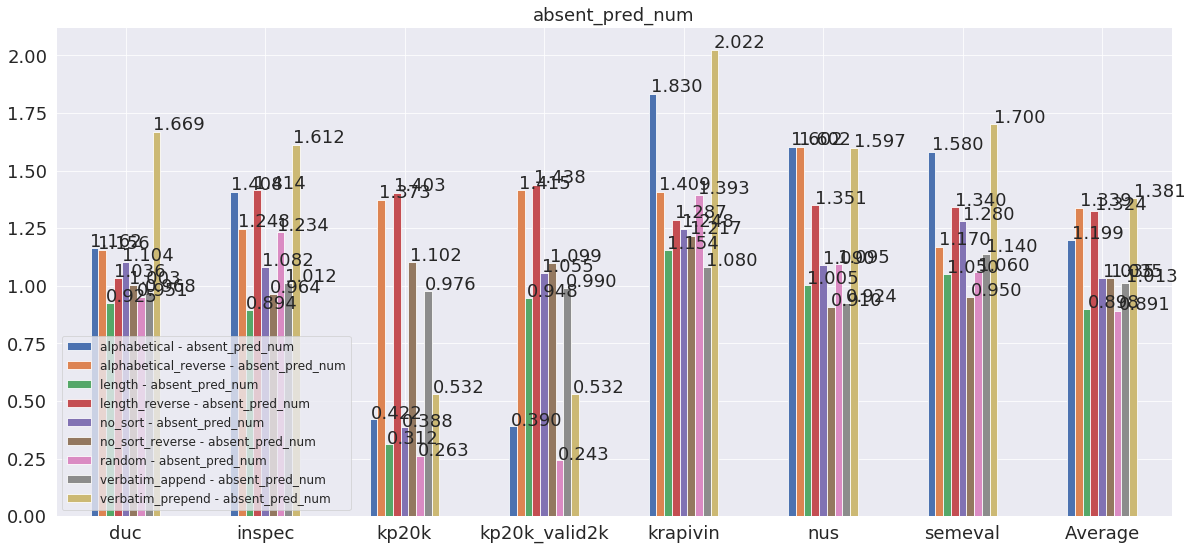

In [13]:

metric_names = ['beam_num']
datasets = valid_one2seq_df.test_dataset.unique()
orders = valid_one2seq_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0, title='beam_num')
ax.legend(loc="lower left")
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
    
    

metric_names = ['unique_pred_num']
datasets = valid_one2seq_df.test_dataset.unique()
orders = valid_one2seq_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0, title='unique_pred_num')
ax.legend(loc="lower left")
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
    
    

metric_names = ['present_pred_num']
datasets = valid_one2seq_df.test_dataset.unique()
orders = valid_one2seq_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0, title='present_pred_num')
ax.legend(loc="lower left")
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
    

metric_names = ['absent_pred_num']
datasets = valid_one2seq_df.test_dataset.unique()
orders = valid_one2seq_df.order.unique()
bar_values = {'%s - %s' % (order, metric_name): [] for order in orders for metric_name in metric_names}
for index_label, row_series in valid_one2seq_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.order, metric_name)].append(float(bar_value))
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'Average')
df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0, title='absent_pred_num')
ax.legend(loc="lower left")
for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   
    

### One2Seq MagKP Experiments

All data
(3507, 121)
present valid_kp_df
(77, 121)
All data
(3507, 121)
absent valid_kp_df


/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(77, 121)


/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


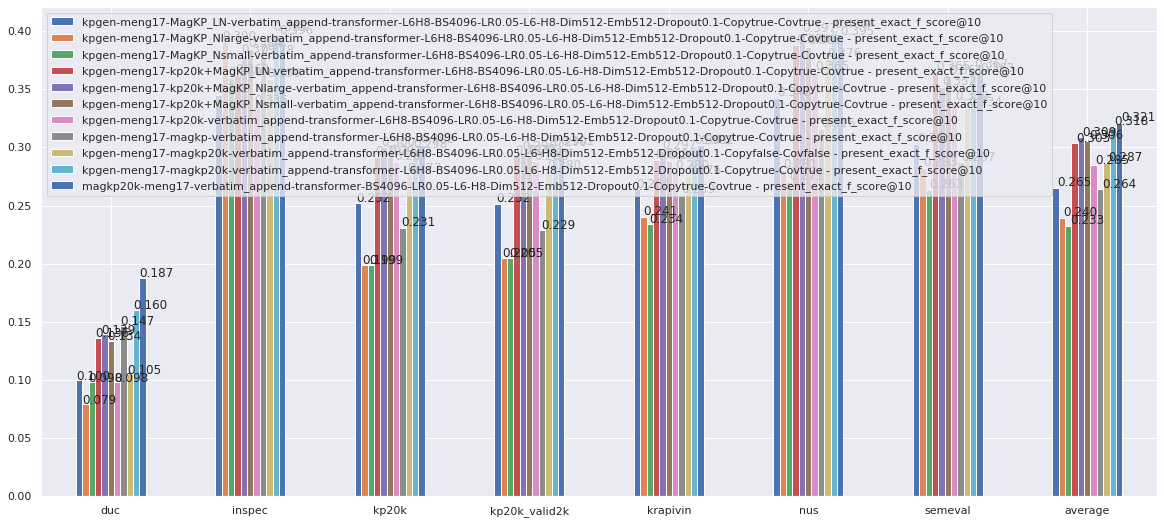

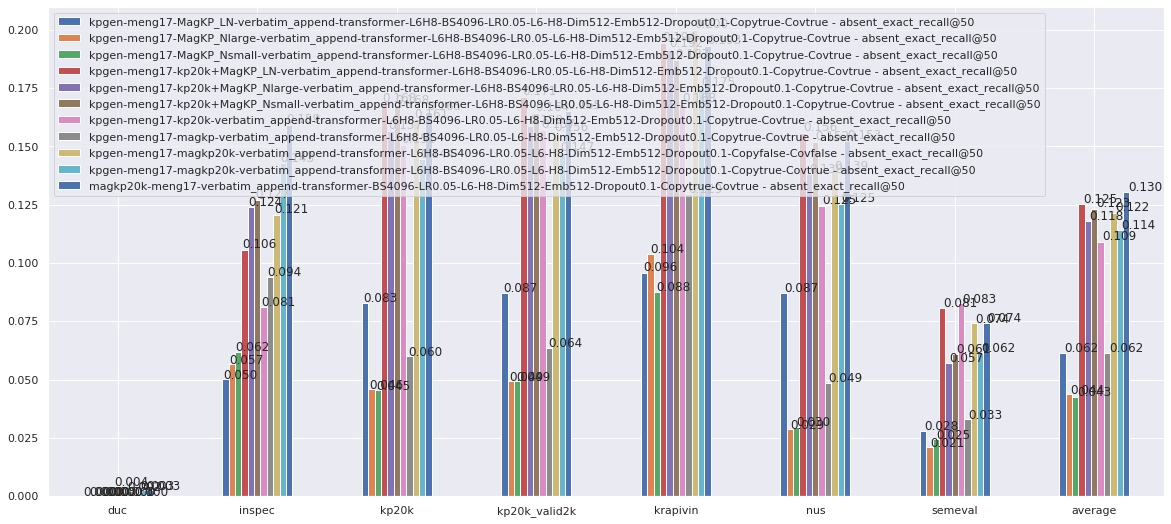

In [68]:
# 2. Compare different architecture variants
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
# pd.options.display.max_colwidth = 100

kp_exps = [
    'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',   
    
    'kpgen-meng17-MagKP_LN-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    'kpgen-meng17-MagKP_Nsmall-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    'kpgen-meng17-MagKP_Nlarge-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    'kpgen-meng17-magkp-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

    'kpgen-meng17-kp20k+MagKP_LN-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',   
    'kpgen-meng17-kp20k+MagKP_Nsmall-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
    'kpgen-meng17-kp20k+MagKP_Nlarge-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',   
    'kpgen-meng17-magkp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

    'kpgen-meng17-magkp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copyfalse-Covfalse',
    'magkp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
]    

# prepare one2seq data
kp_df = all_eval_df.loc[all_eval_df['exp_name'].isin(kp_exps)]
kp_df = kp_df.loc[kp_df.step % 5000 == 0] # keep % 10000
kp_df = kp_df.sort_values(by='step', ascending=True)
kp_df = kp_df.loc[kp_df.beam_width == '50']
kp_df = kp_df.loc[kp_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam
kp_df = kp_df.loc[kp_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating

# kp_df = kp_df.loc[kp_df.test_dataset != 'kp20k']

print('All data')
print(kp_df.shape)

print('present valid_kp_df')
_, _, valid_kp_df = brief_eval_results(kp_df, base_metric='present_exact_f_score@10')
print(valid_kp_df.shape)
# display(valid_kp_df)


metric_names = ['present_exact_f_score@5', 'present_exact_f_score@10', 'present_exact_f_score@k']
metric_names = ['present_exact_advanced_sadr']
metric_names = ['present_exact_f_score@10']

datasets = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'average')

df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))    
    

pd.options.display.float_format = '{:,.1f}'.format
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', None):
    value_cols = ['present_exact_f_score@5', 'present_exact_f_score@10', 'present_exact_f_score@k']
    tmp_df = valid_kp_df[['exp_name', 'model_base', 'train_dataset', 'test_dataset'] + value_cols]
    for col in value_cols:
        tmp_df[col] = tmp_df[col].map(lambda v: v * 100.0)

#     tmp_df.columns = [' '.join(c.split('_')) for c in tmp_df.columns]
#     display(tmp_df)
    df_list = []
    for exp in kp_exps:
        for i in ordered_datasets:
            df_list.append(tmp_df[(tmp_df['exp_name']==exp) & (tmp_df['test_dataset']==i)])
    ordered_df = pd.concat(df_list)
    tmp_df = ordered_df[value_cols]
    
#     display(ordered_df)
#     print(tmp_df.to_latex(index=False))
    

############## absent
print('All data')
print(kp_df.shape)
print('absent valid_kp_df')
_, _, valid_kp_df = brief_eval_results(kp_df, base_metric='absent_exact_recall@50')

# ensure the dataframe is sorted first
print(valid_kp_df.shape)
# display(valid_kp_df)

# metric_names = ['absent_exact_recall@10', 'absent_exact_recall@50', 'absent_exact_advanced_sadr']
metric_names = ['absent_exact_recall@50']


datasets = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}

for index_label, row_series in valid_kp_df.iterrows():
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'average')

df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))  
# display(df.transpose())

    
pd.options.display.float_format = '{:,.1f}'.format
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', None):
    value_cols = ['absent_exact_recall@10', 'absent_exact_recall@50']
    tmp_df = valid_kp_df[['exp_name', 'model_base', 'train_dataset', 'test_dataset'] + value_cols]
    for col in value_cols:
        tmp_df[col] = tmp_df[col].map(lambda v: v * 100.0)

#     tmp_df.columns = [' '.join(c.split('_')) for c in tmp_df.columns]
    df_list = []
    for exp in kp_exps:
        for i in ordered_datasets:
            df_list.append(tmp_df[(tmp_df['exp_name']==exp) & (tmp_df['test_dataset']==i)])
    ordered_df = pd.concat(df_list)
    tmp_df = ordered_df[value_cols]

#     display(ordered_df)
#     print(tmp_df.to_latex(index=False))


### Fine-tune KP20k after MagKP

All data
(280, 121)
['kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1'
 'magkp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue']
present valid_kp_df
(14, 121)
All data
(280, 121)
absent valid_kp_df


/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(14, 121)


/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


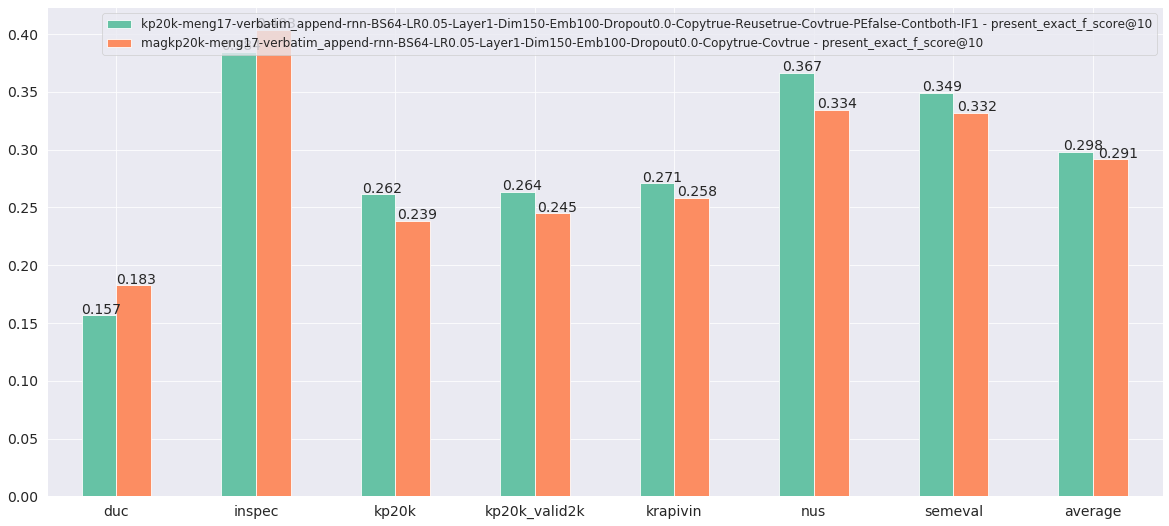

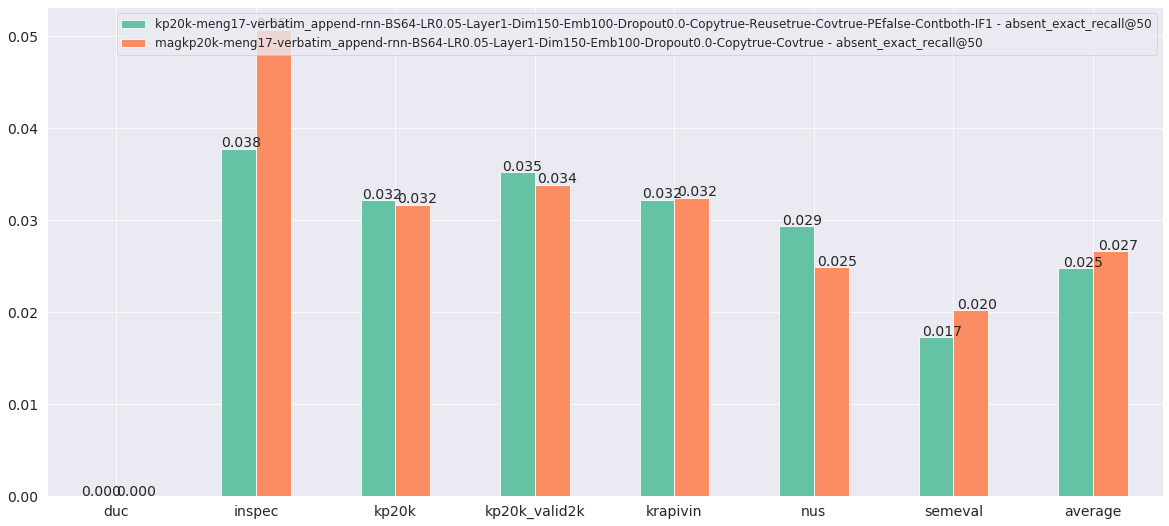

In [116]:
# 2. Compare different architecture variants
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

ordered_datasets = ['kp20k', 'inspec', 'krapivin', 'nus', 'semeval', 'duc', 'average']

kp_exps = [
'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1',
'magkp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue',
    
# 'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',   

# 'kpgen-meng17-kp20k+MagKP_LN-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',   
# 'kpgen-meng17-kp20k+MagKP_Nsmall-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'kpgen-meng17-kp20k+MagKP_Nlarge-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',   
# 'kpgen-meng17-magkp-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'kpgen-meng17-magkp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

# 'kpgen-meng17-magkp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

# 'kpgen-meng17-MagKP_LN+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'kpgen-meng17-MagKP_Nlarge+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'kpgen-meng17-MagKP_Nsmall+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'kpgen-meng17-magkp+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'kpgen-meng17-magkp20k+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue'
]    

# prepare one2seq data
kp_df = all_eval_df.loc[all_eval_df['exp_name'].isin(kp_exps)]
kp_df = kp_df.loc[(kp_df.step % 10000 == 6000) | (kp_df.step % 5000 == 0)]
kp_df = kp_df.sort_values(by='step', ascending=True)
kp_df = kp_df.loc[kp_df.beam_width == '50']
kp_df = kp_df.loc[kp_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam
kp_df = kp_df.loc[kp_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating


print('All data')
print(kp_df.shape)
print(kp_df.exp_name.unique())

print('present valid_kp_df')
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='present_exact_f_score@10')
print(valid_kp_df.shape)
# display(valid_kp_df)


metric_names = ['present_exact_f_score@5', 'present_exact_f_score@10', 'present_exact_f_score@k']
metric_names = ['present_exact_advanced_sadr']
metric_names = ['present_exact_f_score@10']
# metric_names = ['present_exact_advanced_alpha_ndcg@5']


datasets = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'average')

df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))    
    

pd.options.display.float_format = '{:,.1f}'.format
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', None):
    value_cols = ['present_exact_f_score@5', 'present_exact_f_score@10', 'present_exact_f_score@k']
    tmp_df = valid_kp_df[['exp_name', 'model_base', 'train_dataset', 'test_dataset'] + value_cols]
    for col in value_cols:
        tmp_df[col] = tmp_df[col].map(lambda v: v * 100.0)

#     tmp_df.columns = [' '.join(c.split('_')) for c in tmp_df.columns]
#     display(tmp_df)
    df_list = []
    for exp in kp_exps:
        for i in ordered_datasets:
            df_list.append(tmp_df[(tmp_df['exp_name']==exp) & (tmp_df['test_dataset']==i)])
    ordered_df = pd.concat(df_list)
    tmp_df = ordered_df[value_cols]
    
#     display(ordered_df)
#     print(tmp_df.to_latex(index=False))
    

############## absent
print('All data')
print(kp_df.shape)
print('absent valid_kp_df')
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='absent_exact_recall@50')

# ensure the dataframe is sorted first
print(valid_kp_df.shape)
# display(valid_kp_df)

# metric_names = ['absent_exact_recall@10', 'absent_exact_recall@50', 'absent_exact_advanced_sadr']
metric_names = ['absent_exact_recall@50']


datasets = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in exp_names for metric_name in metric_names}

for index_label, row_series in valid_kp_df.iterrows():
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))
datasets = np.append(datasets, 'average')

df = pd.DataFrame(bar_values, index=datasets)
ax = df.plot.bar(figsize=(20,9), rot=0)

for p in ax.patches:
    ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))  
# display(df.transpose())

    
pd.options.display.float_format = '{:,.1f}'.format
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', None):
    value_cols = ['absent_exact_recall@10', 'absent_exact_recall@50']
    tmp_df = valid_kp_df[['exp_name', 'model_base', 'train_dataset', 'test_dataset'] + value_cols]
    for col in value_cols:
        tmp_df[col] = tmp_df[col].map(lambda v: v * 100.0)

#     tmp_df.columns = [' '.join(c.split('_')) for c in tmp_df.columns]
    df_list = []
    for exp in kp_exps:
        for i in ordered_datasets:
            df_list.append(tmp_df[(tmp_df['exp_name']==exp) & (tmp_df['test_dataset']==i)])
    ordered_df = pd.concat(df_list)
    tmp_df = ordered_df[value_cols]

#     display(ordered_df)
#     print(tmp_df.to_latex(index=False))


### Summary (used in paper, Section 5 "more data", Figure 4/6)

#### MagKP results (alternate batching) (Paper Figure 4)

absent
(56, 236)


Text(0, 0.5, 'Absent (R@50)')

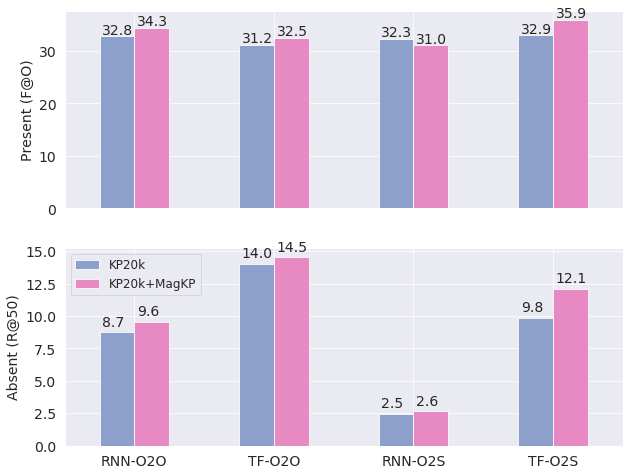

In [20]:
long2short = {
'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1': 'KP20k - RNN-O2O',
'kpgen-meng17-kp20k-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue': 'KP20k - TF-O2O',
'magkp20k-meng17-one2one-BS128-LR0.05-L1-H-D150-E100-DO0.0-Copytrue': 'KP20k+MagKP - RNN-O2O',
'magkp20k-meng17-one2one-transformer-BS4096-LR0.05-L6-H8-D512-E512-DO0.1-Copytrue': 'KP20k+MagKP - TF-O2O',
        
'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1': 'KP20k - RNN-O2S',
'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue': 'KP20k - TF-O2S',
'magkp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue': 'KP20k+MagKP - RNN-O2S',
'magkp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue': 'KP20k+MagKP - TF-O2S',

}

kp_df = all_eval_df.loc[all_eval_df['exp_name'].isin(long2short)]
kp_df = kp_df.loc[(kp_df.step % 10000 == 6000) | (kp_df.step % 5000 == 0)]
kp_df = kp_df.sort_values(by='step', ascending=True)
kp_df = kp_df.loc[(kp_df.beam_width == '50') | (kp_df.beam_width == '200')]
kp_df = kp_df.loc[kp_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam
kp_df = kp_df.loc[kp_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating

# for exp_name in kp_df['exp_name'].unique():
#     print(exp_name, kp_df.loc[kp_df.exp_name == exp_name].shape)
for index_label, row_series in kp_df.iterrows():
    kp_df.at[index_label , 'exp_name'] = long2short[kp_df.at[index_label , 'exp_name']]
# for exp_name in kp_df['exp_name'].unique():
#     print(exp_name, kp_df.loc[kp_df.exp_name == exp_name].shape)
    
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='present_exact_f_score@k')
# print('present')
# print(valid_kp_df.shape)
metric_names = ['present_exact_f_score@k']

datasets = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {exp_name: [] for exp_name in exp_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values[row_series.exp_name].append(float(bar_value))

datamodel_names = bar_values.keys()
model_names = ['RNN-O2O', 'TF-O2O', 'RNN-O2S', 'TF-O2S']
avg_bar_values = {'KP20k': [0.0] * 4, 'KP20k+MagKP': [0.0] * 4}

# compute average scores over all datasets except for KP20k_valid2k
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for datamodel_name, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
#     print(datamodel_name)
#     print(_v)
    data_name, model_name = datamodel_name.split(' - ')
    avg_bar_values[data_name][model_names.index(model_name)] = np.mean(_v)
datasets = np.append(datasets, 'Average')

present_df = pd.DataFrame(avg_bar_values, index=model_names)
# display(present_df)
# ax = present_df.plot.bar(figsize=(20,9), rot=0)
# for p in ax.patches:
#     ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   


###### Absent 
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='absent_exact_recall@50')
print('absent')
print(valid_kp_df.shape)
metric_names = ['absent_exact_recall@50']

datasets = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {exp_name: [] for exp_name in exp_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values[row_series.exp_name].append(float(bar_value))

datamodel_names = bar_values.keys()
model_names = ['RNN-O2O', 'TF-O2O', 'RNN-O2S', 'TF-O2S']
avg_bar_values = {'KP20k': [0.0] * 4, 'KP20k+MagKP': [0.0] * 4}

# compute average scores over all datasets except for KP20k_valid2k
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for datamodel_name, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    data_name, model_name = datamodel_name.split(' - ')
    avg_bar_values[data_name][model_names.index(model_name)] = np.mean(_v)
datasets = np.append(datasets, 'Average')

# print(avg_bar_values)
    
absent_df = pd.DataFrame(avg_bar_values, index=model_names)
# ax = df.plot.bar(figsize=(20,9), rot=0)
# for p in ax.patches:
#     ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   


# Set up the matplotlib figure

sns.set_context("paper", rc={"font.size": 14,
                             "axes.titlesize": 14,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})
sns.set_palette("Set2")
_set2 = sns.color_palette("Set2").as_hex()
sns.set_palette(_set2[2:])

present_df = present_df * 100.0
absent_df = absent_df * 100.0

f, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
present_df.plot.bar(ax=axes[0], legend=False, rot=0)
for p in axes[0].patches:
    axes[0].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.02, p.get_height() + 0.5), rotation=0)  
axes[0].set_ylabel("Present (F@O)")

absent_df.plot.bar(ax=axes[1], rot=0)
for p in axes[1].patches:
    axes[1].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.02, p.get_height() + 0.5), rotation=0)    
axes[1].set_ylabel("Absent (R@50)") 



#### Transformer-One2Seq + finetuning (Paper Figure 6)

{'KP20k': [0.0, 0.3292538448836406, 0.0, 0.0], 'MagKP-LN': [0.0, 0.27605325562794386, 0.3440636217418103, 0.3463920799738904], 'MagKP-Nsmall': [0.0, 0.23339137320034456, 0.3354558662744714, 0.356921643462544], 'MagKP-Nlarge': [0.0, 0.23570759386304926, 0.34667951353463256, 0.3660799341111071], 'MagKP': [0.35859440972292217, 0.27331419923584616, 0.3494334040780327, 0.3631881687268496]}


KP20k  MagKP-LN  MagKP-Nsmall  MagKP-Nlarge  MagKP
ALT  0.0    0.0       0.0           0.0           0.4   
Only 0.3    0.3       0.2           0.2           0.3   
MX   0.0    0.3       0.3           0.3           0.3   
FT   0.0    0.3       0.4           0.4           0.4

absent
(98, 236)


(3, 15)

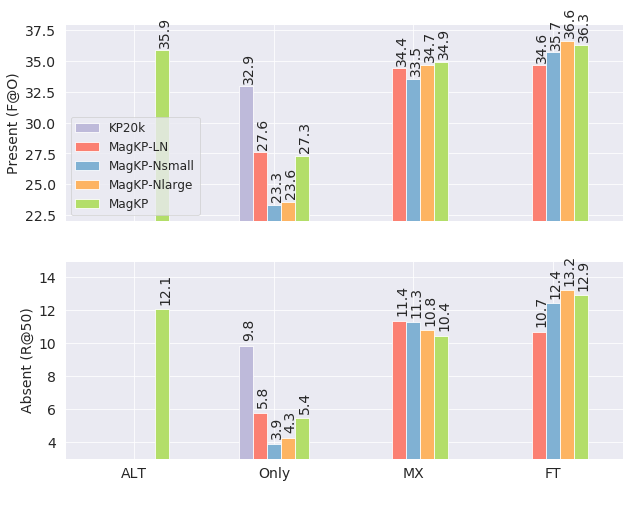

In [21]:
short2long = {
'MagKP - ALT': 'magkp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

'KP20k - Only': 'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'MagKP-LN - Only': 'kpgen-meng17-MagKP_LN-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'MagKP-LN - MX': 'kpgen-meng17-kp20k+MagKP_LN-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'MagKP-LN - FT': 'kpgen-meng17-MagKP_LN+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

'MagKP-Nsmall - Only': 'kpgen-meng17-MagKP_Nsmall-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'MagKP-Nsmall - MX': 'kpgen-meng17-kp20k+MagKP_Nsmall-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue', 
'MagKP-Nsmall - FT': 'kpgen-meng17-MagKP_Nsmall+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

'MagKP-Nlarge - Only': 'kpgen-meng17-MagKP_Nlarge-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'MagKP-Nlarge - MX': 'kpgen-meng17-kp20k+MagKP_Nlarge-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'MagKP-Nlarge - FT': 'kpgen-meng17-MagKP_Nlarge+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

'MagKP - Only': 'kpgen-meng17-magkp-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'MagKP - MX': 'kpgen-meng17-magkp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'MagKP - FT': 'kpgen-meng17-magkp+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
}

long2short = {long: short for short, long in short2long.items()}
mode_names = ['ALT', 'Only', 'MX', 'FT']
traindata_names = ['KP20k', 'MagKP-LN', 'MagKP-Nsmall', 'MagKP-Nlarge', 'MagKP']

kp_df = all_eval_df.loc[all_eval_df['exp_name'].isin(long2short)]
kp_df = kp_df.loc[(kp_df.step % 10000 == 6000) | (kp_df.step % 5000 == 0)]
kp_df = kp_df.sort_values(by='step', ascending=True)
kp_df = kp_df.loc[(kp_df.beam_width == '50') | (kp_df.beam_width == '200')]
kp_df = kp_df.loc[kp_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam
kp_df = kp_df.loc[kp_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating

# for exp_name in kp_df['exp_name'].unique():
#     print(exp_name, kp_df.loc[kp_df.exp_name == exp_name].shape)
for index_label, row_series in kp_df.iterrows():
    kp_df.at[index_label , 'exp_name'] = long2short[kp_df.at[index_label , 'exp_name']]
# for exp_name in kp_df['exp_name'].unique():
#     print(exp_name, kp_df.loc[kp_df.exp_name == exp_name].shape)
    
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='present_exact_f_score@k')
metric_names = ['present_exact_f_score@k']

datasets = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {exp_name: [] for exp_name in exp_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values[row_series.exp_name].append(float(bar_value))

datamode_names = bar_values.keys()
avg_bar_values = {dname: [0.0] * len(mode_names) for dname in traindata_names}

# compute average scores over all datasets except for KP20k_valid2k
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for datamode_name, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
#     print(datamode_name)
#     print(_v)
    data_name, mode_name = datamode_name.split(' - ')
    avg_bar_values[data_name][mode_names.index(mode_name)] = np.mean(_v)
datasets = np.append(datasets, 'Average')
present_df = pd.DataFrame(avg_bar_values, index=mode_names)

print(avg_bar_values)
display(present_df)
# ax = present_df.plot.bar(figsize=(20,9), rot=0)
# for p in ax.patches:
#     ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   


###### Absent 
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='absent_exact_recall@50')
print('absent')
print(valid_kp_df.shape)
metric_names = ['absent_exact_recall@50']

datasets = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {exp_name: [] for exp_name in exp_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values[row_series.exp_name].append(float(bar_value))

datamode_names = bar_values.keys()
avg_bar_values = {dname: [0.0] * len(mode_names) for dname in traindata_names}

# compute average scores over all datasets except for KP20k_valid2k
kp20k_valid2k_idx = datasets.tolist().index('kp20k_valid2k')
for datamode_name, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    data_name, mode_name = datamode_name.split(' - ')
    avg_bar_values[data_name][mode_names.index(mode_name)] = np.mean(_v)
datasets = np.append(datasets, 'Average')

# print(avg_bar_values)
    
absent_df = pd.DataFrame(avg_bar_values, index=mode_names)
# ax = df.plot.bar(figsize=(20,9), rot=0)
# for p in ax.patches:
#     ax.annotate('%.3f' % (p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))   


# Set up the matplotlib figure

sns.set_context("paper", rc={"font.size": 14,
                             "axes.titlesize": 14,
                             "axes.labelsize": 14,
                             "xtick.labelsize": 14,
                             "ytick.labelsize": 14,
                             "legend.fontsize": 12})

_set2 = sns.color_palette("Set3").as_hex()
sns.set_palette(_set2[2:])

present_df = present_df * 100.0
absent_df = absent_df * 100.0
# present_df = present_df.replace(0.0, np.NaN)
# display(present_df)
f, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
g = present_df.plot.bar(ax=axes[0], legend=True, rot=0)
for p in axes[0].patches:
    axes[0].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.02, p.get_height() + 0.5), rotation=90)   
axes[0].set_ylabel("Present (F@O)")
axes[0].legend(loc='lower left')
g.set_ylim(22, 38)

g = absent_df.plot.bar(ax=axes[1], legend=False, rot=0)
for p in axes[1].patches:
    axes[1].annotate('%.1f' % (p.get_height()), (p.get_x() + 0.02, p.get_height() + 0.5), rotation=90)    
axes[1].set_ylabel("Absent (R@50)") 
g.set_ylim(3, 15)



## Export to Latex format

### Export selected experiments

In [33]:
# 2. Compare different architecture variants
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.options.display.float_format = '{:,.1f}'.format


short2long = {
# One2One
# 'RNN-O2O-KP20k': 'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1',
# 'RNN-O2O-KP20k-nocopy': 'kp20k-meng17-one2one-BS128-LR0.05-L1-D150-E100-DO0.0-Copyfalse-Covfalse',
# 'RNN-O2O-KP20k+MagKP-ALT': 'magkp20k-meng17-one2one-BS128-LR0.05-L1-H-D150-E100-DO0.0-Copytrue',

# 'BIGRNN-O2O-KP20k': 'kp20k-meng17-one2one-BS128-LR0.05-L1-H8-D512-E128-DO0.1-Copytrue',
# 'BIGRNN-O2O-magkp20k-ALT': 'magkp20k-meng17-one2one-BS128-LR0.05-L1-D512-E128-DO0.1-Copytrue',

# 'TF-O2O-KP20k': 'kpgen-meng17-kp20k-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'TF-O2O-KP20k-nocopy': 'kpgen-meng17-kp20k-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copyfalse-Covfalse',
# 'TF-O2O-KP20k+MagKP-ALT': 'magkp20k-meng17-one2one-transformer-BS4096-LR0.05-L6-H8-D512-E512-DO0.1-Copytrue',

    
# One2Seq
# 'RNN-O2S-KP20k': 'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1',
# 'RNN-O2S-KP20k-nocopy': 'kp20k-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copyfalse',
# 'RNN-O2S+KP20k+MagKP-ALT': 'magkp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue',

# 'BIGRNN-O2S-KP20k': 'kp20k-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim512-Emb128-Dropout0.1-Copytrue',
# 'BIGRNN-O2S-KP20k+MagKP-ALT': 'magkp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim512-Emb128-Dropout0.1-Copytrue-Covtrue',
    
# 'TF-O2S-KP20k': 'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'TF-O2S-KP20k-nocopy': 'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copyfalse-Covfalse',
# 'TF-O2S-KP20k+MagKP-ALT': 'magkp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',


# +MagKP FT
# 'MagKP-LN-Only': 'kpgen-meng17-MagKP_LN-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'MagKP-Nsmall-Only': 'kpgen-meng17-MagKP_Nsmall-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'MagKP-Nlarge-Only': 'kpgen-meng17-MagKP_Nlarge-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'MagKP-Only': 'kpgen-meng17-magkp-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

# 'MagKP-LN-MX': 'kpgen-meng17-kp20k+MagKP_LN-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'MagKP-Nsmall-MX': 'kpgen-meng17-kp20k+MagKP_Nsmall-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue', 
# 'MagKP-Nlarge-MX': 'kpgen-meng17-kp20k+MagKP_Nlarge-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'MagKP-MX': 'kpgen-meng17-magkp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

# 'MagKP-LN-FT': 'kpgen-meng17-MagKP_LN+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'MagKP-Nsmall-FT': 'kpgen-meng17-MagKP_Nsmall+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'MagKP-Nlarge-FT': 'kpgen-meng17-MagKP_Nlarge+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'MagKP-FT': 'kpgen-meng17-magkp+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

    
# Order matters
'rnn+random': 'kp20k-meng17-random-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1', 
'rnn+alphab': 'kp20k-meng17-alphabetical-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1', 
'rnn+alpharev': 'kpgen-meng17-kp20k-alphabetical_reverse-rnn-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue',
'rnn+stol': 'kp20k-meng17-length-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1', 
'rnn+ltos': 'kpgen-meng17-kp20k-length_reverse-rnn-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue',
'rnn+ori': 'kp20k-meng17-no_sort-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1', 
'rnn+orirev': 'kpgen-meng17-kp20k-no_sort_reverse-rnn-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue',
'rnn+presabs': 'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1',
'rnn+abspres': 'kp20k-meng17-verbatim_prepend-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1', 

    
    
'transformer+random': 'kpgen-meng17-kp20k-random-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',    
'transformer+alphab': 'kpgen-meng17-kp20k-alphabetical-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'transformer+alpharev': 'kpgen-meng17-kp20k-alphabetical_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'transformer+stol': 'kpgen-meng17-kp20k-length-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'transformer+ltos': 'kpgen-meng17-kp20k-length_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'transformer+ori': 'kpgen-meng17-kp20k-no_sort-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'transformer+orirev': 'kpgen-meng17-kp20k-no_sort_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'transformer+presabs': 'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',   
'transformer+abspres': 'kpgen-meng17-kp20k-verbatim_prepend-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

}
long2short = {long: short for short, long in short2long.items()}
kp_df = all_eval_df.loc[all_eval_df['exp_name'].isin(long2short)]
kp_df = kp_df.loc[(kp_df.step % 10000 == 6000) | (kp_df.step % 5000 == 0)]
kp_df = kp_df.sort_values(by='step', ascending=True)
kp_df = kp_df.loc[kp_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam
# beam search
kp_df = kp_df.loc[(kp_df.beam_width == '50') | (kp_df.beam_width == '200')]
kp_df = kp_df.loc[kp_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating
# greedy
# kp_df = kp_df.loc[(kp_df.beam_width == '1')]
# kp_df = kp_df.loc[kp_df.decoding_method == 'exhaustive']

for index_label, row_series in kp_df.iterrows():
    kp_df.at[index_label , 'exp_name'] = long2short[kp_df.at[index_label , 'exp_name']]

    
# present
ordered_datasets = ['average', 'kp20k', 'krapivin', 'inspec', 'nus', 'semeval', 'duc']
metric_names = ['present_exact_f_score@5', 'present_exact_f_score@10', 'present_exact_f_score@k', 'present_exact_f_score@M']

_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='present_exact_f_score@k')
# display(valid_kp_df)

df_dataset_list = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in short2long.keys() for metric_name in metric_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = df_dataset_list.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))

# print(bar_values)
df_dataset_list = np.append(df_dataset_list, 'average').tolist()

transposed_dict = {'%s - %s' % (dataset_name, metric_name): [0.0] * len(short2long) for dataset_name in ordered_datasets for metric_name in metric_names}
for exp_metric_name, scores in bar_values.items():
    exp_shortname, metric_name = exp_metric_name.split(' - ')
    for dataset_name in ordered_datasets:
        dataset_idx_in_scores = df_dataset_list.index(dataset_name)
        score = scores[dataset_idx_in_scores]
        exp_idx = list(short2long.keys()).index(exp_shortname)
        transposed_dict[dataset_name+' - '+metric_name][exp_idx] = score

present_df = pd.DataFrame(transposed_dict, index=short2long.keys()) * 100.0       
        
pd.options.display.float_format = '{:,.1f}'.format
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', None):
    print(present_df.to_latex(index=True))
#     display(present_df)
    
    
    
############## absent
metric_names = ['absent_exact_recall@10', 'absent_exact_recall@50', 'absent_exact_recall@M']
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='absent_exact_recall@50')
# display(valid_kp_df)

df_dataset_list = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in short2long.keys() for metric_name in metric_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = df_dataset_list.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))

# print(bar_values)
df_dataset_list = np.append(df_dataset_list, 'average').tolist()

transposed_dict = {'%s - %s' % (dataset_name, metric_name): [0.0] * len(short2long) for dataset_name in ordered_datasets for metric_name in metric_names}
for exp_metric_name, scores in bar_values.items():
    exp_shortname, metric_name = exp_metric_name.split(' - ')
    for dataset_name in ordered_datasets:
        dataset_idx_in_scores = df_dataset_list.index(dataset_name)
        score = scores[dataset_idx_in_scores]
        exp_idx = list(short2long.keys()).index(exp_shortname)
        transposed_dict[dataset_name+' - '+metric_name][exp_idx] = score

present_df = pd.DataFrame(transposed_dict, index=short2long.keys()) * 100.0       
        
pd.options.display.float_format = '{:,.1f}'.format
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', None):
    print(present_df.to_latex(index=True))
#     display(present_df)


    
# '''    
############## all
metric_names = ['all_exact_f_score@5', 'all_exact_f_score@10', 'all_exact_f_score@k', 'all_exact_f_score@M']
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='all_exact_f_score@k')
# display(valid_kp_df)

df_dataset_list = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

bar_values = {'%s - %s' % (exp_name, metric_name): [] for exp_name in short2long.keys() for metric_name in metric_names}
for index_label, row_series in valid_kp_df.iterrows():   
    for metric_name in metric_names:
        bar_value = row_series[metric_name]
        bar_values['%s - %s' % (row_series.exp_name, metric_name)].append(float(bar_value))

kp20k_valid2k_idx = df_dataset_list.tolist().index('kp20k_valid2k')
for k, v in bar_values.items():
    _v = [e for i,e in enumerate(v) if i != kp20k_valid2k_idx]
    bar_values[k].append(np.mean(_v))

# print(bar_values)
df_dataset_list = np.append(df_dataset_list, 'average').tolist()

transposed_dict = {'%s - %s' % (dataset_name, metric_name): [0.0] * len(short2long) for dataset_name in ordered_datasets for metric_name in metric_names}
for exp_metric_name, scores in bar_values.items():
    exp_shortname, metric_name = exp_metric_name.split(' - ')
    for dataset_name in ordered_datasets:
        dataset_idx_in_scores = df_dataset_list.index(dataset_name)
        score = scores[dataset_idx_in_scores]
        exp_idx = list(short2long.keys()).index(exp_shortname)
        transposed_dict[dataset_name+' - '+metric_name][exp_idx] = score

present_df = pd.DataFrame(transposed_dict, index=short2long.keys()) * 100.0       
        
pd.options.display.float_format = '{:,.1f}'.format
with pd.option_context('display.max_colwidth', -1, 'display.max_rows', None):
    print(present_df.to_latex(index=True))
#     display(present_df)

# '''

/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


\begin{tabular}{lrrrrrrrrrrrrrrrrrrrrrrrrrrrr}
\toprule
{} &  average - all\_exact\_f\_score@5 &  average - all\_exact\_f\_score@10 &  average - all\_exact\_f\_score@k &  average - all\_exact\_f\_score@M &  kp20k - all\_exact\_f\_score@5 &  kp20k - all\_exact\_f\_score@10 &  kp20k - all\_exact\_f\_score@k &  kp20k - all\_exact\_f\_score@M &  krapivin - all\_exact\_f\_score@5 &  krapivin - all\_exact\_f\_score@10 &  krapivin - all\_exact\_f\_score@k &  krapivin - all\_exact\_f\_score@M &  inspec - all\_exact\_f\_score@5 &  inspec - all\_exact\_f\_score@10 &  inspec - all\_exact\_f\_score@k &  inspec - all\_exact\_f\_score@M &  nus - all\_exact\_f\_score@5 &  nus - all\_exact\_f\_score@10 &  nus - all\_exact\_f\_score@k &  nus - all\_exact\_f\_score@M &  semeval - all\_exact\_f\_score@5 &  semeval - all\_exact\_f\_score@10 &  semeval - all\_exact\_f\_score@k &  semeval - all\_exact\_f\_score@M &  duc - all\_exact\_f\_score@5 &  duc - all\_exact\_f\_score@10 &  duc - all\_exact\_f\_score@

#### Export to CSV lines

In [19]:
# 2. Compare different architecture variants
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.options.display.float_format = '{:,.1f}'.format


short2long = {
# One2One
'RNN-O2O-KP20k': 'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1',
'RNN-O2O-KP20k-nocopy': 'kp20k-meng17-one2one-BS128-LR0.05-L1-D150-E100-DO0.0-Copyfalse-Covfalse',
'RNN-O2O-KP20k+MagKP-ALT': 'magkp20k-meng17-one2one-BS128-LR0.05-L1-H-D150-E100-DO0.0-Copytrue',

'BIGRNN-O2O-KP20k': 'kp20k-meng17-one2one-BS128-LR0.05-L1-H8-D512-E128-DO0.1-Copytrue',
'BIGRNN-O2O-magkp20k-ALT': 'magkp20k-meng17-one2one-BS128-LR0.05-L1-D512-E128-DO0.1-Copytrue',

'TF-O2O-KP20k': 'kpgen-meng17-kp20k-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'TF-O2O-KP20k-nocopy': 'kpgen-meng17-kp20k-one2one-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copyfalse-Covfalse',
'TF-O2O-KP20k+MagKP-ALT': 'magkp20k-meng17-one2one-transformer-BS4096-LR0.05-L6-H8-D512-E512-DO0.1-Copytrue',

    
# One2Seq
'RNN-O2S-KP20k': 'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1',
'RNN-O2S-KP20k-nocopy': 'kp20k-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copyfalse',
'RNN-O2S+KP20k+MagKP-ALT': 'magkp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue',

'BIGRNN-O2S-KP20k': 'kp20k-meng17-verbatim_append-rnn-BS64-OPTadagrad-LR0.05-Layer1-Dim512-Emb128-Dropout0.1-Copytrue',
'BIGRNN-O2S-KP20k+MagKP-ALT': 'magkp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim512-Emb128-Dropout0.1-Copytrue-Covtrue',
    
'TF-O2S-KP20k': 'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'TF-O2S-KP20k-nocopy': 'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copyfalse-Covfalse',
'TF-O2S-KP20k+MagKP-ALT': 'magkp20k-meng17-verbatim_append-transformer-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',


# +MagKP FT
# 'MagKP-LN-Only': 'kpgen-meng17-MagKP_LN-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'MagKP-Nsmall-Only': 'kpgen-meng17-MagKP_Nsmall-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'MagKP-Nlarge-Only': 'kpgen-meng17-MagKP_Nlarge-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'MagKP-Only': 'kpgen-meng17-magkp-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

# 'MagKP-LN-MX': 'kpgen-meng17-kp20k+MagKP_LN-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'MagKP-Nsmall-MX': 'kpgen-meng17-kp20k+MagKP_Nsmall-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue', 
# 'MagKP-Nlarge-MX': 'kpgen-meng17-kp20k+MagKP_Nlarge-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'MagKP-MX': 'kpgen-meng17-magkp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

'MagKP-LN-FT': 'kpgen-meng17-MagKP_LN+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'MagKP-Nsmall-FT': 'kpgen-meng17-MagKP_Nsmall+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'MagKP-Nlarge-FT': 'kpgen-meng17-MagKP_Nlarge+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
'MagKP-FT': 'kpgen-meng17-magkp+kp20kFT-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

    
# Order matters
# 'rnn+random': 'kp20k-meng17-random-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1', 
# 'rnn+alphab': 'kp20k-meng17-alphabetical-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1', 
# 'rnn+alpharev': 'kpgen-meng17-kp20k-alphabetical_reverse-rnn-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue',
# 'rnn+stol': 'kp20k-meng17-length-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1', 
# 'rnn+ltos': 'kpgen-meng17-kp20k-length_reverse-rnn-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue',
# 'rnn+ori': 'kp20k-meng17-no_sort-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1', 
# 'rnn+orirev': 'kpgen-meng17-kp20k-no_sort_reverse-rnn-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue',
# 'rnn+presabs': 'kp20k-meng17-verbatim_append-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1',
# 'rnn+abspres': 'kp20k-meng17-verbatim_prepend-rnn-BS64-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Reusetrue-Covtrue-PEfalse-Contboth-IF1', 

    
    
# 'transformer+random': 'kpgen-meng17-kp20k-random-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',    
# 'transformer+alphab': 'kpgen-meng17-kp20k-alphabetical-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'transformer+alpharev': 'kpgen-meng17-kp20k-alphabetical_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'transformer+stol': 'kpgen-meng17-kp20k-length-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'transformer+ltos': 'kpgen-meng17-kp20k-length_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'transformer+ori': 'kpgen-meng17-kp20k-no_sort-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'transformer+orirev': 'kpgen-meng17-kp20k-no_sort_reverse-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',
# 'transformer+presabs': 'kpgen-meng17-kp20k-verbatim_append-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',   
# 'transformer+abspres': 'kpgen-meng17-kp20k-verbatim_prepend-transformer-L6H8-BS4096-LR0.05-L6-H8-Dim512-Emb512-Dropout0.1-Copytrue-Covtrue',

}
long2short = {long: short for short, long in short2long.items()}
kp_df = all_eval_df.loc[all_eval_df['exp_name'].isin(long2short)]
kp_df = kp_df.loc[(kp_df.step % 10000 == 6000) | (kp_df.step % 5000 == 0)]
kp_df = kp_df.sort_values(by='step', ascending=True)
kp_df = kp_df.loc[kp_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam
# beam search
kp_df = kp_df.loc[(kp_df.beam_width == '50') | (kp_df.beam_width == '200')]
kp_df = kp_df.loc[kp_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating
# greedy
# kp_df = kp_df.loc[(kp_df.beam_width == '1')]
# kp_df = kp_df.loc[kp_df.decoding_method == 'exhaustive']

for index_label, row_series in kp_df.iterrows():
    kp_df.at[index_label , 'exp_name'] = long2short[kp_df.at[index_label , 'exp_name']]

    
# present
ordered_datasets = ['kp20k', 'kp20k_valid2k', 'krapivin', 'inspec', 'nus', 'semeval', 'duc']
ordered_datasets = ['duc']
metric_names = ['present_exact_f_score@5', 'present_exact_f_score@10', 'present_exact_f_score@k', 'present_exact_f_score@M']

anchor_metric_name = 'present_exact_f_score@k'
_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric=anchor_metric_name)
# display(valid_kp_df)

df_dataset_list = valid_kp_df.test_dataset.unique()
exp_names = valid_kp_df.exp_name.unique()

for dataset in ordered_datasets:
#     print('*' * 50)
#     print(dataset)
    selected_df = valid_kp_df.loc[valid_kp_df['test_dataset'] == dataset]
#     print(len(selected_df))
    print(selected_df.sort_values(by=anchor_metric_name, ascending=False).to_csv()) if selected_df is not None else print('Empty')

    


/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


,path,exp_group,exp_name,test_name,tokenization,train_mode,model_base,order,train_dataset,step,test_dataset,decoding_method,decoding_terminate,beam_width,max_length,all_exact_correct@5,all_exact_precision@5,all_exact_recall@5,all_exact_f_score@5,all_exact_precision_hard@5,all_exact_f_score_hard@5,all_exact_correct@10,all_exact_precision@10,all_exact_recall@10,all_exact_f_score@10,all_exact_precision_hard@10,all_exact_f_score_hard@10,all_exact_correct@k,all_exact_precision@k,all_exact_recall@k,all_exact_f_score@k,all_exact_precision_hard@k,all_exact_f_score_hard@k,all_exact_correct@M,all_exact_precision@M,all_exact_recall@M,all_exact_f_score@M,all_exact_precision_hard@M,all_exact_f_score_hard@M,all_exact_correct@1,all_exact_precision@1,all_exact_recall@1,all_exact_f_score@1,all_exact_precision_hard@1,all_exact_f_score_hard@1,all_exact_correct@3,all_exact_precision@3,all_exact_recall@3,all_exact_f_score@3,all_exact_precision_hard@3,all_exact_f_score_hard@3,all_partial_correct@5,all_parti

#### Data Statistics

In [5]:
# 2. Compare different architecture variants
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)
pd.options.display.float_format = '{:,.6f}'.format

ordered_datasets = ['average', 'kp20k', 'krapivin', 'inspec', 'nus', 'semeval', 'duc']
metric_names = ['present_exact_f_score@5', 'present_exact_f_score@10', 'present_exact_f_score@k', 'present_exact_f_score@M']
# metric_names = ['present_exact_f_score@5', 'present_exact_f_score@10']
# metric_names = ['present_exact_f_score@k']

short2long = {
# One2One
'RNN-O2O-KP20k': 'kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1',
}
long2short = {long: short for short, long in short2long.items()}

kp_df = all_eval_df.loc[all_eval_df['exp_name'].isin(long2short)]
kp_df = kp_df.loc[(kp_df.step % 10000 == 6000) | (kp_df.step % 5000 == 0)]
kp_df = kp_df.sort_values(by='step', ascending=True)
kp_df = kp_df.loc[kp_df.decoding_terminate == 'fullbeam'] # topbeamends/fullbeam
# beam search
kp_df = kp_df.loc[(kp_df.beam_width == '50') | (kp_df.beam_width == '200')]
kp_df = kp_df.loc[kp_df.decoding_method == 'exhaustive'] # exhaustive/selfterminating
# greedy
# kp_df = kp_df.loc[(kp_df.beam_width == '1')]
# kp_df = kp_df.loc[kp_df.decoding_method == 'selfterminating'] # exhaustive/selfterminating

for index_label, row_series in kp_df.iterrows():
    kp_df.at[index_label , 'exp_name'] = long2short[kp_df.at[index_label , 'exp_name']]

_, _, valid_kp_df, _ = brief_eval_results(kp_df, base_metric='present_exact_f_score@k')
display(valid_kp_df)

for index, row in valid_kp_df.iterrows():
    print(row['test_dataset'])
    total = row['present_tgt_num'] + row['absent_tgt_num']
    print('#total=%.4f' % (total))
    print('#present=%.4f (%.2f%%)' % (row['present_tgt_num'], row['present_tgt_num'] / total * 100.0))
    print('#absent=%.4f (%.2f%%)' % (row['absent_tgt_num'], row['absent_tgt_num'] / total * 100.0))

/ihome/hdaqing/rum20/anaconda3/envs/kp/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  


path  \
39540  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2one/meng17-one2one-kp20k/meng17-one2one-fullbeam/meng17-one2one-beam200-maxlen6/pred/kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1_step_76000/duc.split_nopunc.eval               
43530  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2one/meng17-one2one-kp20k/meng17-one2one-fullbeam/meng17-one2one-beam200-maxlen6/pred/kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1_step_76000/inspec.split_nopunc.eval            
41211  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2one/meng17-one2one-kp20k-topmodels/meng17-one2one-fullbeam/meng17-one2one-beam200-maxlen6/pred/kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1_step_76000/kp20k.split_nopunc.eval   
39537  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2one/meng17-one2one-kp20k/meng17-one2one-fullbeam/meng17-one2one-beam200-maxlen6/pred/kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1_step_76000/kp20k_valid2k.split_nopunc.eval     
39538  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2one/meng17-one2one-kp20k/meng17-one2one-fullbeam/meng17-one2one-beam200-maxlen6/pred/kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1_step_76000/krapivin.split_nopunc.eval          
39541  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2one/meng17-one2one-kp20k/meng17-one2one-fullbeam/meng17-one2one-beam200-maxlen6/pred/kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1_step_76000/nus.split_nopunc.eval               
39539  /zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2one/meng17-one2one-kp20k/meng17-one2one-fullbeam/meng17-one2one-beam200-maxlen6/pred/kp20k-meng17-one2one-rnn-BS128-LR0.05-Layer1-Dim150-Emb100-Dropout0.0-Copytrue-Covtrue-Contboth-IF1_step_76000/semeval.split_nopunc.eval           

                            exp_group       exp_name  \
39540  meng17-one2one-kp20k            RNN-O2O-KP20k   
43530  meng17-one2one-kp20k            RNN-O2O-KP20k   
41211  meng17-one2one-kp20k-topmodels  RNN-O2O-KP20k   
39537  meng17-one2one-kp20k            RNN-O2O-KP20k   
39538  meng17-one2one-kp20k            RNN-O2O-KP20k   
39541  meng17-one2one-kp20k            RNN-O2O-KP20k   
39539  meng17-one2one-kp20k            RNN-O2O-KP20k   

                        test_name tokenization train_mode model_base    order  \
39540  duc.split_nopunc            meng17       one2one    rnn        one2one   
43530  inspec.split_nopunc         meng17       one2one    rnn        one2one   
41211  kp20k.split_nopunc          meng17       one2one    rnn        one2one   
39537  kp20k_valid2k.split_nopunc  meng17       one2one    rnn        one2one   
39538  krapivin.split_nopunc       meng17       one2one    rnn        one2one   
39541  nus.split_nopunc            meng17       one2one    rnn        one2one   
39539  semeval.split_nopunc        meng17       one2one    rnn        one2one   

      train_dataset   step   test_dataset decoding_method decoding_terminate  \
39540  kp20k         76000  duc            exhaustive      fullbeam            
43530  kp20k         76000  inspec         exhaustive      fullbeam            
41211  kp20k         76000  kp20k          exhaustive      fullbeam            
39537  kp20k         76000  kp20k_valid2k  exhaustive      fullbeam            
39538  kp20k         76000  krapivin       exhaustive      fullbeam            
39541  kp20k         76000  nus            exhaustive      fullbeam            
39539  kp20k         76000  semeval        exhaustive      fullbeam            

      beam_width max_length  all_exact_correct@5  all_exact_precision@5  \
39540  200        6  

duc
#total=8.0649
#present=7.8604 (97.46%)
#absent=0.2045 (2.54%)
inspec
#total=9.8260
#present=7.8420 (79.81%)
#absent=1.9840 (20.19%)
kp20k
#total=5.2625
#present=3.3395 (63.46%)
#absent=1.9230 (36.54%)
kp20k_valid2k
#total=5.2650
#present=3.3370 (63.38%)
#absent=1.9280 (36.62%)
krapivin
#total=5.7413
#present=3.2435 (56.49%)
#absent=2.4978 (43.51%)
nus
#total=11.6635
#present=5.9716 (51.20%)
#absent=5.6919 (48.80%)
semeval
#total=15.0700
#present=6.7300 (44.66%)
#absent=8.3400 (55.34%)


In [6]:
eval_path = '/zfs1/pbrusilovsky/rum20/kp/OpenNMT-kpg/output/keyphrase/meng17-one2one/meng17-one2one-kp20k-v2/meng17-one2one-fullbeam/meng17-one2one-beam200-maxlen6/pred/kp20k-meng17-one2one-BS128-LR0.05-L1-H8-D512-E128-DO0.1-Copytrue_step_95000/duc.split_nopunc.eval'

eval_dict = json.load(open(eval_path, 'r'))

print(eval_dict.keys())

dict_keys(['all_exact_correct@5', 'all_exact_precision@5', 'all_exact_recall@5', 'all_exact_f_score@5', 'all_exact_precision_hard@5', 'all_exact_f_score_hard@5', 'all_exact_correct@10', 'all_exact_precision@10', 'all_exact_recall@10', 'all_exact_f_score@10', 'all_exact_precision_hard@10', 'all_exact_f_score_hard@10', 'all_exact_correct@k', 'all_exact_precision@k', 'all_exact_recall@k', 'all_exact_f_score@k', 'all_exact_precision_hard@k', 'all_exact_f_score_hard@k', 'all_exact_correct@M', 'all_exact_precision@M', 'all_exact_recall@M', 'all_exact_f_score@M', 'all_exact_precision_hard@M', 'all_exact_f_score_hard@M', 'all_exact_correct@1', 'all_exact_precision@1', 'all_exact_recall@1', 'all_exact_f_score@1', 'all_exact_precision_hard@1', 'all_exact_f_score_hard@1', 'all_exact_correct@3', 'all_exact_precision@3', 'all_exact_recall@3', 'all_exact_f_score@3', 'all_exact_precision_hard@3', 'all_exact_f_score_hard@3', 'all_partial_correct@5', 'all_partial_precision@5', 'all_partial_recall@5', '

In [8]:
print(np.mean(eval_dict['present_tgt_num'])*308)
print(np.mean(eval_dict['absent_tgt_num'])*308)

2421.0
63.00000000000001


In [39]:
print(np.mean(eval_dict['present_exact_f_score@5']))
print(np.mean(eval_dict['present_exact_f_score@10']))
print(np.mean(eval_dict['present_exact_f_score@k']))
print(np.mean(eval_dict['present_exact_f_score@M']))

0.07171894928770407
0.08274326564322508
0.08310621557374805
0.07029595794242598


In [40]:
print(np.mean(eval_dict['absent_exact_recall@10']))
print(np.mean(eval_dict['absent_exact_recall@50']))
print(np.mean(eval_dict['absent_exact_recall@M']))

0.0010822510822510823
0.0021645021645021645
0.0021645021645021645


In [41]:
print(np.mean(eval_dict['all_exact_f_score@5']))
print(np.mean(eval_dict['all_exact_f_score@10']))
print(np.mean(eval_dict['all_exact_f_score@k']))
print(np.mean(eval_dict['all_exact_f_score@M']))

0.06284844569317449
0.0695145268015736
0.0689542600256886
0.010727542468007297
